# UE Computer Vision | Lab Session 2 - Image interpretation

pierre-henri.conze@imt-atlantique.fr

Student names = _________

***
This lab session is dedicated to **image interpretation** with deep learning. Two topics will be studied and discussed:

1. **semantic segmentation**
2. **object detection** (single-object localization)

For these purposes, we exploit an annotated dataset of pets, called **Oxford-IIIT-Pet** and covering 37 different breeds of cats and dogs. In particular, we focus on 200 images obtained for the *samoyed* category. [Click here](https://www.robots.ox.ac.uk/~vgg/data/pets/) to visualize the whole dataset !

<div id="image">
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/1926_Samoyed_CHPolarLight.jpg" WIDTH=280 HEIGHT=240>
</div>
<div id="subject">
</br>

Each image is annotated with a breed label (*samoyed* in our case), a pixel level segmentation marking the body, and a tight bounding box around the dog head.


Beforehand, let us import the data provided (498 files = source images in `.jpg`, segmentation masks in `.png` and XML files) into the **Colab** session !

This lab session uses `keras` as deep learning python library. Make sure you use the **GPU** of Colab to achieve (quite) fast learning !  



---



## I - Semantic segmentation

Our goal is to create an automatic **semantic segmentation model** with deep learning able to accurately delineate *samoyed* dogs in each image.

**Question 1 -** Read and display the three first images (`samoyed_i` with `i={1,2,3}`) with associated segmentation masks.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
# Define the base path
base_path = '/content/drive/MyDrive/Semestre2/Computer Vision/samoyed-data'

In [6]:
from skimage import io
img1 = io.imread(os.path.join(base_path, 'samoyed-1.jpg'))
seg1 = io.imread(os.path.join(base_path, 'samoyed-1.png'))
img2 = io.imread(os.path.join(base_path, 'samoyed-2.jpg'))
seg2 = io.imread(os.path.join(base_path,'samoyed-2.png'))
img3 = io.imread(os.path.join(base_path,'samoyed-3.jpg'))
seg3 = io.imread(os.path.join(base_path,'samoyed-3.png'))

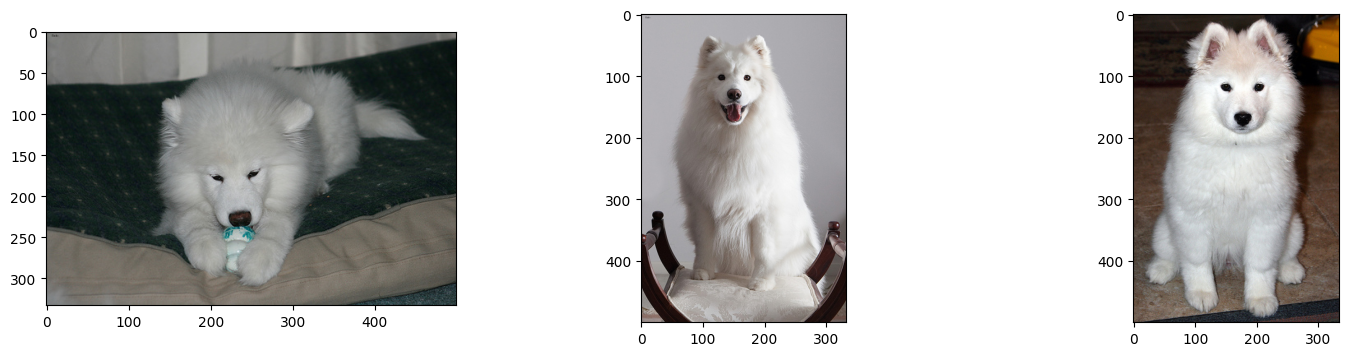

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img3)
plt.show()

Groundtruth masks are **trimaps** with regions corresponding to : pet body (label `1`), background (label `2`) and ambiguous (pet body boundaries and/or any accessory such as collars) areas (label `3`).

[texte du lien](https://)**Question 2 -** Store images and associated masks in single array structures (`imgs` and `segs`) after `64x64` reshaping for further deep learning processing. Background and ambiguous areas will be labeled as `0`, pet body regions at `1`.

In [8]:
import numpy as np
from skimage.transform import resize

id_min, id_max = 1, 200
size_ = 64
imgs = np.ndarray((id_max, size_, size_, 3), dtype=np.float32)
segs = np.ndarray((id_max, size_, size_, 1), dtype=np.uint8)
idxs = []

for id_ in range(id_min, id_max+1):
    name = 'samoyed-'+str(id_)
    img = name + '.jpg'
    seg = name + '.png'
    img= io.imread(os.path.join(base_path,img))
    seg = io.imread(os.path.join(base_path,seg))
    imgs[id_-1,:,:,:] = resize(img, (size_, size_), preserve_range=True ).astype(np.uint8)
    segs[id_-1,:,:,0] = resize(seg, (size_, size_),preserve_range=True).astype(np.uint8)
    # background/ambiguous areas at 0, pet body regions at 1
    segs[segs>1]=0
    idxs.append(name)

**Question 3 -** Implement and apply a function `normalization()` which standardizes the dataset (center to the mean and scale to unit variance).

In [9]:
def normalization(imgs):
    imgs = imgs.astype('float32', copy=False)
    mean = np.mean(imgs)
    std=np.std(imgs)
    imgs= ( imgs-mean )/std
    return imgs

imgs = normalization(imgs)


Now, let us display the first four images with associated **binary** groundtruth masks.

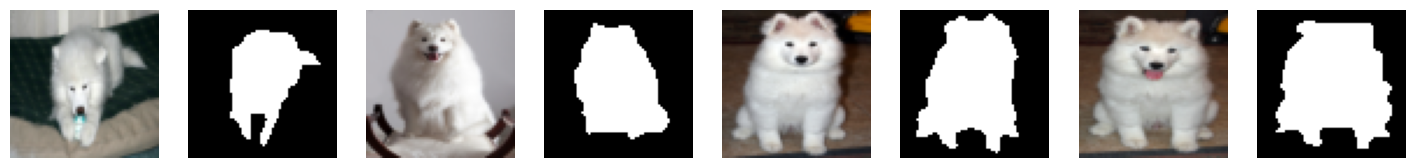

In [10]:
from skimage.exposure import rescale_intensity

plt.figure(figsize=(18, 4))
plt.subplot(181)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[0], in_range=(np.min(imgs[0]),np.max(imgs[0])), out_range=(0,1)))
plt.subplot(182)
plt.axis('off')
plt.imshow(segs[0,:,:,0], cmap='gray')
plt.subplot(183)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[1], in_range=(np.min(imgs[1]),np.max(imgs[1])), out_range=(0,1)))
plt.subplot(184)
plt.axis('off')
plt.imshow(segs[1,:,:,0], cmap='gray')
plt.subplot(185)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[2], in_range=(np.min(imgs[2]),np.max(imgs[2])), out_range=(0,1)))
plt.subplot(186)
plt.axis('off')
plt.imshow(segs[2,:,:,0], cmap='gray')
plt.subplot(187)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[3], in_range=(np.min(imgs[3]),np.max(imgs[3])), out_range=(0,1)))
plt.subplot(188)
plt.axis('off')
plt.imshow(segs[3,:,:,0], cmap='gray')
plt.show()

**Question 4 -** Divide the dataset into 2 subsets. The first `80%` will belong to the training set, the last `20%` to the test set.

In [11]:

ratio = 0.8
split = int(len(imgs)*ratio)
print('dataset size =', len(imgs), '; first', split, 'images for training, remaining for test')
train_imgs = imgs[:split]
train_segs = segs[:split]
test_imgs  =  imgs[split:]
test_segs  = segs[split:]
train_idxs = idxs[:split]
test_idxs  = idxs[split:]

print(test_idxs)

dataset size = 200 ; first 160 images for training, remaining for test
['samoyed-161', 'samoyed-162', 'samoyed-163', 'samoyed-164', 'samoyed-165', 'samoyed-166', 'samoyed-167', 'samoyed-168', 'samoyed-169', 'samoyed-170', 'samoyed-171', 'samoyed-172', 'samoyed-173', 'samoyed-174', 'samoyed-175', 'samoyed-176', 'samoyed-177', 'samoyed-178', 'samoyed-179', 'samoyed-180', 'samoyed-181', 'samoyed-182', 'samoyed-183', 'samoyed-184', 'samoyed-185', 'samoyed-186', 'samoyed-187', 'samoyed-188', 'samoyed-189', 'samoyed-190', 'samoyed-191', 'samoyed-192', 'samoyed-193', 'samoyed-194', 'samoyed-195', 'samoyed-196', 'samoyed-197', 'samoyed-198', 'samoyed-199', 'samoyed-200']


The functions provided below aims at computing the dice score which will be used as **loss function** in our deep learning networks.

In [12]:
import tensorflow
from tensorflow.keras import backend

#The dice coeff is an evaluating matrix

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = tensorflow.cast(backend.flatten(y_true), dtype='float32')
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Rather than extracting individual patches from the image and classifying these patches independently, we will first employ a stack of convolutional layers preserving the spatial size of the input : **Fully Convolutional Networks** (FCN).

**Question 5 -** Implement a FCN network with `7` convolutional layers: `2` with `32` `3x3` filters and Rectified Linear Unit (ReLU) activation, `2` with `64` `3x3` filters and ReLU activation, `2` with `128` `3x3` filters and ReLU activation as well as a final `1x1` convolutional layer with sigmoid activation to achieve pixel-wise segmentation.

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def get_model_1(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)


    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv7 = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(conv6)


    model = Model(inputs=[inputs], outputs=[conv7])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Let us now display the network architecture with `model.summary()`, define the batch size and the number of epochs, define the model checkpoint (https://keras.io/callbacks/), run the training with `model.fit()` and display how the dice score evolves during training for both training and test datasets.

In [14]:
model_1 = get_model_1(size_, size_)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       147584

In [15]:
batch_size = 10
epochs = 200

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')

By using the option `save_best_only=True`, the latest best model according to the quantity monitored (`val_dice_coef`) will not be overwritten.

In [17]:
hist_1 = model_1.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

Epoch 1/200
16/16 [==============================] - 9s 32ms/step - loss: -0.5643 - dice_coef: 0.5643 - val_loss: -0.5617 - val_dice_coef: 0.5617
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6585 - dice_coef: 0.6585 - val_loss: -0.5875 - val_dice_coef: 0.5875
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6671 - dice_coef: 0.6671 - val_loss: -0.5972 - val_dice_coef: 0.5972
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6834 - dice_coef: 0.6834 - val_loss: -0.6060 - val_dice_coef: 0.6060
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6856 - dice_coef: 0.6856 - val_loss: -0.6138 - val_dice_coef: 0.6138
Epoch 6/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6945 - dice_coef: 0.6945 - val_loss: -0.6110 - val_dice_coef: 0.6110
Epoch 7/200
16/16 [==============================] - 0s 17ms/step - loss: -0.6918 - dice_coef: 0.6918 - val_loss: -0.5994 - 

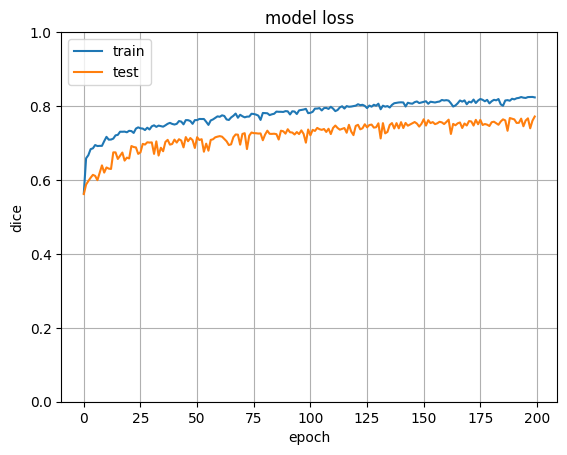

In [18]:
def display_history(hist):
    plt.plot(hist.history['dice_coef'])
    plt.plot(hist.history['val_dice_coef'])
    plt.title('model loss')
    plt.grid()
    plt.ylabel('dice')
    plt.ylim([0,1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_history(hist_1)

**Question 6 -** Using the provided `dice_assessment()` and `visualize_predicted_boundary()` functions to be read and understood, implement and apply `make_prediction()` to provide for each test image the predicted segmentation mask as well as the dice score. Dice scores will be stored in the array `dices`. What is the average dice score obtained for the test set?

In [19]:
def dice_assessment(result, GT, label=1):
    A = GT == label
    B = result == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    TN = len(np.nonzero((~A)*(~B))[0])
    dice = 0
    if (FP+2*TP+FN) != 0 :
        dice = float(2)*TP/(FP+2*TP+FN)
    return dice

In [20]:
from skimage.segmentation import mark_boundaries

def visualize_predicted_boundary(img, pred, groundtruth):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    out = mark_boundaries(img, groundtruth, color=(0, 1, 0), background_label=4)
    out = mark_boundaries(out, pred, color=(1, 0, 0), background_label=2)
    return out

In [21]:
print (train_imgs.shape)
print (test_imgs.shape)
print (test_segs.shape)


(160, 64, 64, 3)
(40, 64, 64, 3)
(40, 64, 64, 1)


In [22]:
def make_prediction(model, test_idxs, test_imgs, test_segs):
    dices = []
    for idx, id_ in enumerate(test_idxs):
        pred =model.predict(test_imgs[idx:idx+1, :, :, 0:3])[0,:,:,0].astype(np.uint8) # prediction b,64,64,3 64,64

        groundtruth = test_segs[idx, : , :,0] #64,64
        print(pred.shape, groundtruth.shape)
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.axis('off')
        plt.imshow(rescale_intensity(test_imgs[idx], in_range=(np.min(test_imgs[idx]),np.max(test_imgs[idx])), out_range=(0,1)))
        plt.subplot(132)
        plt.axis('off')
        plt.imshow(pred, cmap='gray')
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(visualize_predicted_boundary(test_imgs[idx], pred, groundtruth)) # TO DO # image with super-imposed prediction and groundruth
        plt.show()
        dice = dice_assessment(pred, groundtruth, label=1)
        print('dice for', id_, ': %02.3f'%(dice))
        dices.append(dice)
    return np.array(dices)

1/1 [==============================] - 0s 467ms/step
(64, 64) (64, 64)


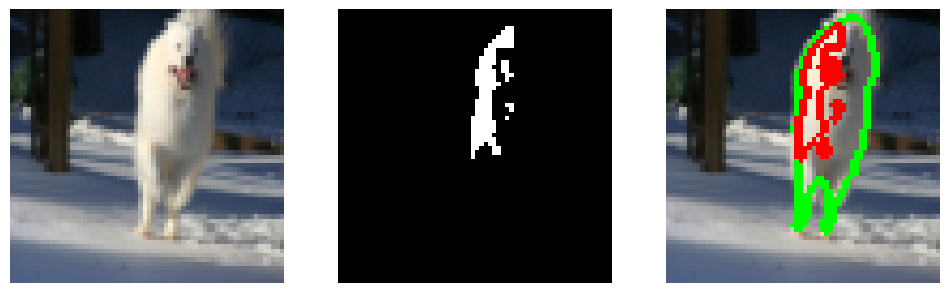

dice for samoyed-161 : 0.387
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


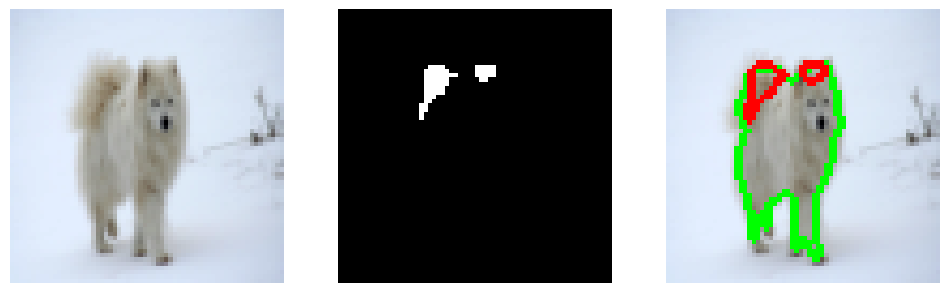

dice for samoyed-162 : 0.159
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


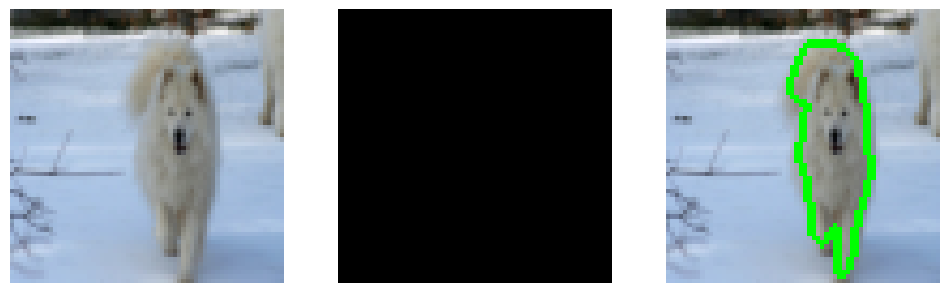

dice for samoyed-163 : 0.000
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


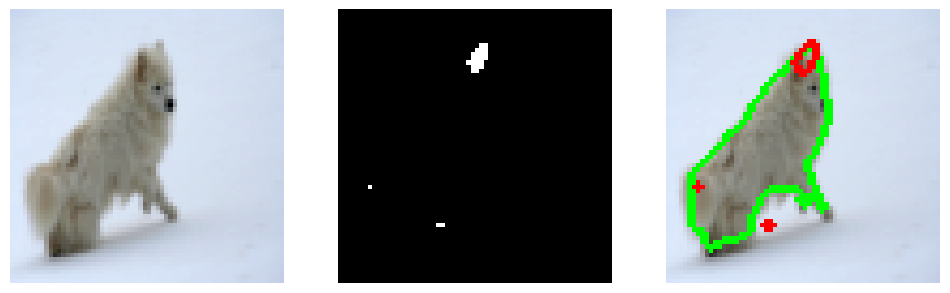

dice for samoyed-164 : 0.050
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


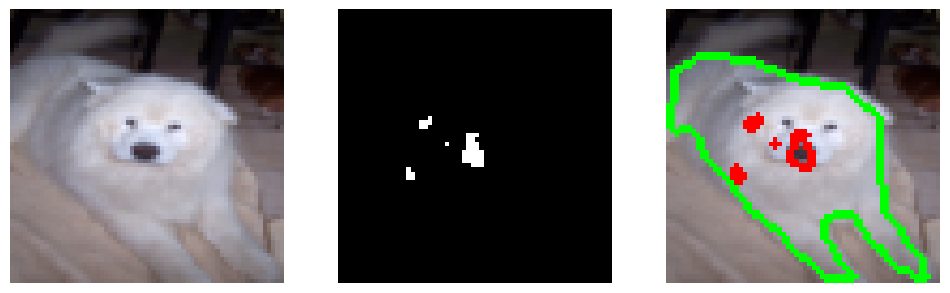

dice for samoyed-165 : 0.049
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


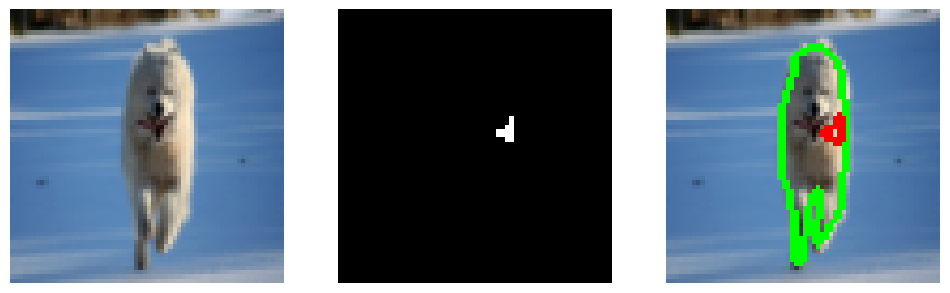

dice for samoyed-166 : 0.051
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


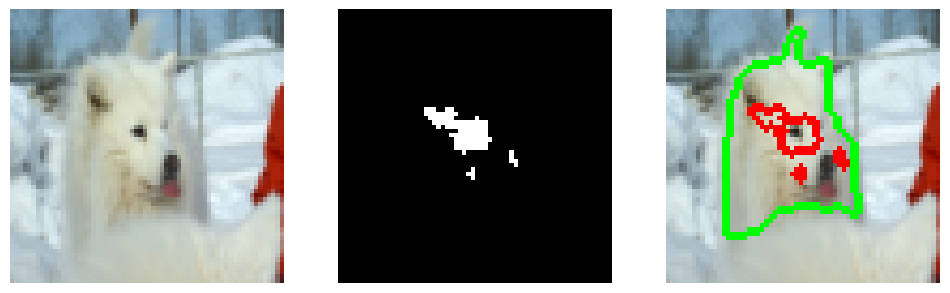

dice for samoyed-167 : 0.177
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


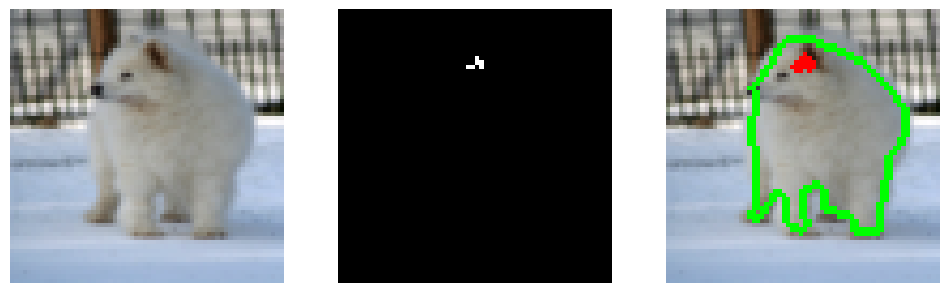

dice for samoyed-168 : 0.010
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


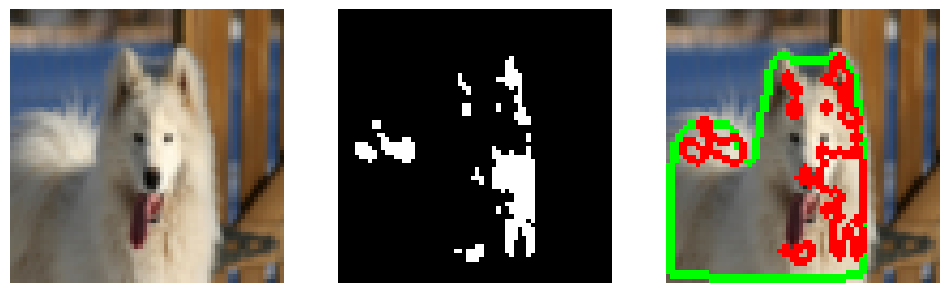

dice for samoyed-169 : 0.277
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


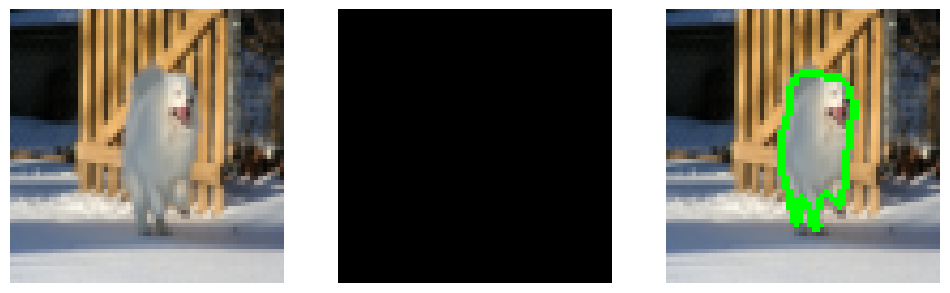

dice for samoyed-170 : 0.000
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


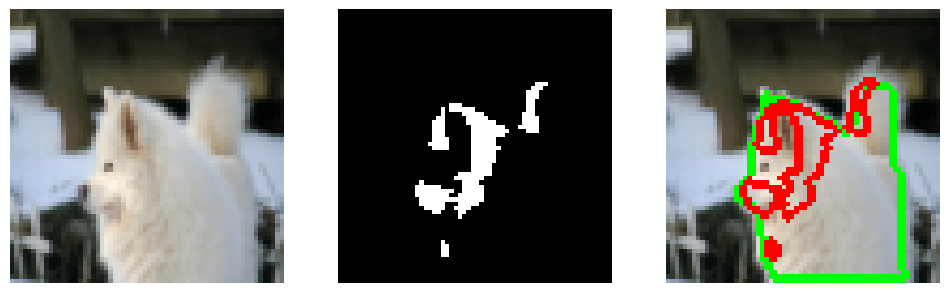

dice for samoyed-171 : 0.325
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


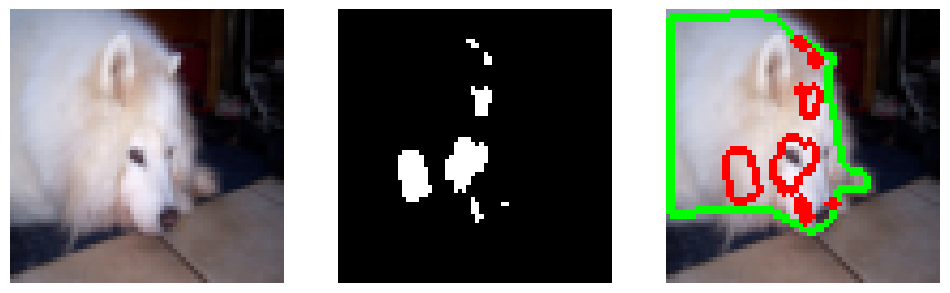

dice for samoyed-172 : 0.207
1/1 [==============================] - 0s 36ms/step
(64, 64) (64, 64)


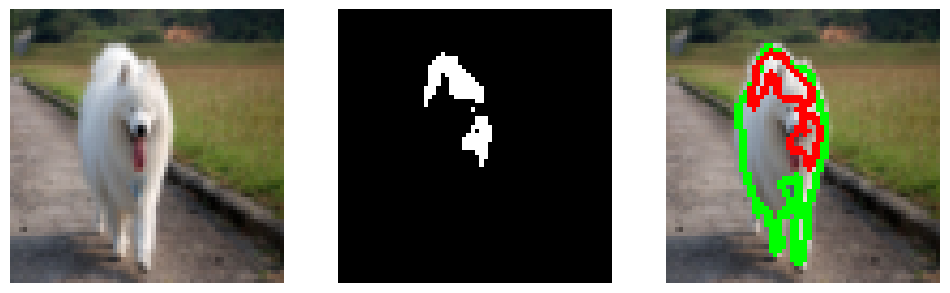

dice for samoyed-173 : 0.371
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


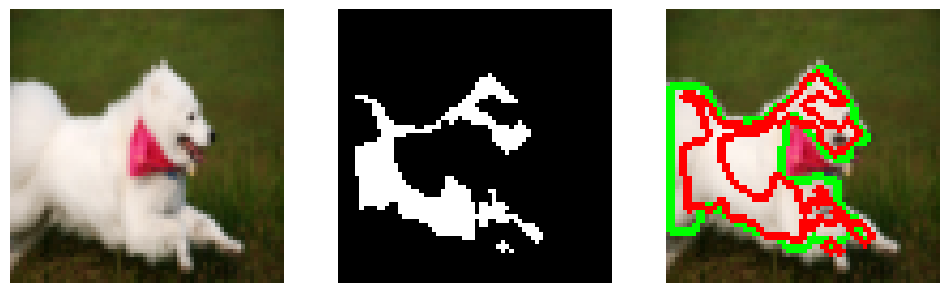

dice for samoyed-174 : 0.628
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


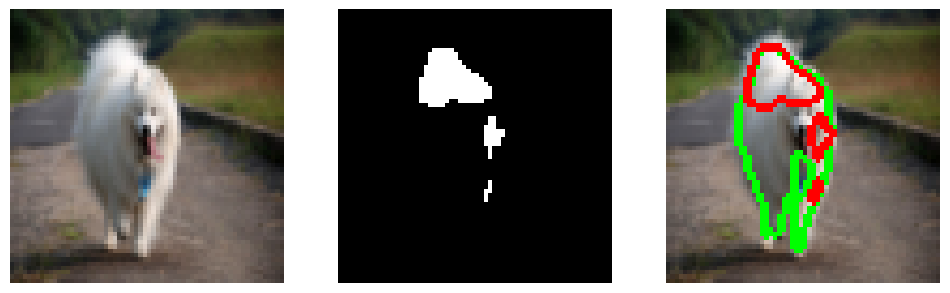

dice for samoyed-175 : 0.452
1/1 [==============================] - 0s 18ms/step
(64, 64) (64, 64)


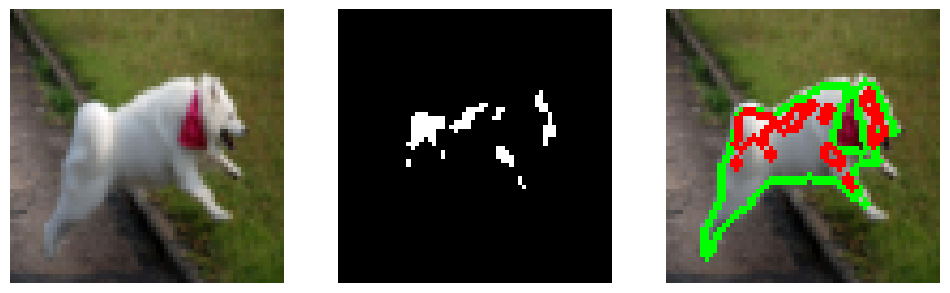

dice for samoyed-176 : 0.294
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


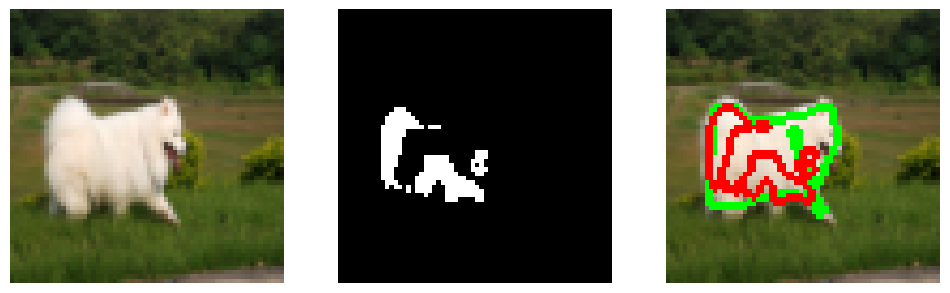

dice for samoyed-177 : 0.512
1/1 [==============================] - 0s 35ms/step
(64, 64) (64, 64)


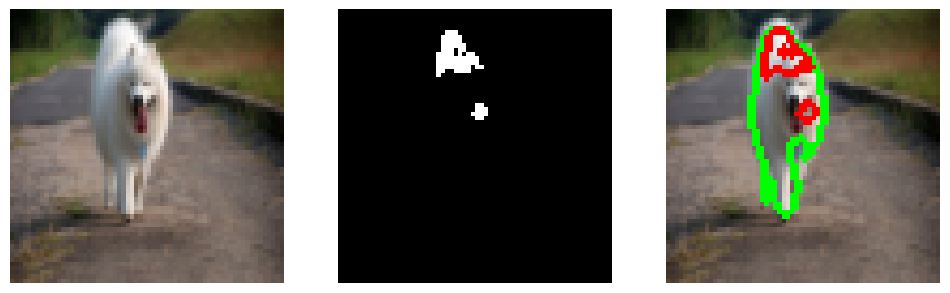

dice for samoyed-178 : 0.290
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


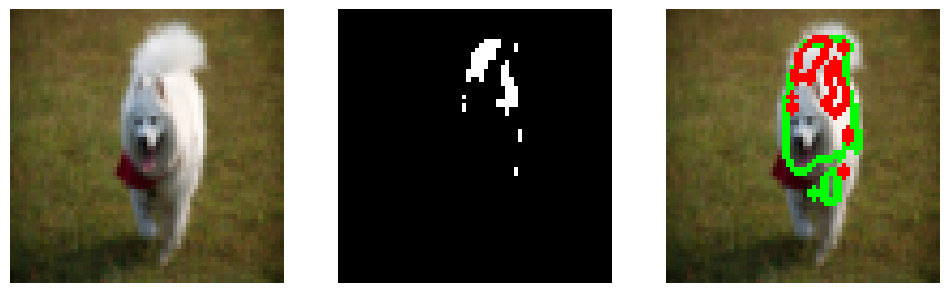

dice for samoyed-179 : 0.325
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


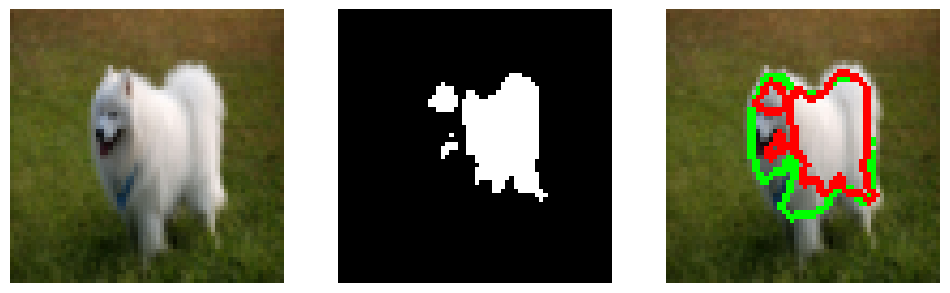

dice for samoyed-180 : 0.765
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


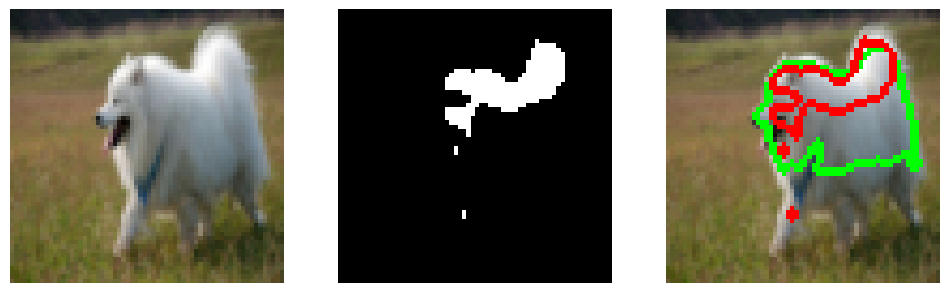

dice for samoyed-181 : 0.493
1/1 [==============================] - 0s 84ms/step
(64, 64) (64, 64)


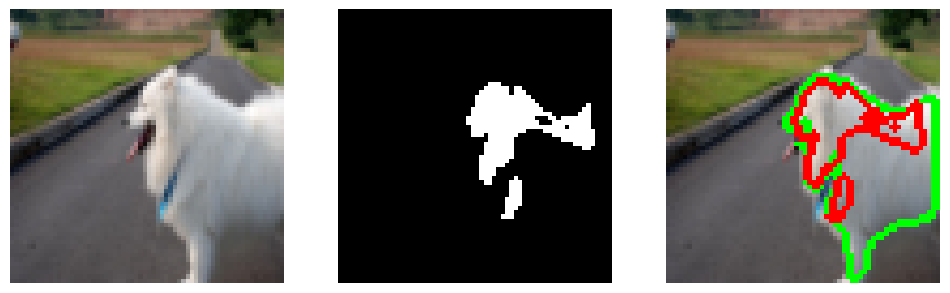

dice for samoyed-182 : 0.511
1/1 [==============================] - 0s 111ms/step
(64, 64) (64, 64)


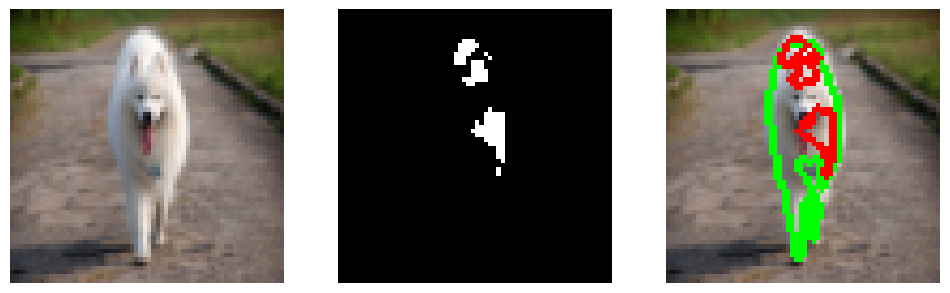

dice for samoyed-183 : 0.336
1/1 [==============================] - 0s 59ms/step
(64, 64) (64, 64)


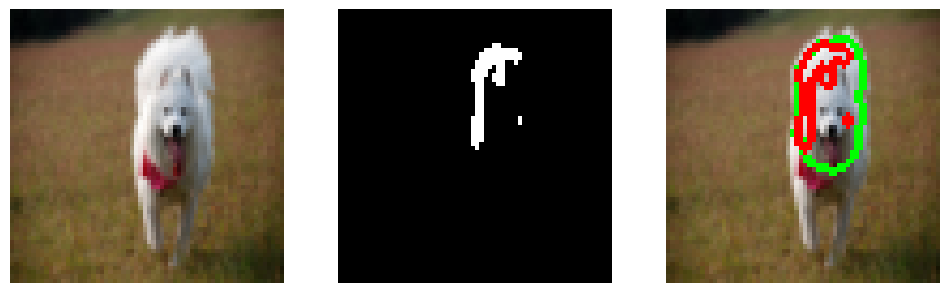

dice for samoyed-184 : 0.406
1/1 [==============================] - 0s 71ms/step
(64, 64) (64, 64)


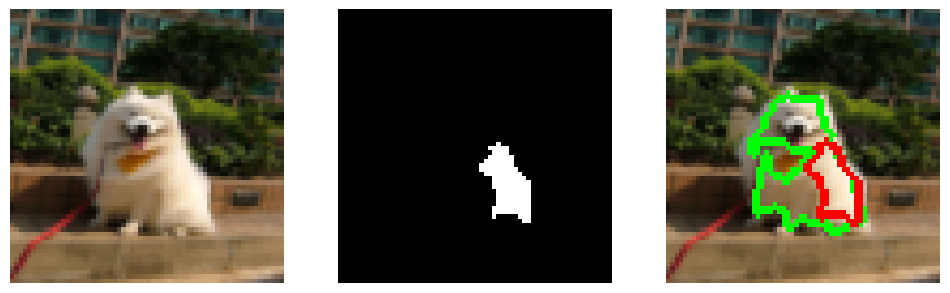

dice for samoyed-185 : 0.419
1/1 [==============================] - 0s 34ms/step
(64, 64) (64, 64)


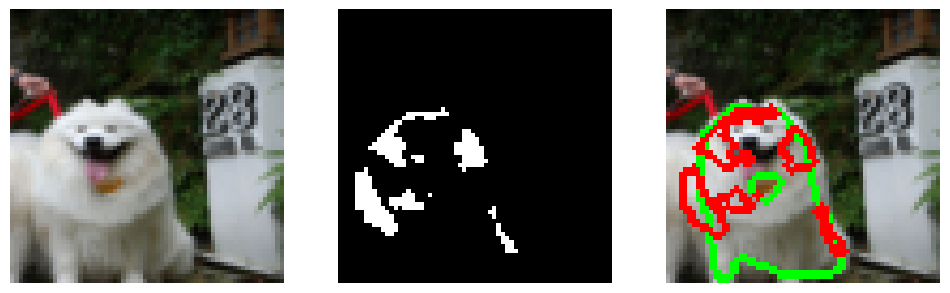

dice for samoyed-186 : 0.290
1/1 [==============================] - 0s 177ms/step
(64, 64) (64, 64)


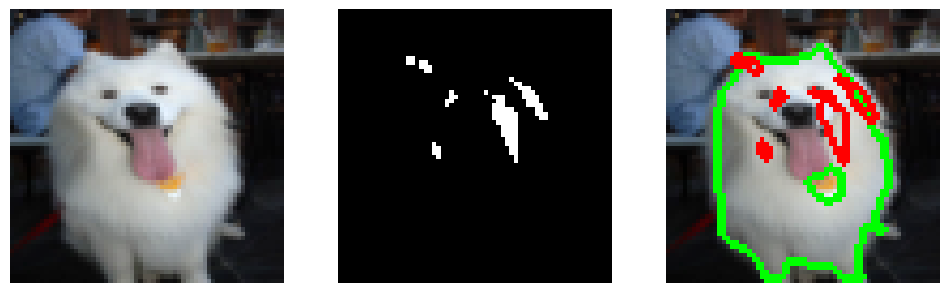

dice for samoyed-187 : 0.104
1/1 [==============================] - 0s 78ms/step
(64, 64) (64, 64)


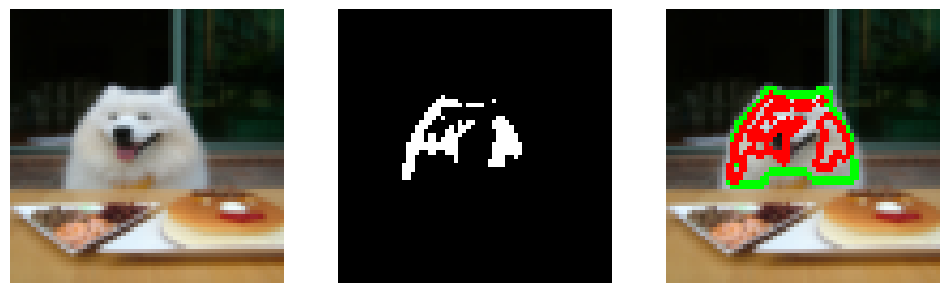

dice for samoyed-188 : 0.522
1/1 [==============================] - 0s 68ms/step
(64, 64) (64, 64)


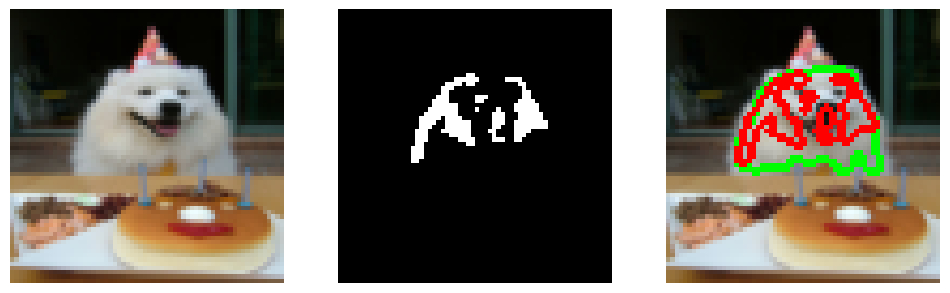

dice for samoyed-189 : 0.499
1/1 [==============================] - 0s 41ms/step
(64, 64) (64, 64)


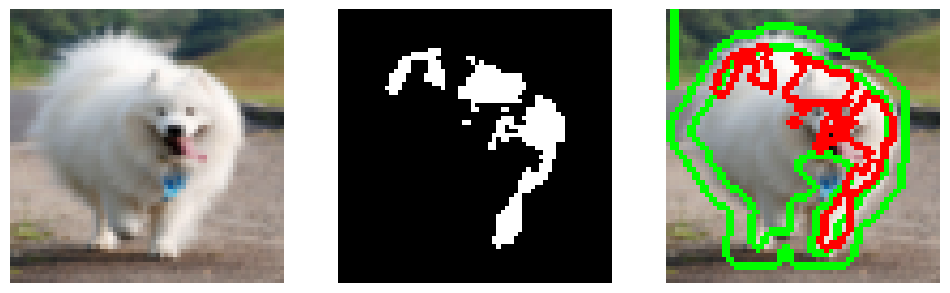

dice for samoyed-190 : 0.215
1/1 [==============================] - 0s 18ms/step
(64, 64) (64, 64)


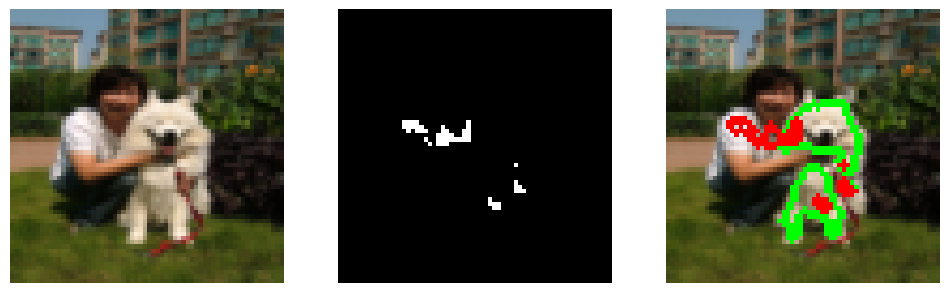

dice for samoyed-191 : 0.112
1/1 [==============================] - 0s 38ms/step
(64, 64) (64, 64)


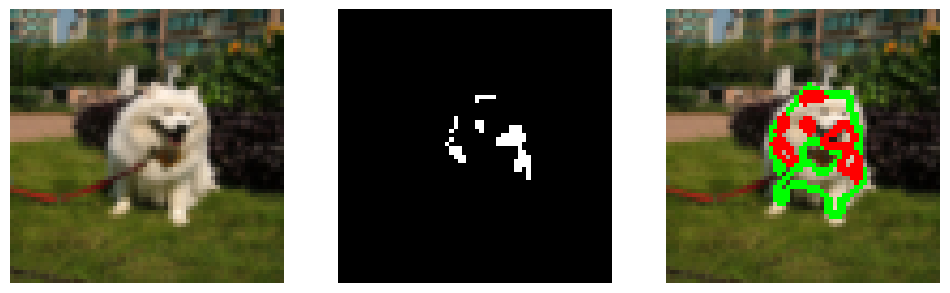

dice for samoyed-192 : 0.323
1/1 [==============================] - 0s 53ms/step
(64, 64) (64, 64)


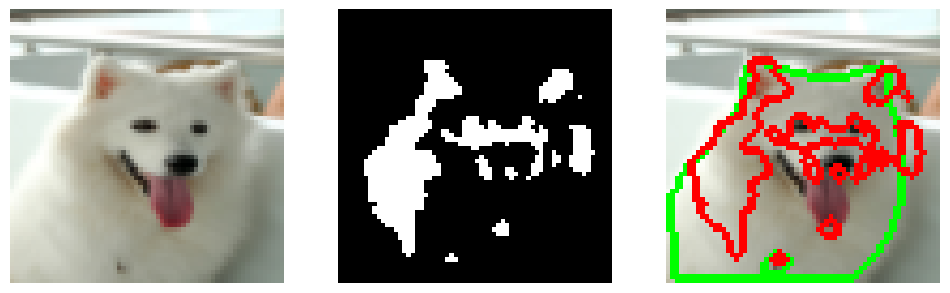

dice for samoyed-193 : 0.416
1/1 [==============================] - 0s 48ms/step
(64, 64) (64, 64)


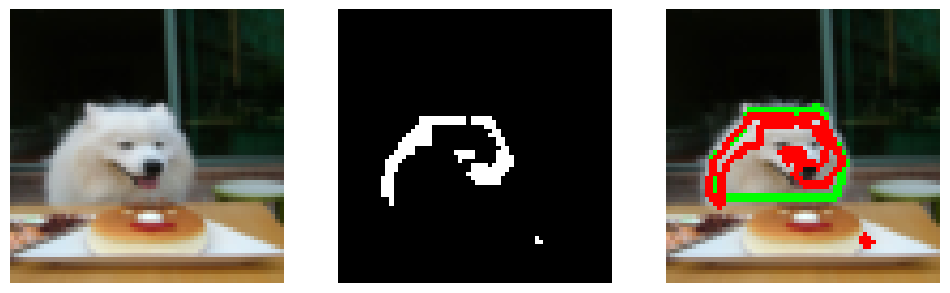

dice for samoyed-194 : 0.481
1/1 [==============================] - 0s 43ms/step
(64, 64) (64, 64)


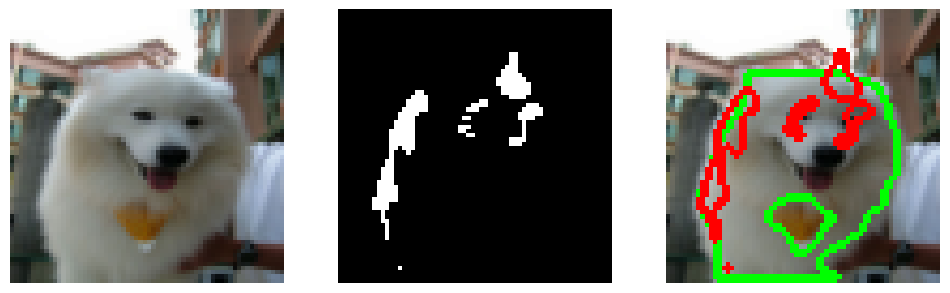

dice for samoyed-195 : 0.210
1/1 [==============================] - 0s 119ms/step
(64, 64) (64, 64)


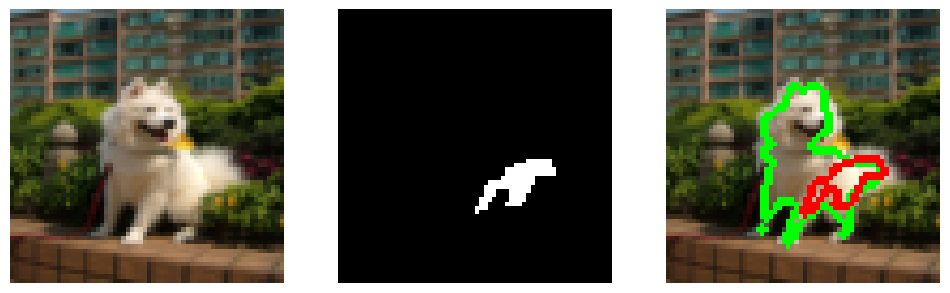

dice for samoyed-196 : 0.297
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


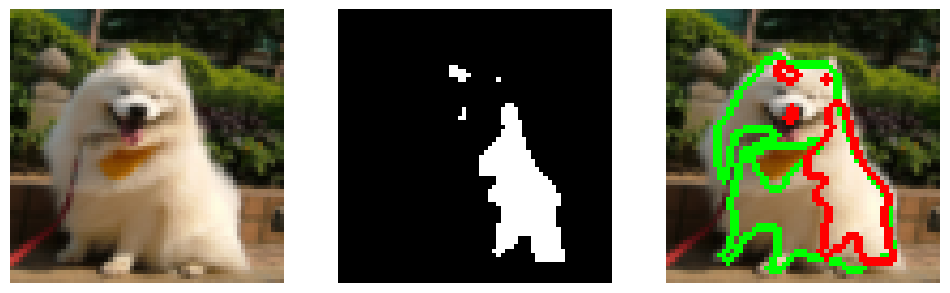

dice for samoyed-197 : 0.485
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


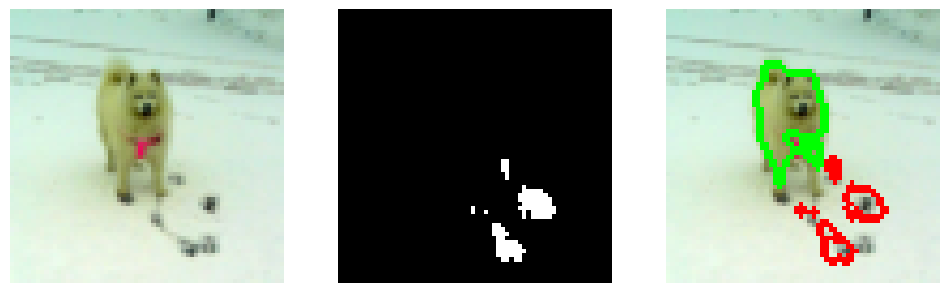

dice for samoyed-198 : 0.000
1/1 [==============================] - 0s 18ms/step
(64, 64) (64, 64)


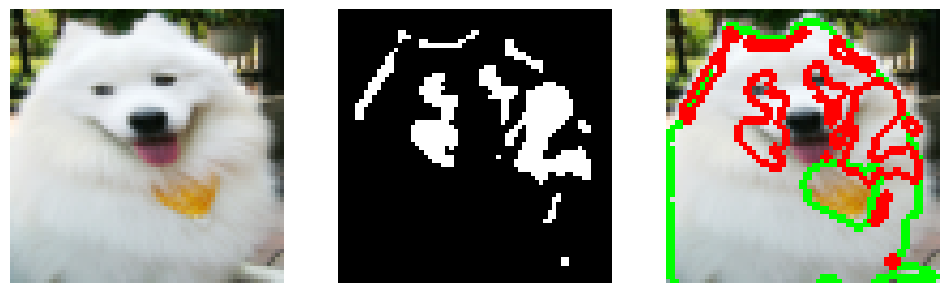

dice for samoyed-199 : 0.305
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


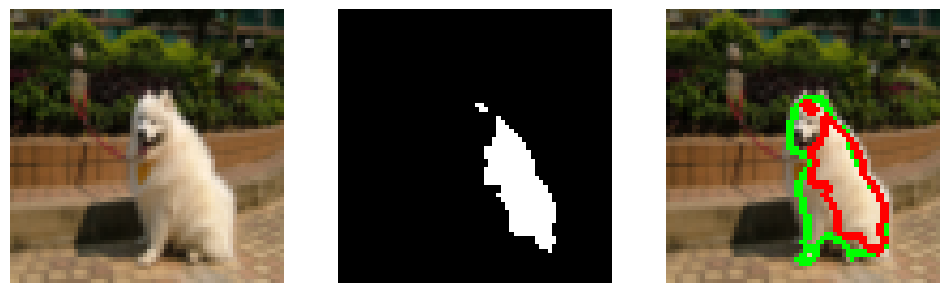

dice for samoyed-200 : 0.705
average dice: 0.311


In [23]:
dices_1 = make_prediction(model_1, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_1))) # TO DO

Better deep learning networks can be reached using some **downsampling** and **upsampling** operations to obtain what we call a **convolutional encoder-decoder** (CED).

**Question 7 -** Implement a new network consisting of patterns of `2` convolutional layers followed by a pooling (resp. upsampling) layer for encoding (decoding) branches using `MaxPooling2D` (`Conv2DTranspose`). Between encoding and decoding branches, `2` convolutional layers will be used (`conv3`). Convolutional layers will exploit `3x3` filters followed by ReLU activations. Spatial size will be reduced (increased) with `2×2` max pooling (upsampling) layers. The `2` first convolutional layer will generate `32` channels. This number will double after each pattern.

In [24]:
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose

def get_model_2(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    up4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    up5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4) # TO DO
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    conv6 = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(conv5)

    model = Model(inputs=[inputs], outputs=[conv6])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model


**Question 8 -** Run the training and use `make_prediction()` to provide predicted segmentation masks. What is the average dice score obtained for the test set?

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                           

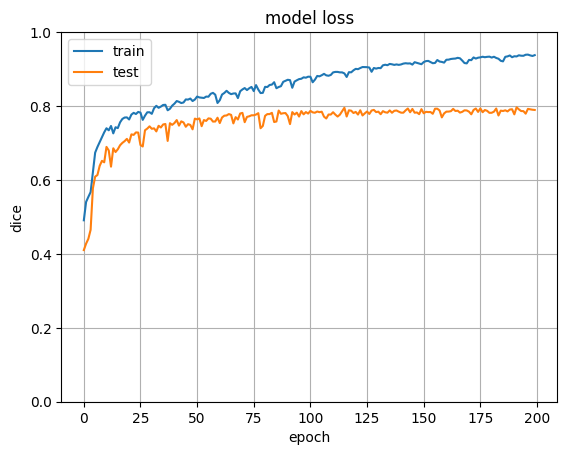

1/1 [==============================] - 1s 553ms/step
(64, 64) (64, 64)


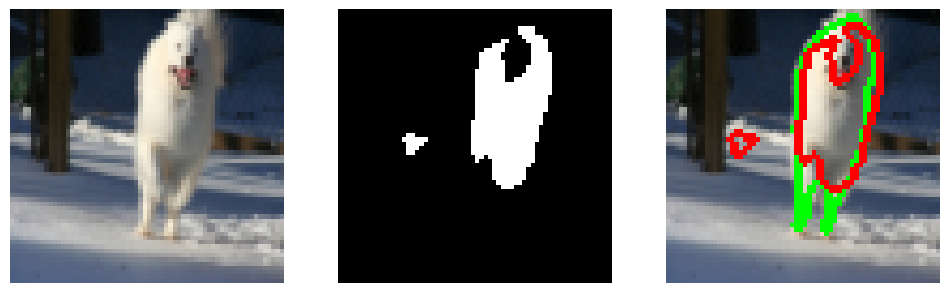

dice for samoyed-161 : 0.788
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


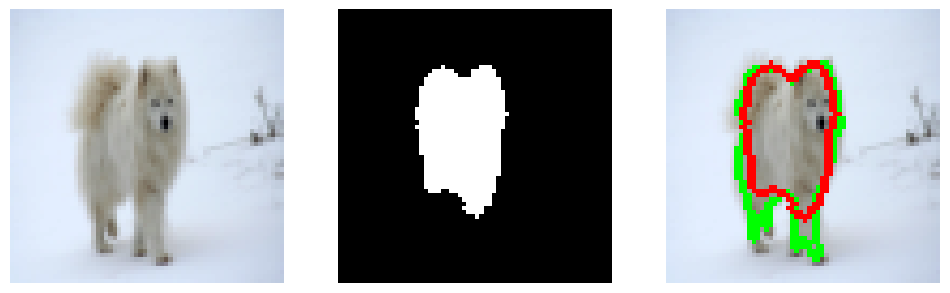

dice for samoyed-162 : 0.867
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


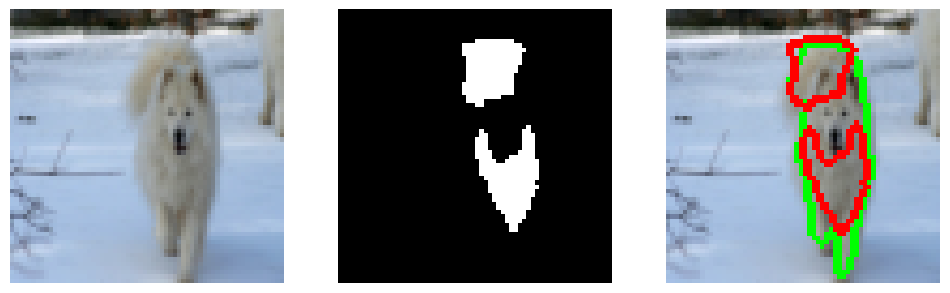

dice for samoyed-163 : 0.665
1/1 [==============================] - 0s 42ms/step
(64, 64) (64, 64)


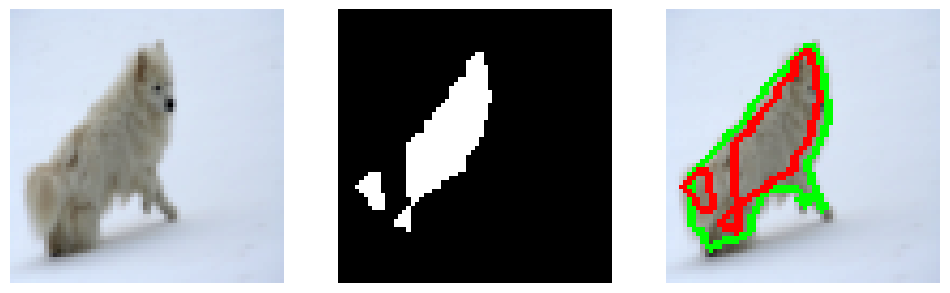

dice for samoyed-164 : 0.682
1/1 [==============================] - 0s 74ms/step
(64, 64) (64, 64)


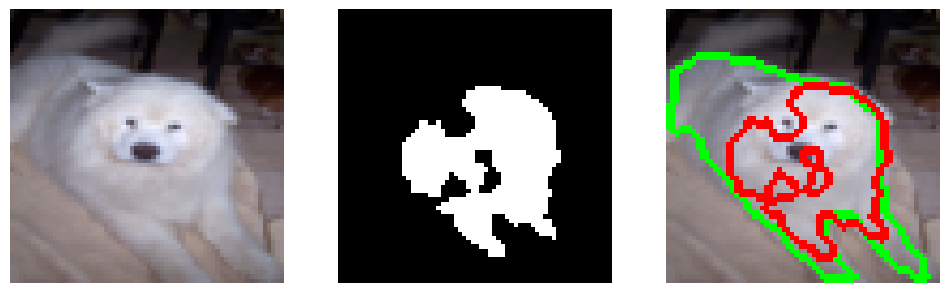

dice for samoyed-165 : 0.665
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


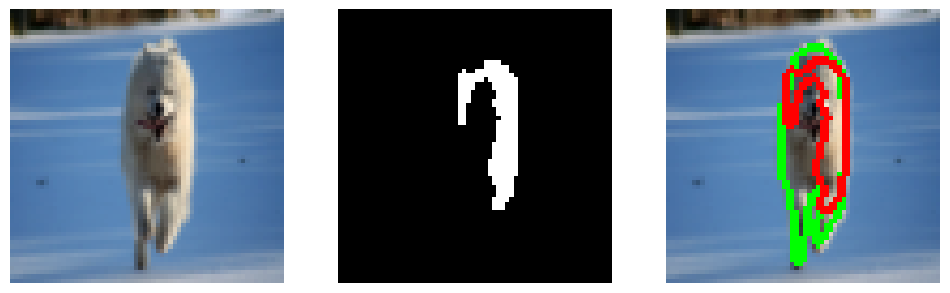

dice for samoyed-166 : 0.568
1/1 [==============================] - 0s 50ms/step
(64, 64) (64, 64)


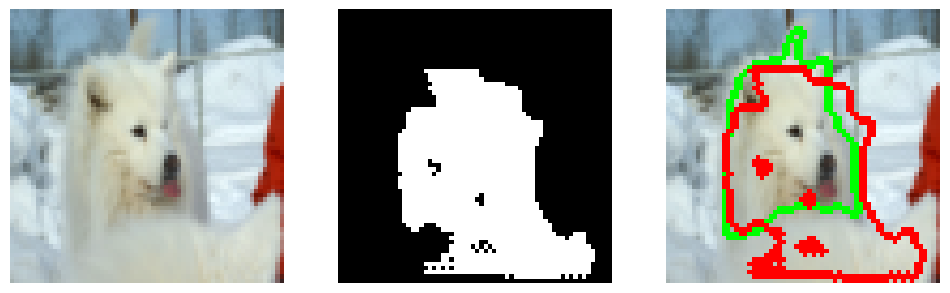

dice for samoyed-167 : 0.694
1/1 [==============================] - 0s 82ms/step
(64, 64) (64, 64)


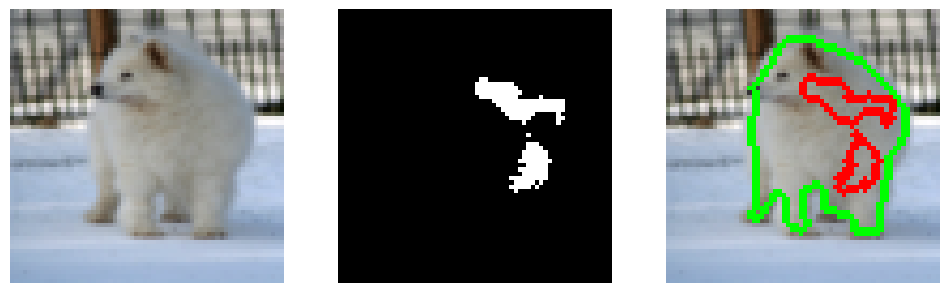

dice for samoyed-168 : 0.258
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


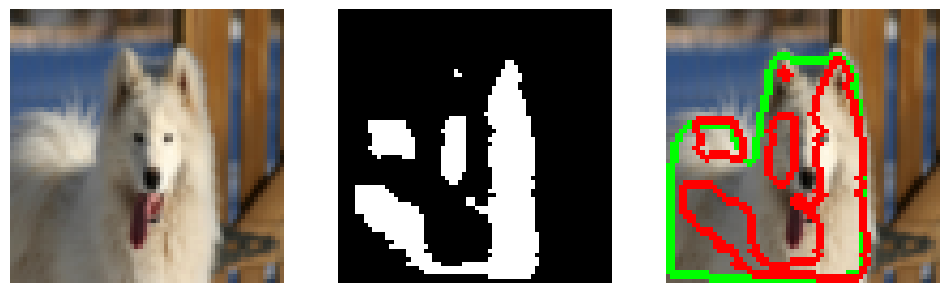

dice for samoyed-169 : 0.622
1/1 [==============================] - 0s 36ms/step
(64, 64) (64, 64)


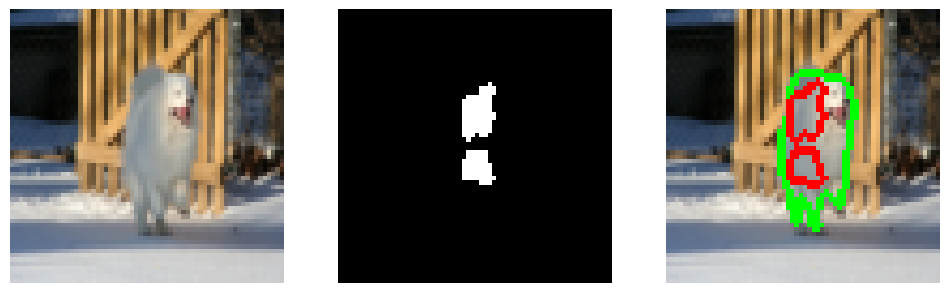

dice for samoyed-170 : 0.449
1/1 [==============================] - 0s 89ms/step
(64, 64) (64, 64)


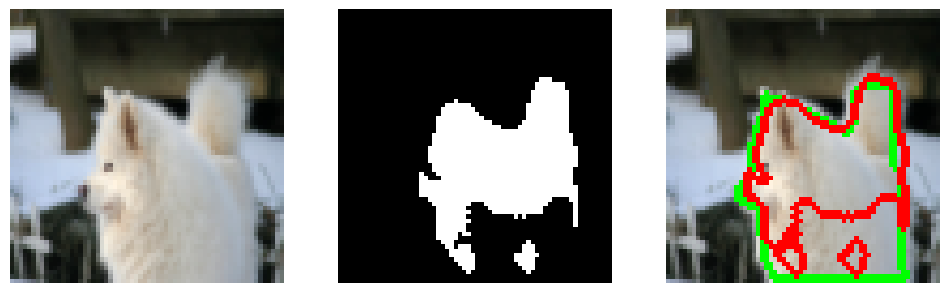

dice for samoyed-171 : 0.763
1/1 [==============================] - 0s 56ms/step
(64, 64) (64, 64)


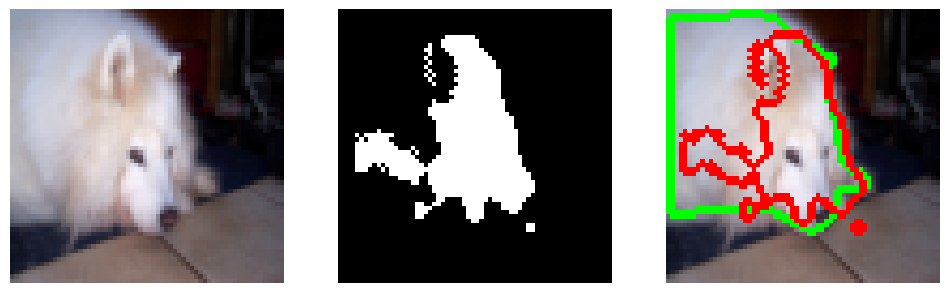

dice for samoyed-172 : 0.588
1/1 [==============================] - 0s 70ms/step
(64, 64) (64, 64)


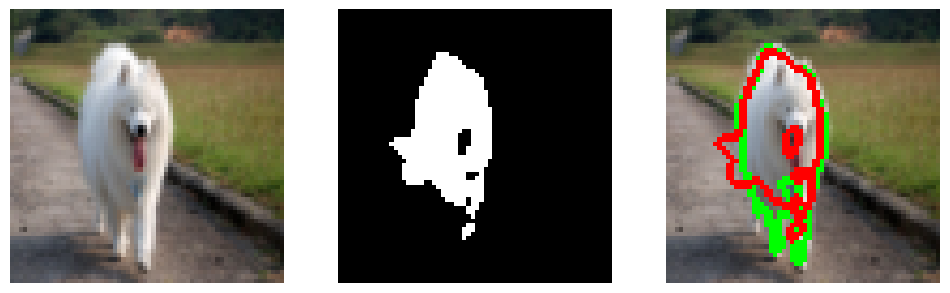

dice for samoyed-173 : 0.831
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


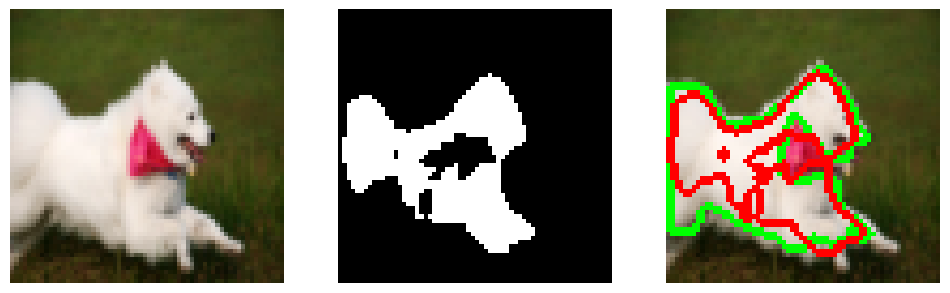

dice for samoyed-174 : 0.784
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


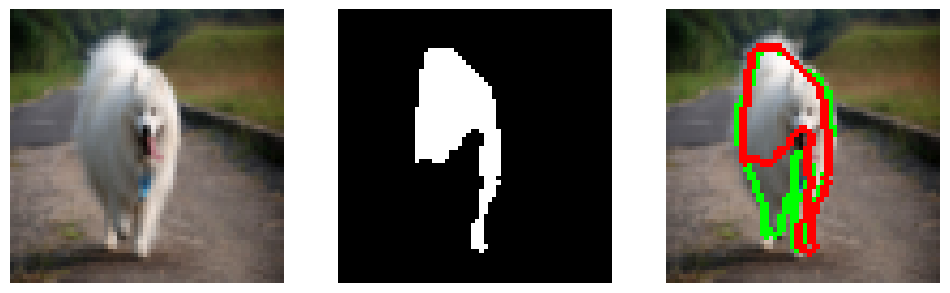

dice for samoyed-175 : 0.769
1/1 [==============================] - 0s 38ms/step
(64, 64) (64, 64)


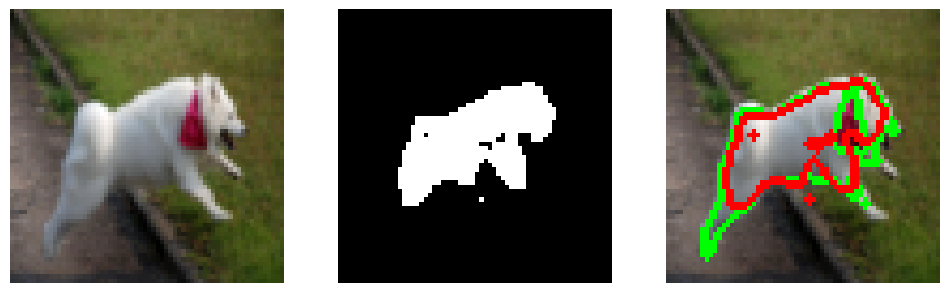

dice for samoyed-176 : 0.822
1/1 [==============================] - 0s 41ms/step
(64, 64) (64, 64)


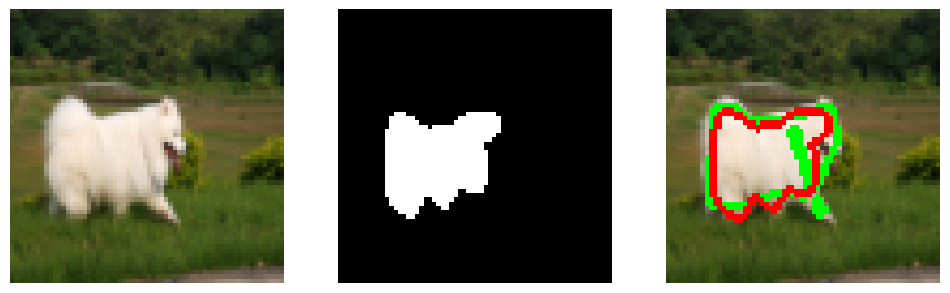

dice for samoyed-177 : 0.857
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


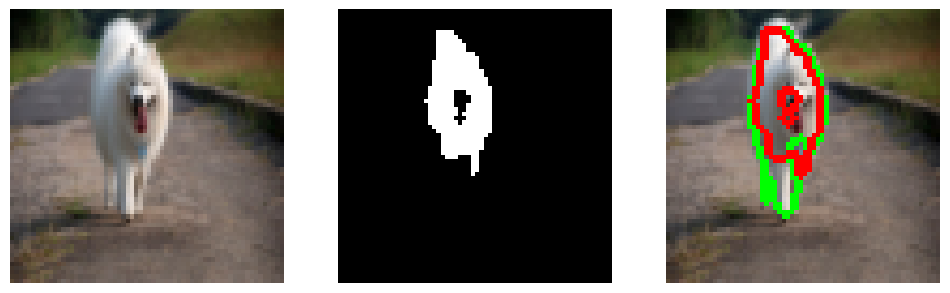

dice for samoyed-178 : 0.766
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


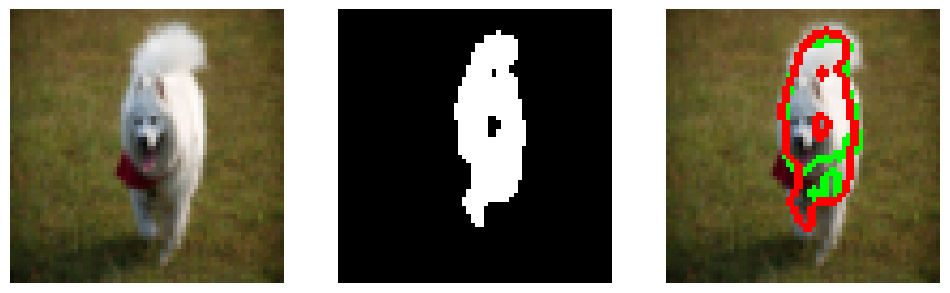

dice for samoyed-179 : 0.813
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


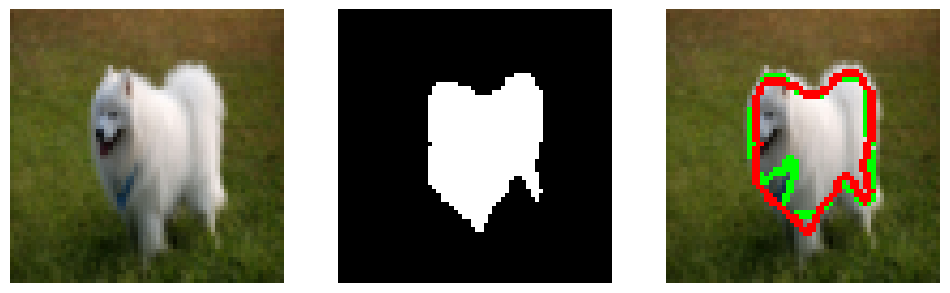

dice for samoyed-180 : 0.910
1/1 [==============================] - 0s 47ms/step
(64, 64) (64, 64)


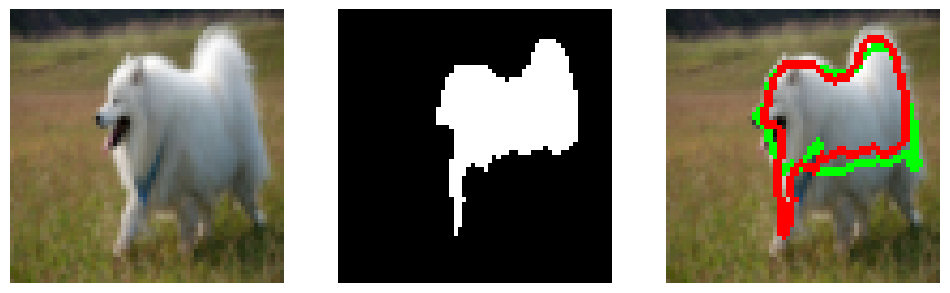

dice for samoyed-181 : 0.861
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


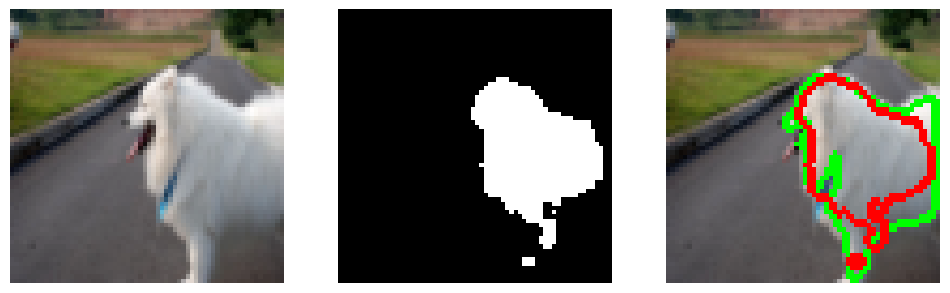

dice for samoyed-182 : 0.813
1/1 [==============================] - 0s 36ms/step
(64, 64) (64, 64)


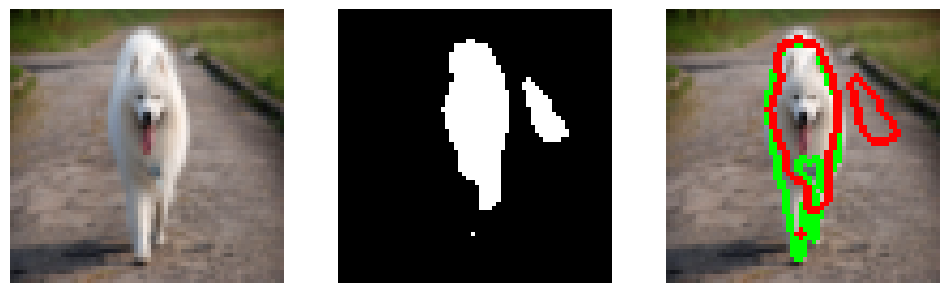

dice for samoyed-183 : 0.743
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


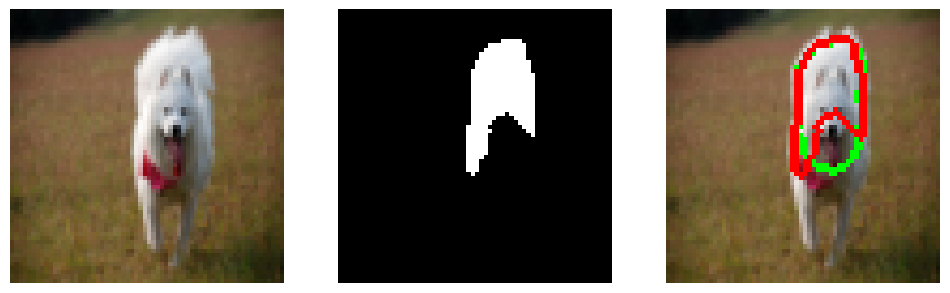

dice for samoyed-184 : 0.798
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


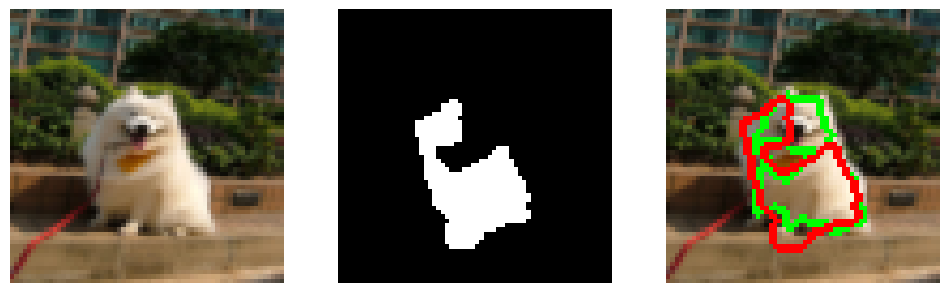

dice for samoyed-185 : 0.722
1/1 [==============================] - 0s 18ms/step
(64, 64) (64, 64)


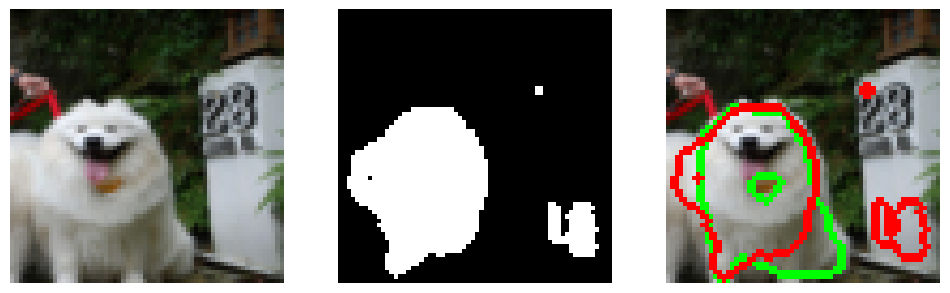

dice for samoyed-186 : 0.776
1/1 [==============================] - 0s 18ms/step
(64, 64) (64, 64)


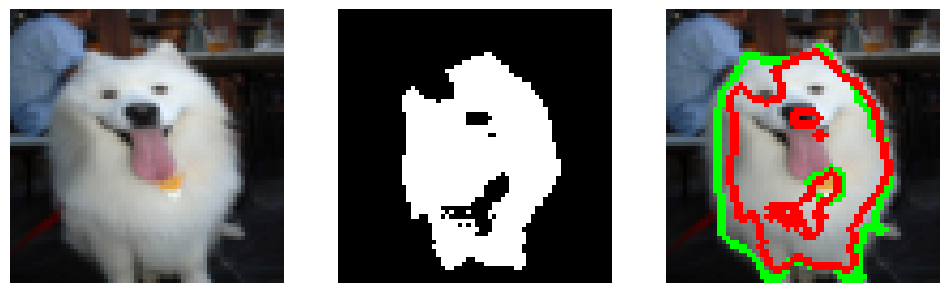

dice for samoyed-187 : 0.836
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


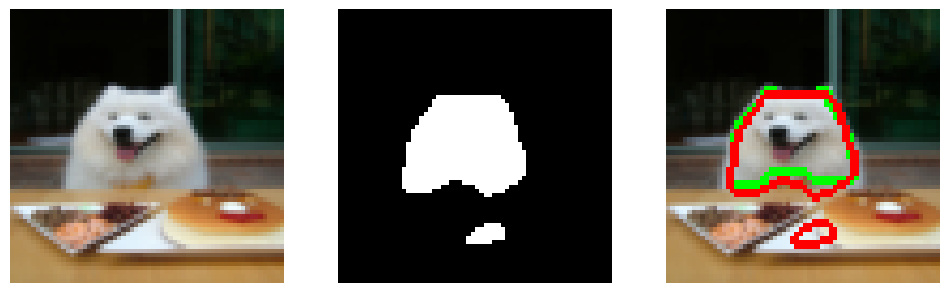

dice for samoyed-188 : 0.880
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


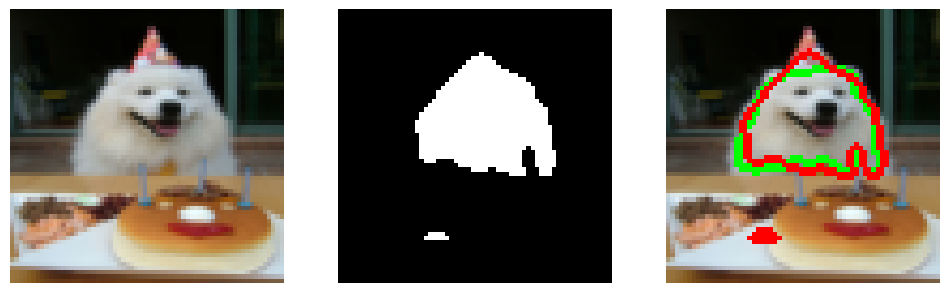

dice for samoyed-189 : 0.882
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


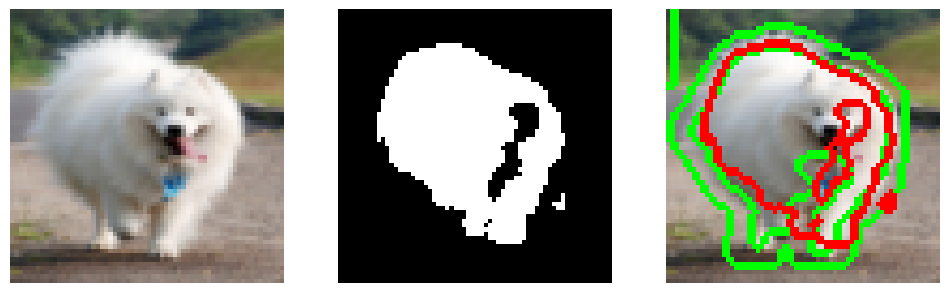

dice for samoyed-190 : 0.504
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


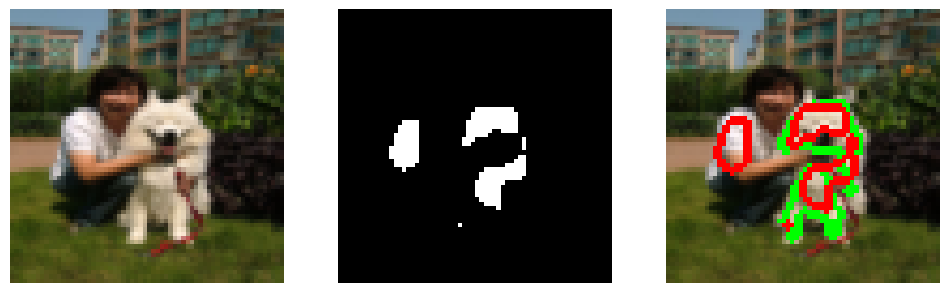

dice for samoyed-191 : 0.529
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


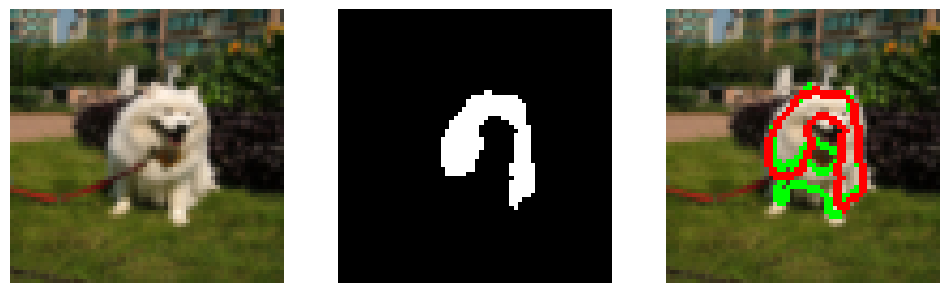

dice for samoyed-192 : 0.737
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


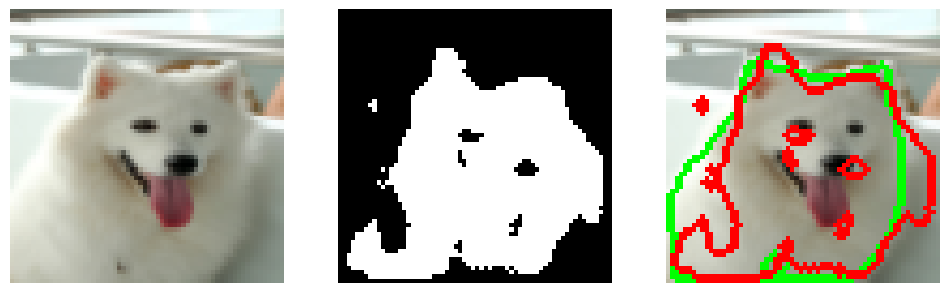

dice for samoyed-193 : 0.847
1/1 [==============================] - 0s 24ms/step
(64, 64) (64, 64)


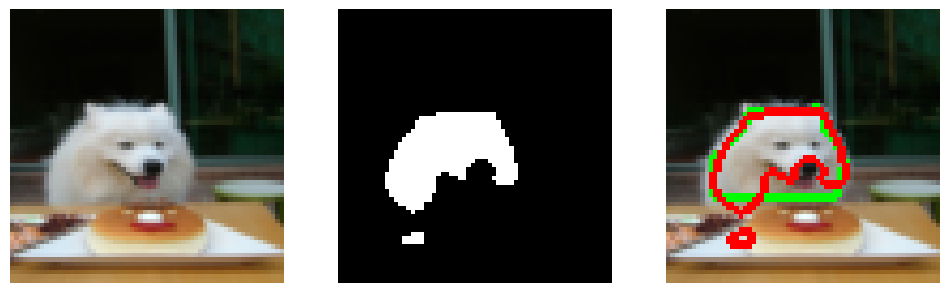

dice for samoyed-194 : 0.831
1/1 [==============================] - 0s 22ms/step
(64, 64) (64, 64)


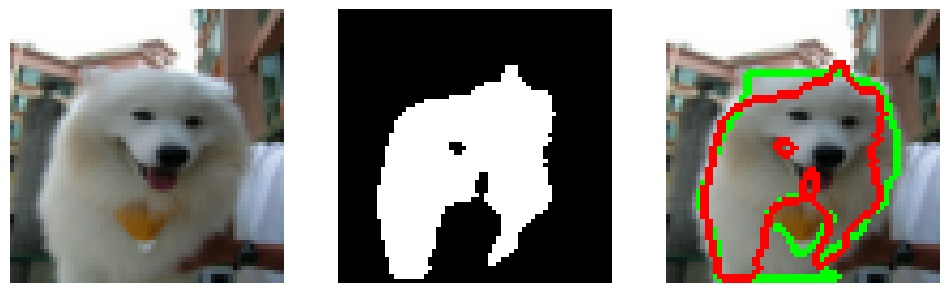

dice for samoyed-195 : 0.856
1/1 [==============================] - 0s 40ms/step
(64, 64) (64, 64)


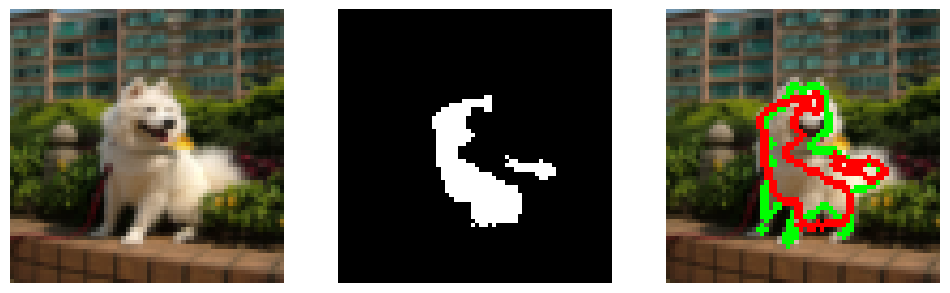

dice for samoyed-196 : 0.688
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


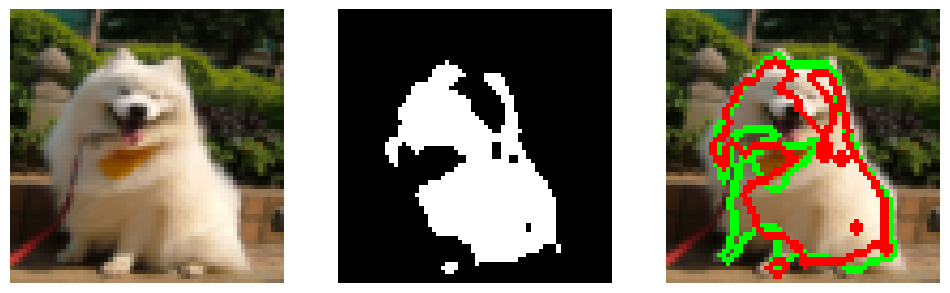

dice for samoyed-197 : 0.801
1/1 [==============================] - 0s 48ms/step
(64, 64) (64, 64)


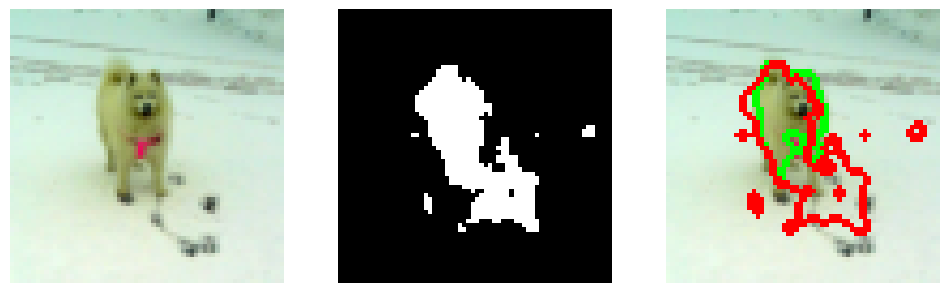

dice for samoyed-198 : 0.549
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


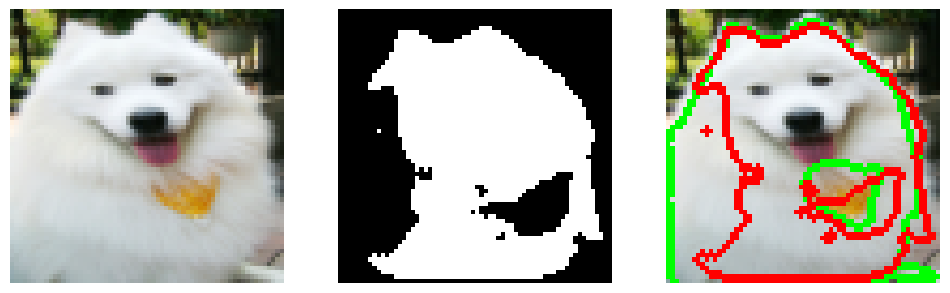

dice for samoyed-199 : 0.799
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


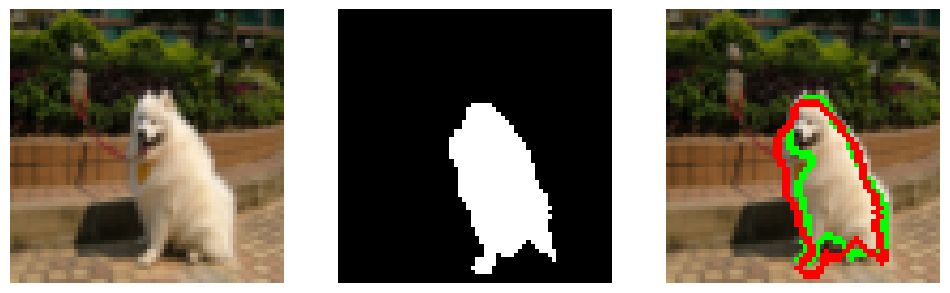

dice for samoyed-200 : 0.836
average dice: 0.736


In [25]:
model_2 = get_model_2(size_, size_)
model_2.summary()
hist_2 = model_2.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint]) # TO DO
display_history(hist_2) # TO DO
dices_2 = make_prediction(model_2, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_2))) # TO DO

**Question 9 -** Add **skip connections** (i.e. long-range shortcuts concatenating features from the encoder to the decoder) to the network implemented in question 7 using `concatenate`. Run the training, evaluate and comment on the reached segmentation accuracy (especially in comparison to `model_2`).

In [26]:
from tensorflow.keras.layers import concatenate

def get_model_3(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    up5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    conv6 = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(conv5)

    model = Model(inputs=[inputs], outputs=[conv6])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 64, 64, 32)           896       ['input_3[0][0]']             
                                                                                                  
 conv2d_17 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_16[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)           0         ['conv2d_17[0][0]']           
 g2D)                                                                                       

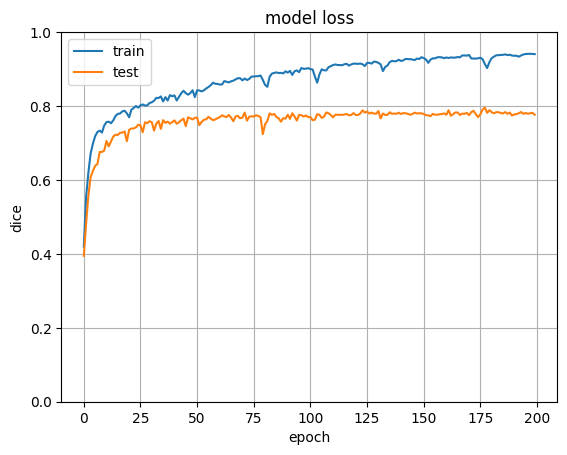

1/1 [==============================] - 0s 305ms/step
(64, 64) (64, 64)


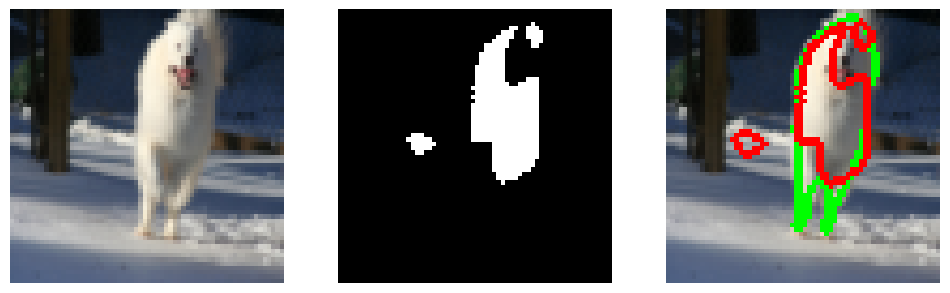

dice for samoyed-161 : 0.745
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


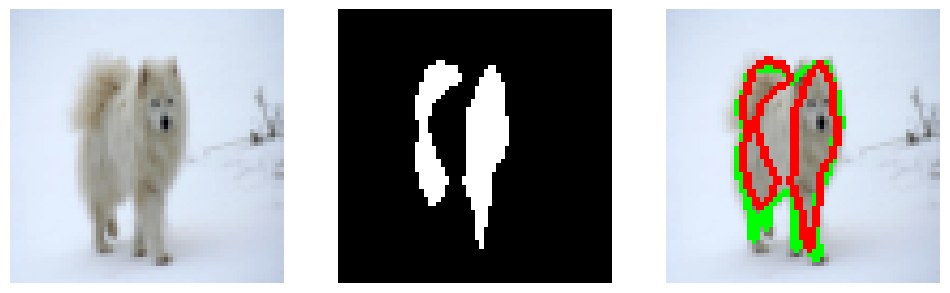

dice for samoyed-162 : 0.735
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


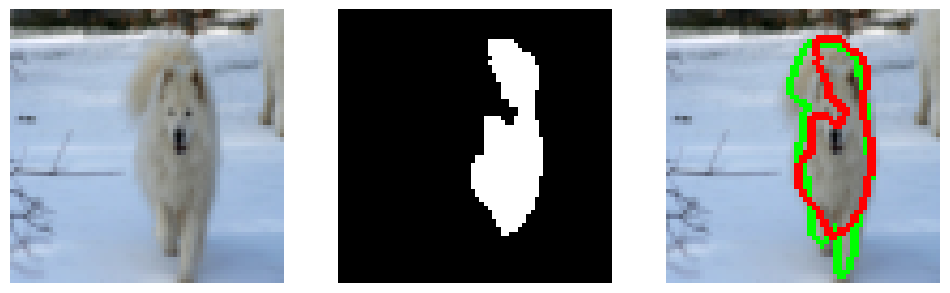

dice for samoyed-163 : 0.783
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


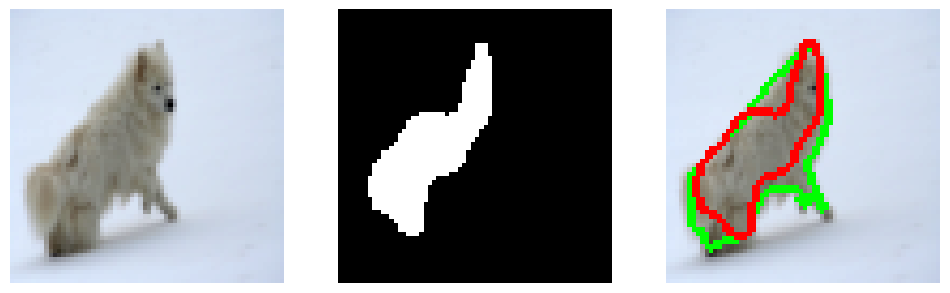

dice for samoyed-164 : 0.788
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


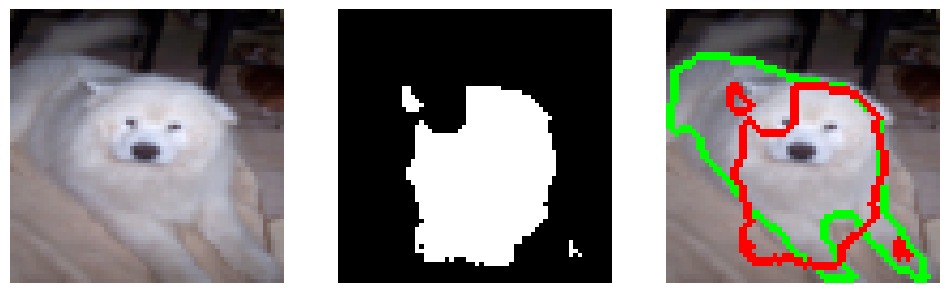

dice for samoyed-165 : 0.701
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


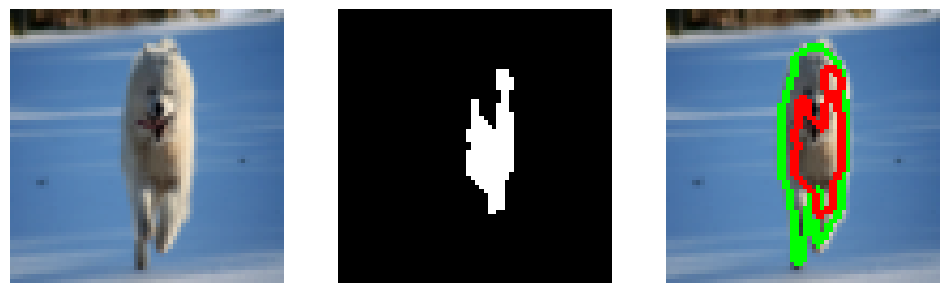

dice for samoyed-166 : 0.584
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


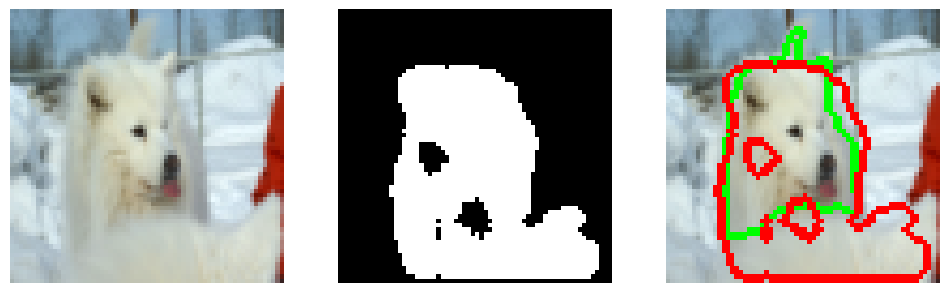

dice for samoyed-167 : 0.682
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


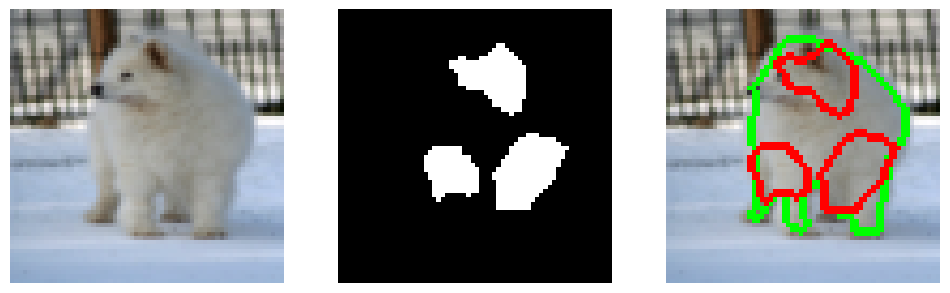

dice for samoyed-168 : 0.592
1/1 [==============================] - 0s 34ms/step
(64, 64) (64, 64)


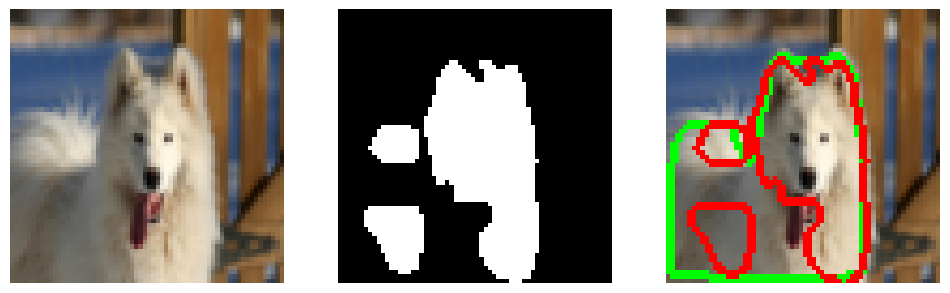

dice for samoyed-169 : 0.739
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


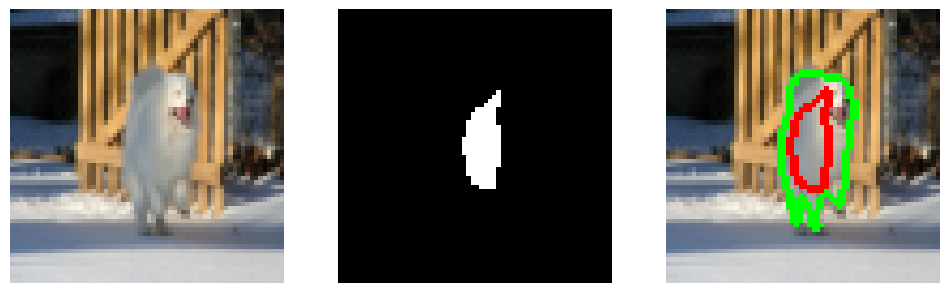

dice for samoyed-170 : 0.504
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


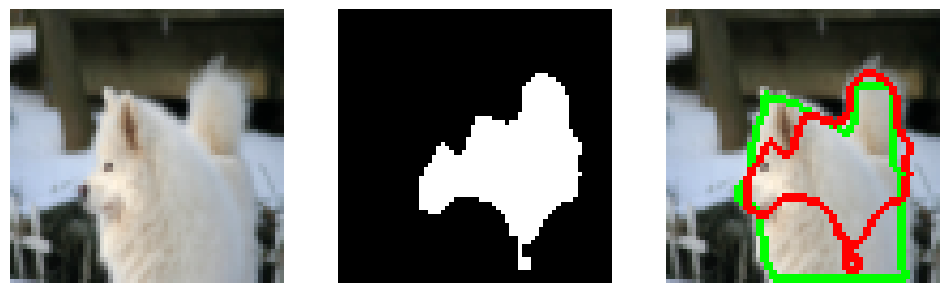

dice for samoyed-171 : 0.682
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


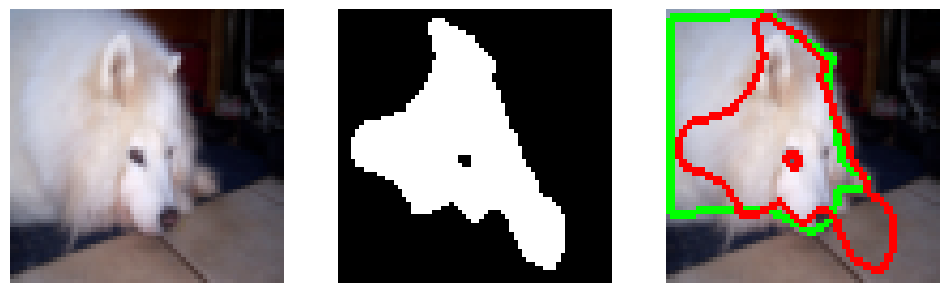

dice for samoyed-172 : 0.699
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


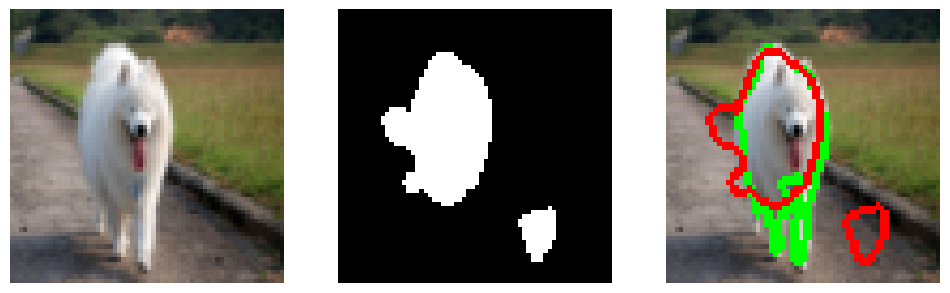

dice for samoyed-173 : 0.772
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


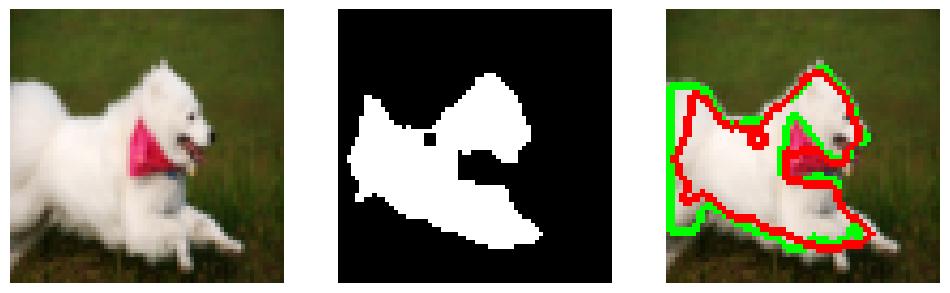

dice for samoyed-174 : 0.844
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


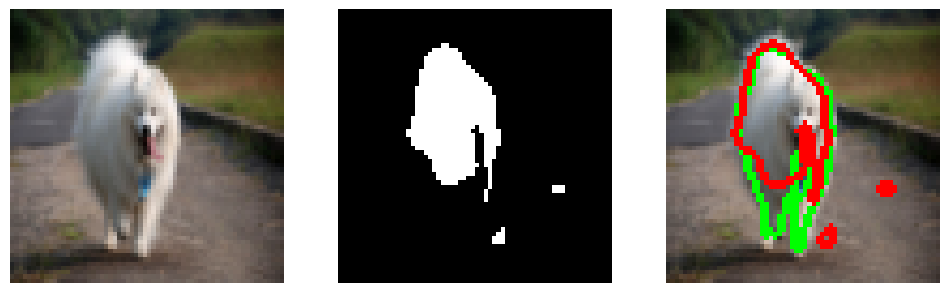

dice for samoyed-175 : 0.798
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


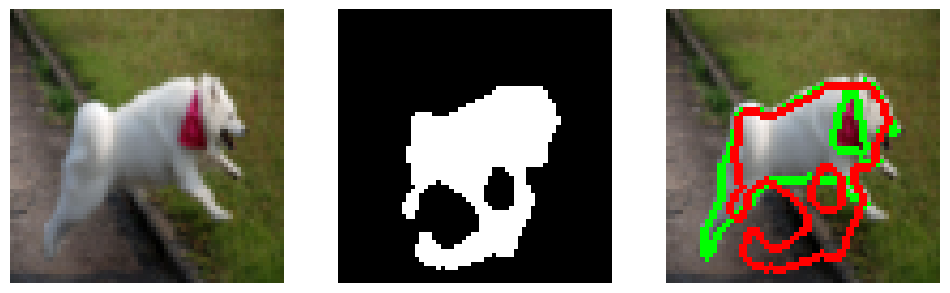

dice for samoyed-176 : 0.699
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


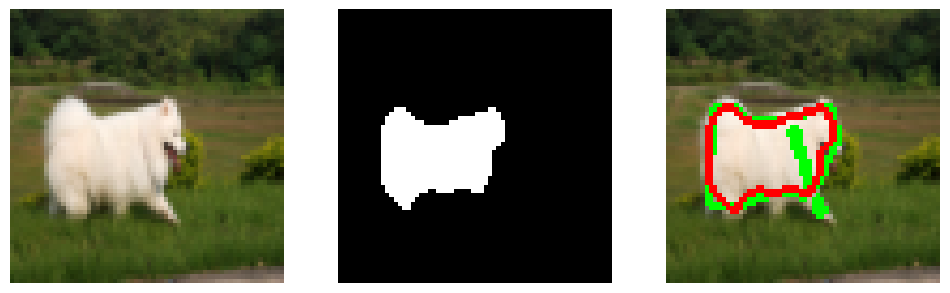

dice for samoyed-177 : 0.903
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


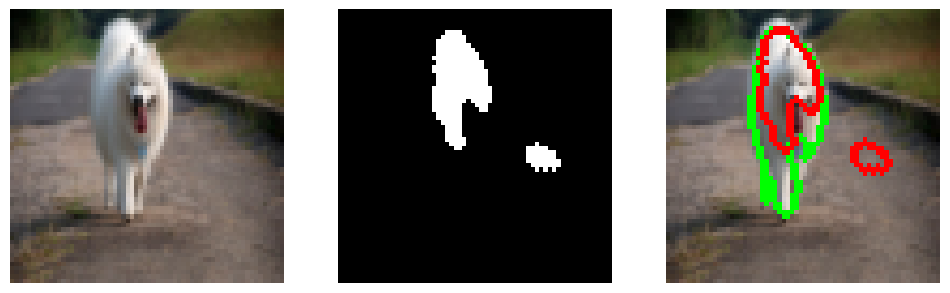

dice for samoyed-178 : 0.642
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


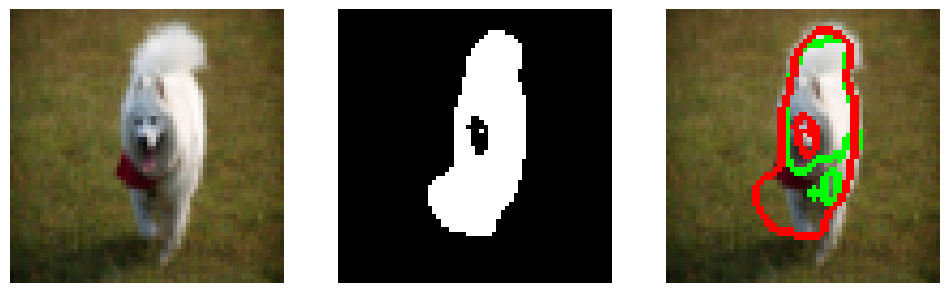

dice for samoyed-179 : 0.685
1/1 [==============================] - 0s 35ms/step
(64, 64) (64, 64)


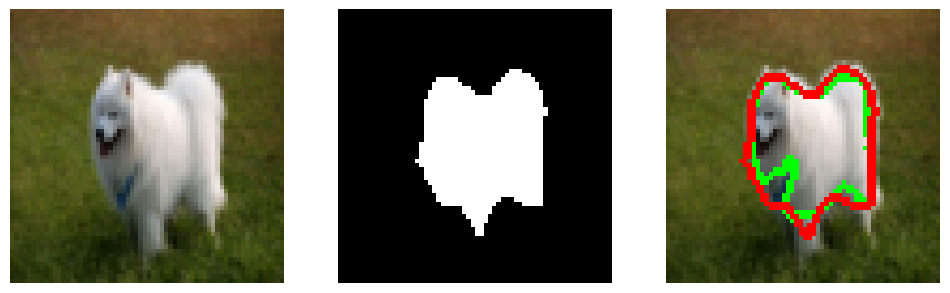

dice for samoyed-180 : 0.904
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


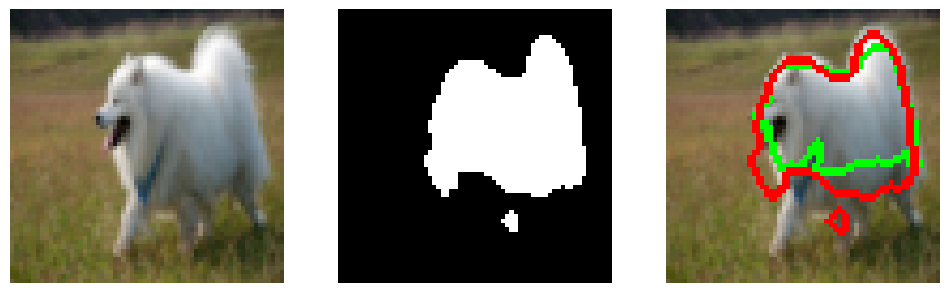

dice for samoyed-181 : 0.834
1/1 [==============================] - 0s 37ms/step
(64, 64) (64, 64)


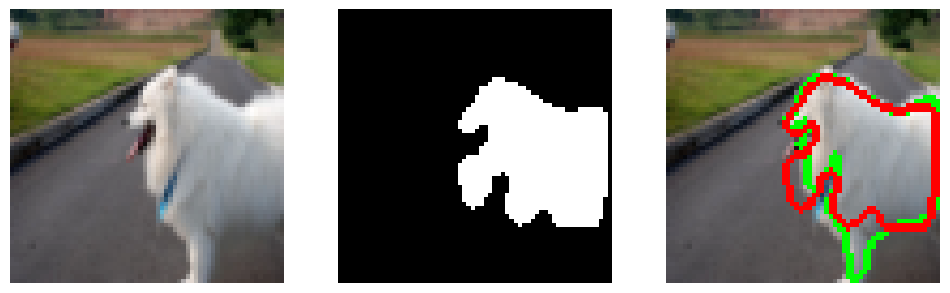

dice for samoyed-182 : 0.882
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


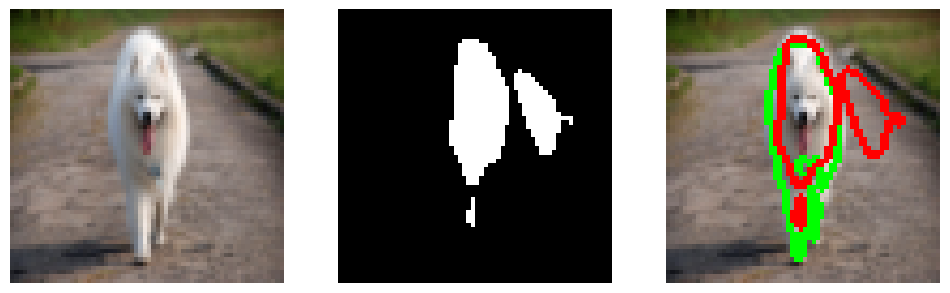

dice for samoyed-183 : 0.678
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


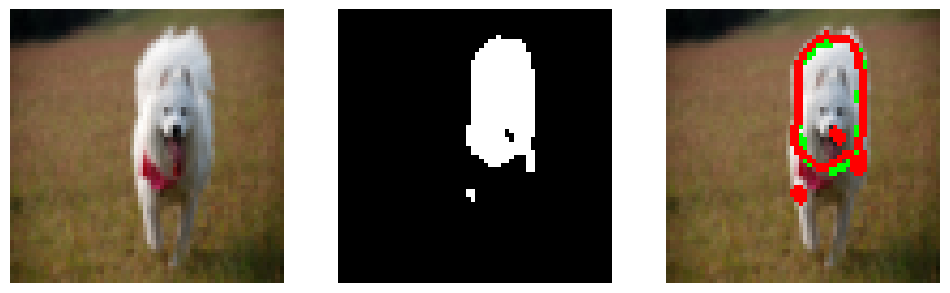

dice for samoyed-184 : 0.927
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


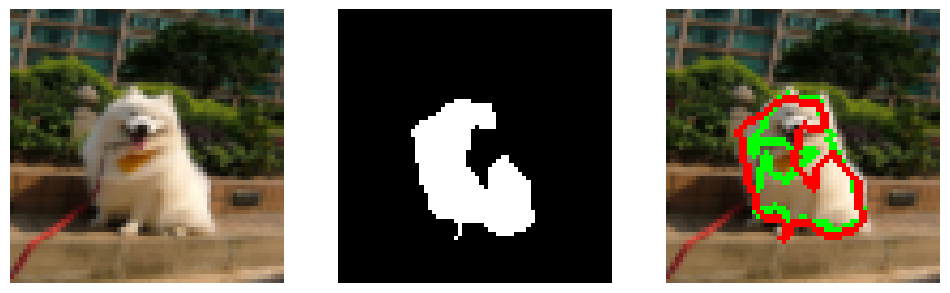

dice for samoyed-185 : 0.771
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


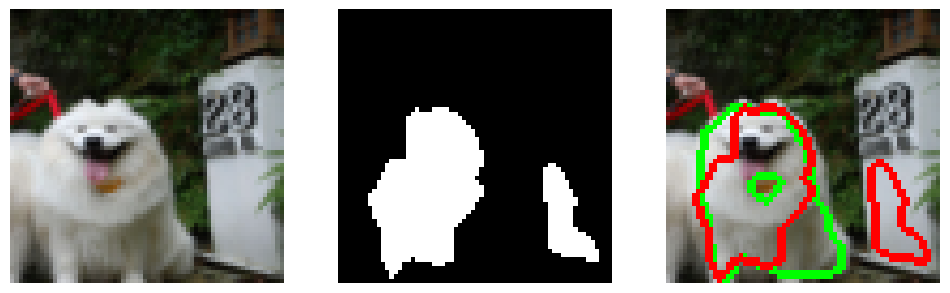

dice for samoyed-186 : 0.712
1/1 [==============================] - 0s 24ms/step
(64, 64) (64, 64)


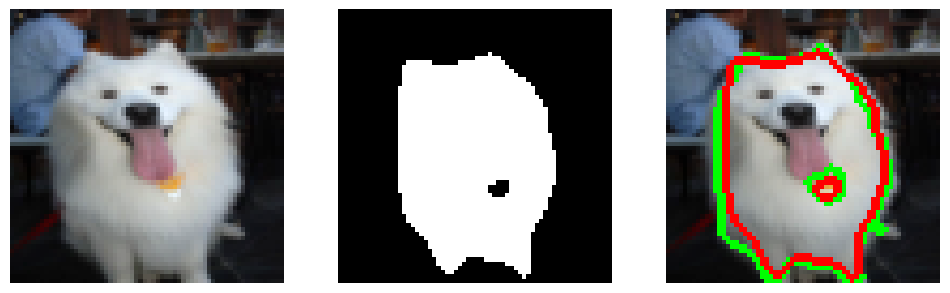

dice for samoyed-187 : 0.928
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


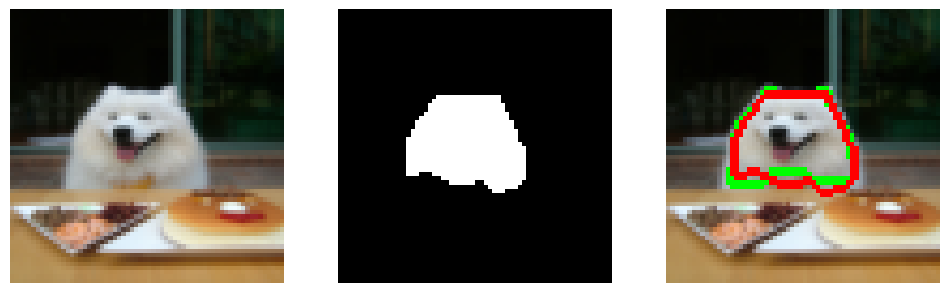

dice for samoyed-188 : 0.914
1/1 [==============================] - 0s 35ms/step
(64, 64) (64, 64)


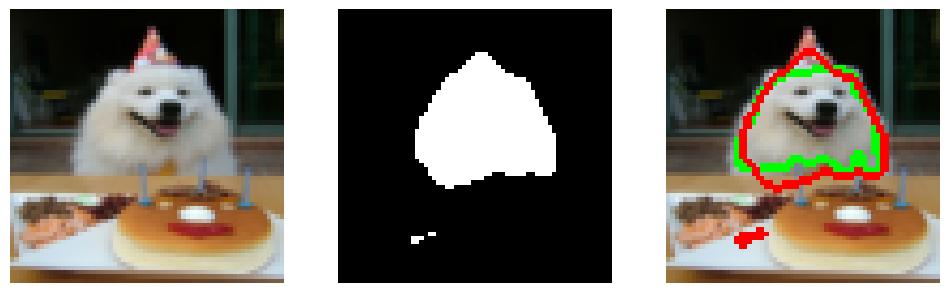

dice for samoyed-189 : 0.866
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


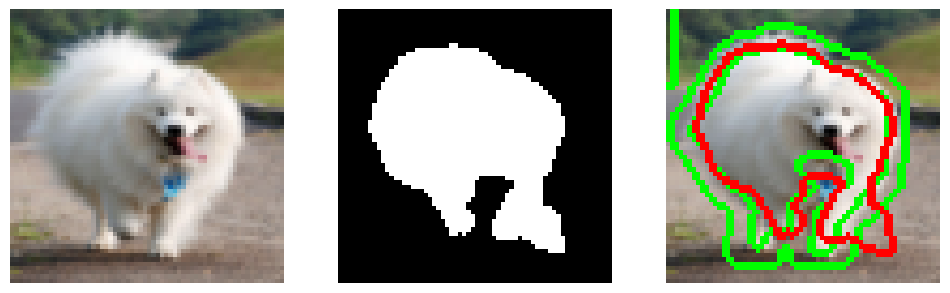

dice for samoyed-190 : 0.559
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


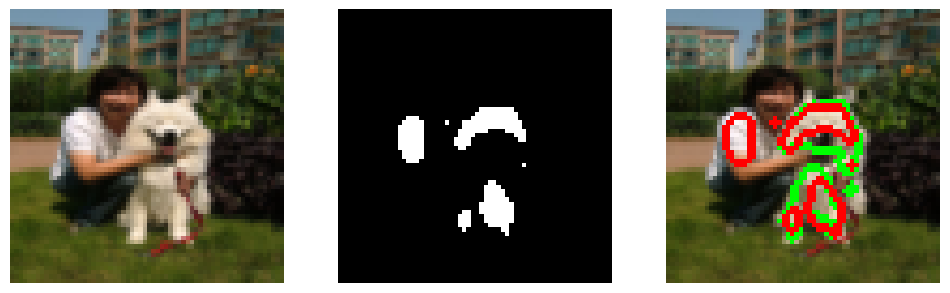

dice for samoyed-191 : 0.591
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


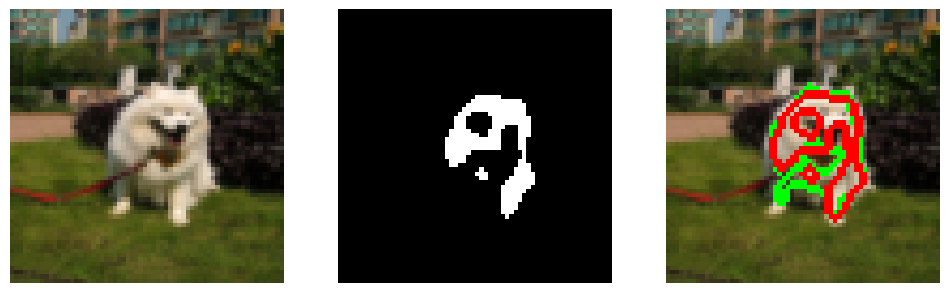

dice for samoyed-192 : 0.740
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


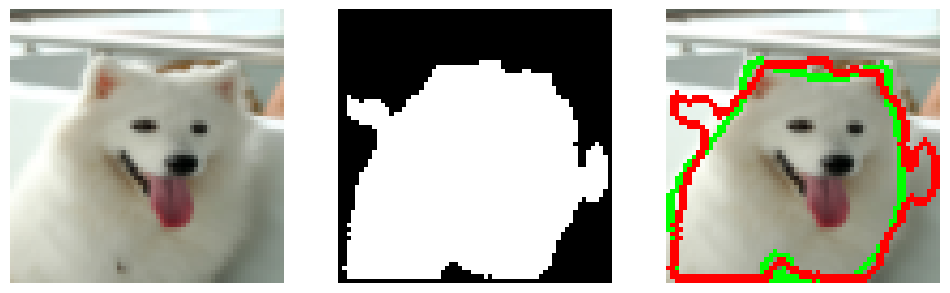

dice for samoyed-193 : 0.922
1/1 [==============================] - 0s 22ms/step
(64, 64) (64, 64)


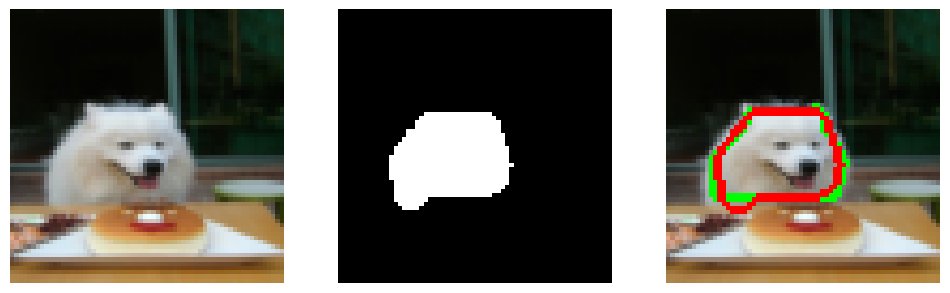

dice for samoyed-194 : 0.938
1/1 [==============================] - 0s 39ms/step
(64, 64) (64, 64)


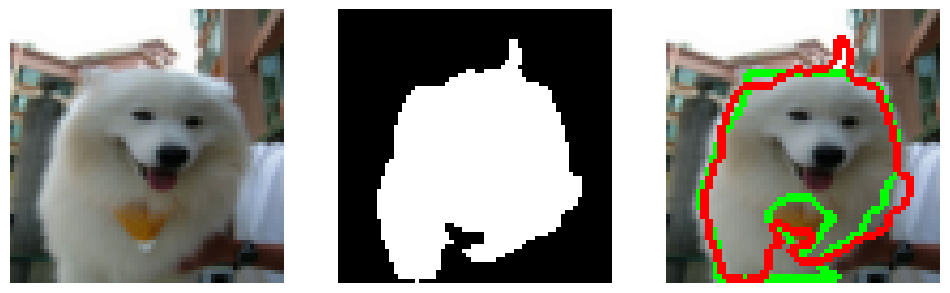

dice for samoyed-195 : 0.883
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


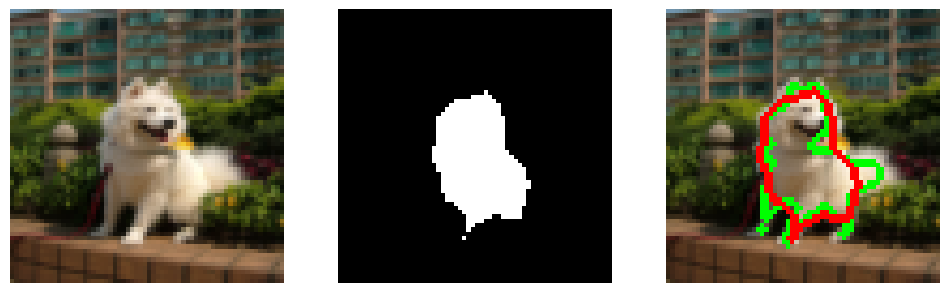

dice for samoyed-196 : 0.859
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


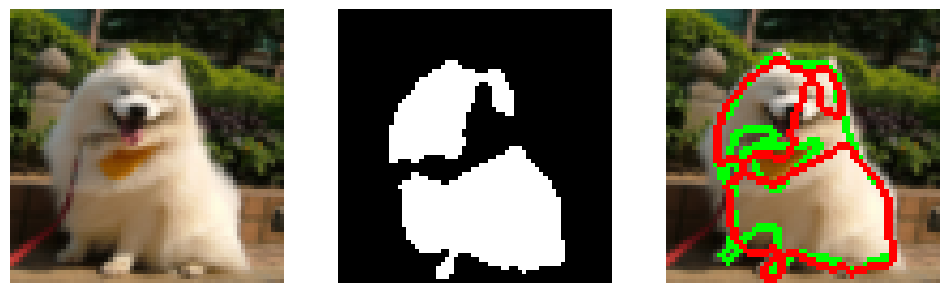

dice for samoyed-197 : 0.848
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


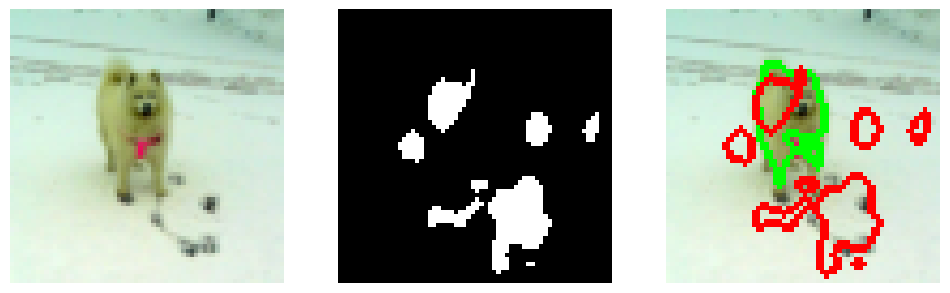

dice for samoyed-198 : 0.241
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


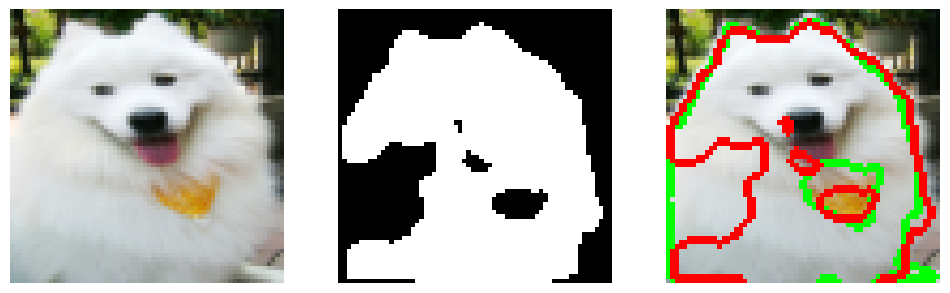

dice for samoyed-199 : 0.866
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


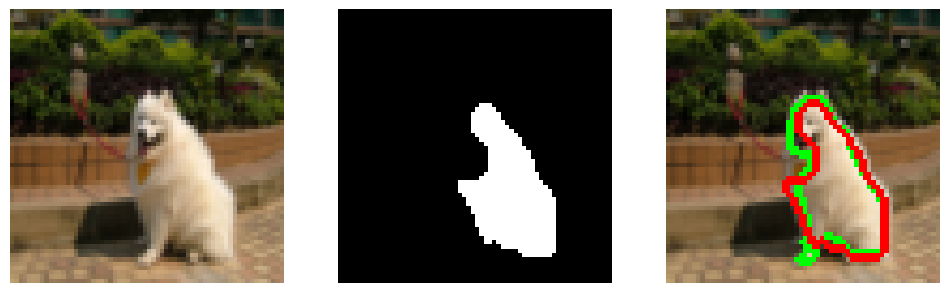

dice for samoyed-200 : 0.888
average dice: 0.758


In [27]:
model_3 = get_model_3(size_, size_)
model_3.summary()
hist_3 = model_3.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint]) # TO DO
display_history(hist_3) # TO DO
dices_3 = make_prediction(model_3, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_3))) # TO DO

**Question 10 -** The two following deep models (`model_4` and `model_5`) use the `VGG16` classification network without (`model_4`) and with (`model_5`) **pre-training** on the `ImageNet` dataset. Run the training for both networks (100 epochs for `model_4`, 50 for `model_5`) and (as previously) evaluate them.

In [28]:
def get_model_4(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 64, 64, 64)           1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_26[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_27[0][0]']           
 g2D)                                                                                       

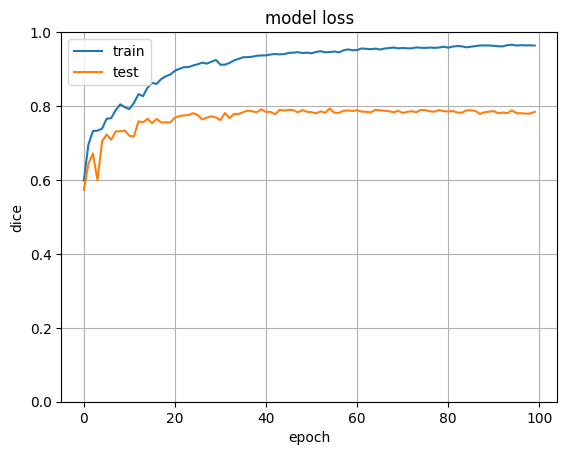

1/1 [==============================] - 1s 1s/step
(64, 64) (64, 64)


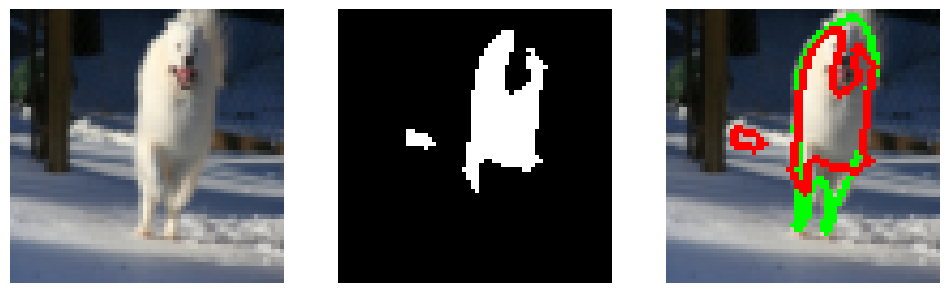

dice for samoyed-161 : 0.761
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


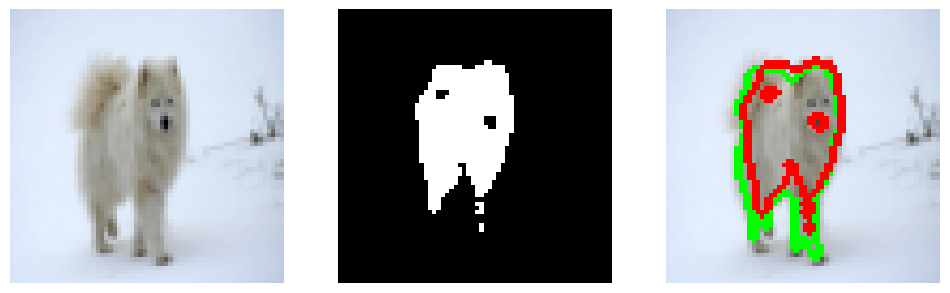

dice for samoyed-162 : 0.839
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


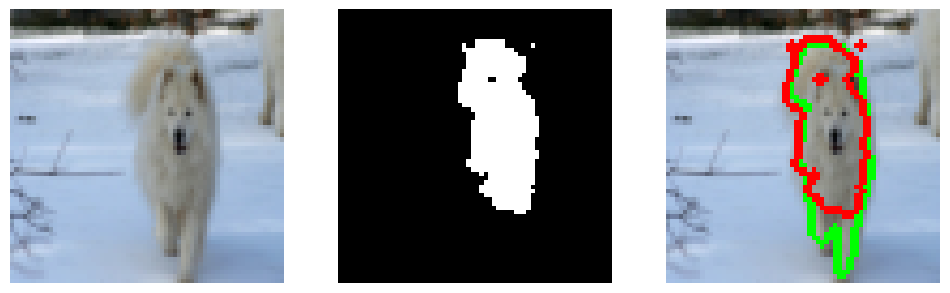

dice for samoyed-163 : 0.837
1/1 [==============================] - 0s 34ms/step
(64, 64) (64, 64)


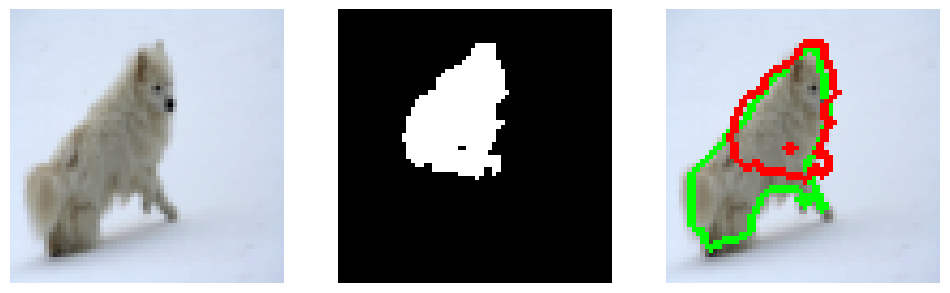

dice for samoyed-164 : 0.659
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


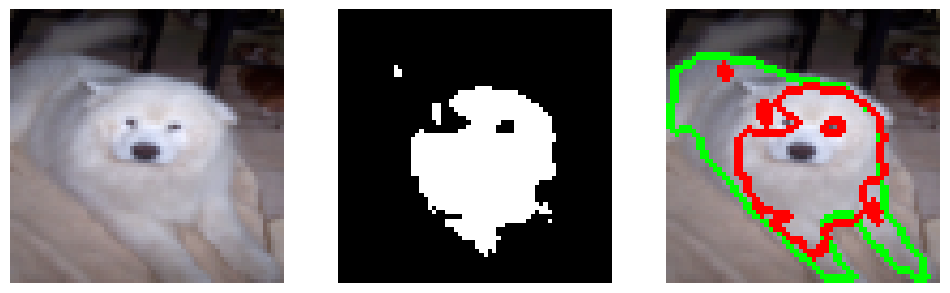

dice for samoyed-165 : 0.683
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


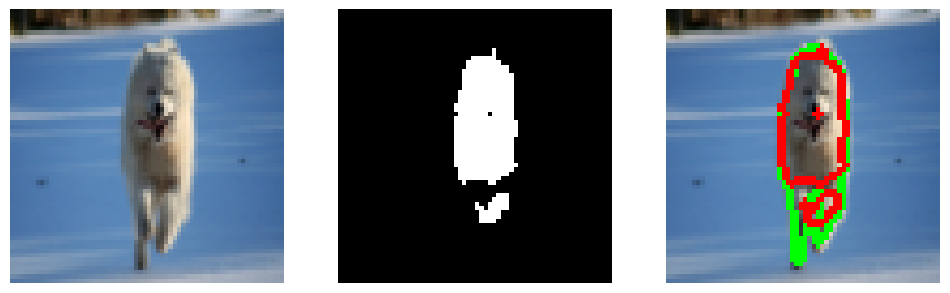

dice for samoyed-166 : 0.839
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


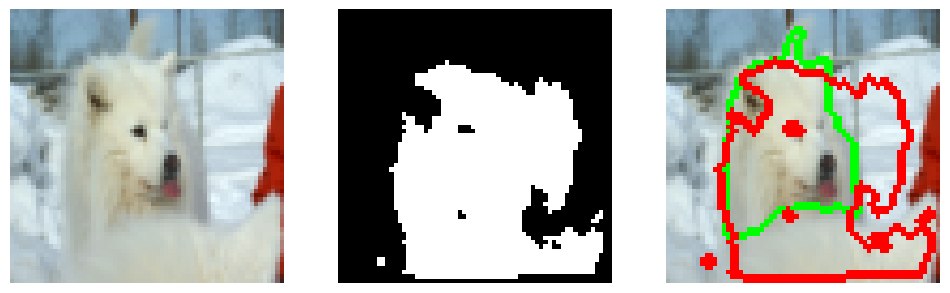

dice for samoyed-167 : 0.614
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


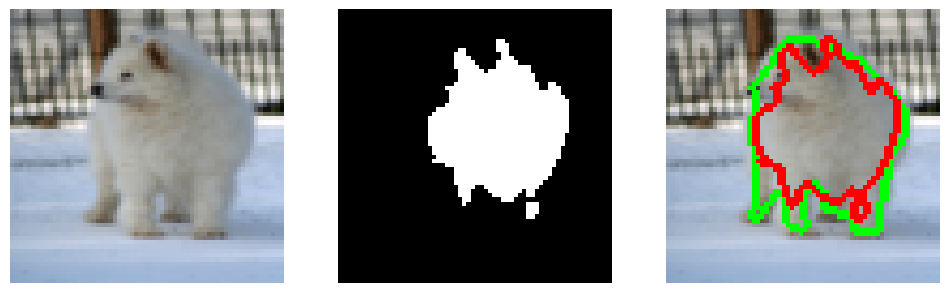

dice for samoyed-168 : 0.820
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


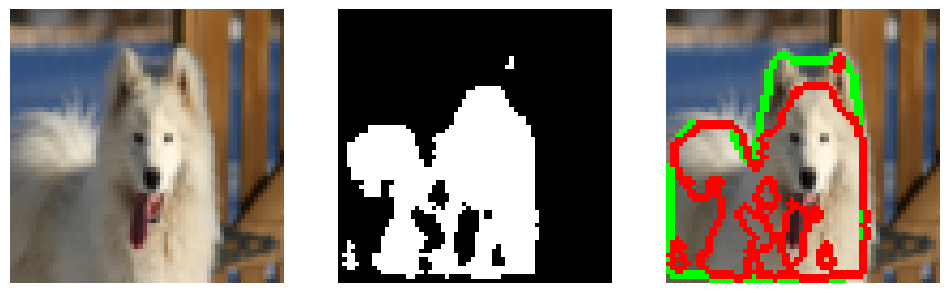

dice for samoyed-169 : 0.803
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


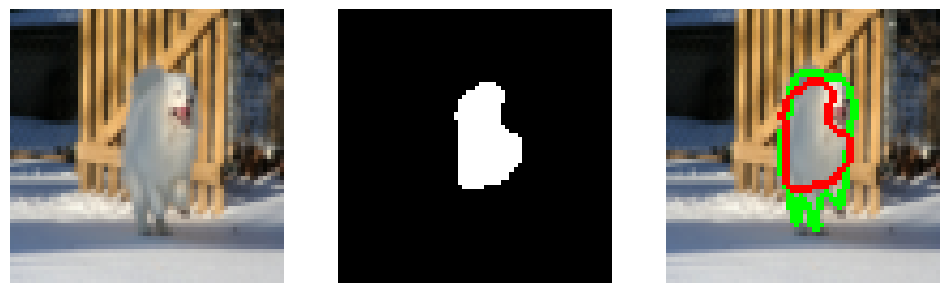

dice for samoyed-170 : 0.762
1/1 [==============================] - 0s 35ms/step
(64, 64) (64, 64)


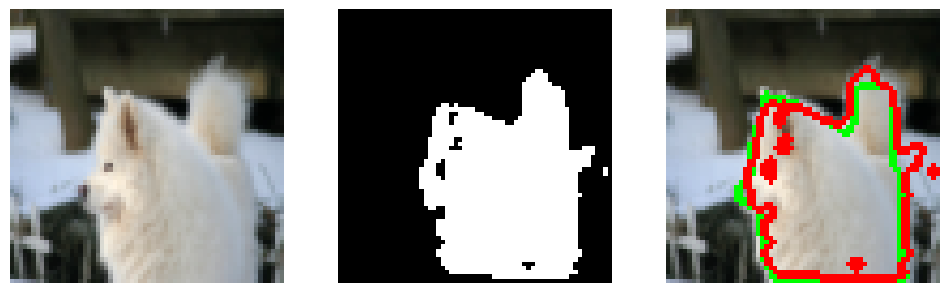

dice for samoyed-171 : 0.929
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


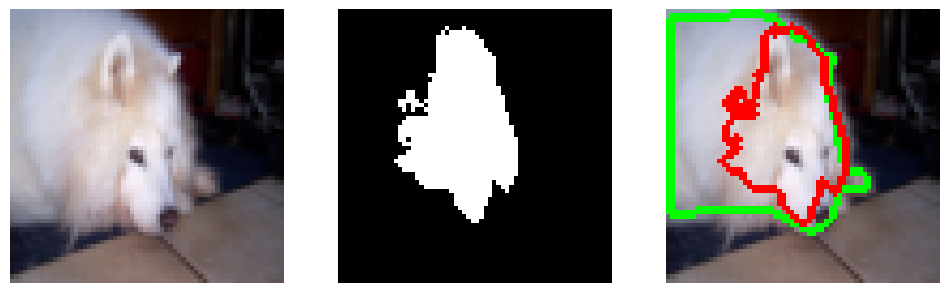

dice for samoyed-172 : 0.610
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


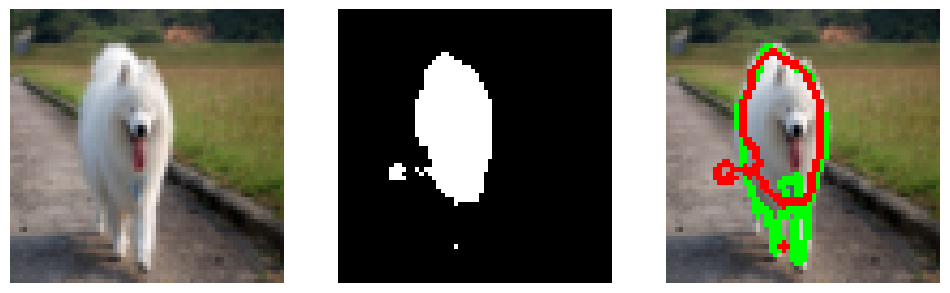

dice for samoyed-173 : 0.829
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


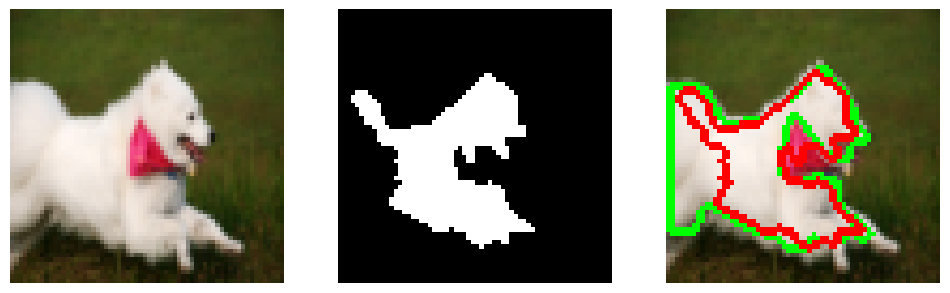

dice for samoyed-174 : 0.752
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


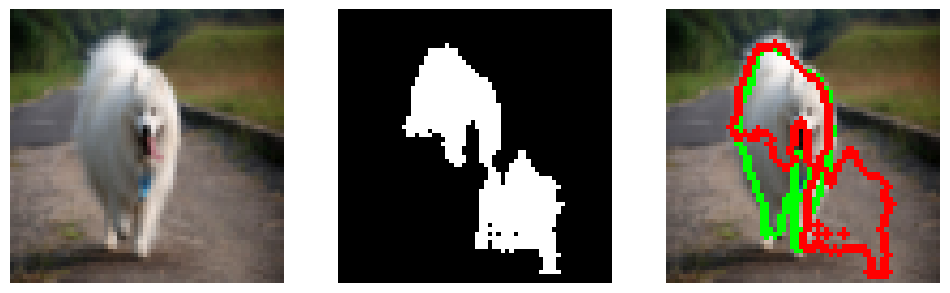

dice for samoyed-175 : 0.571
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


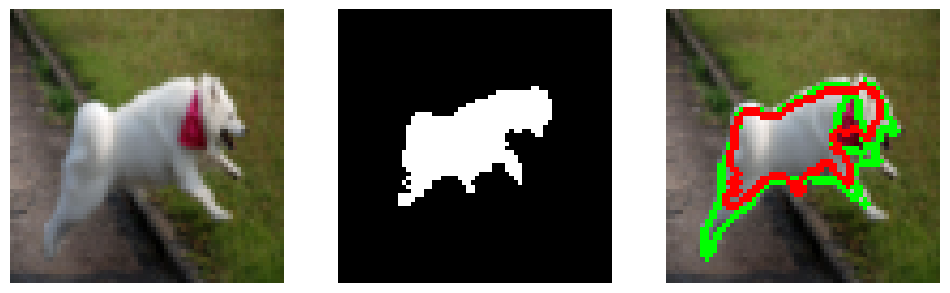

dice for samoyed-176 : 0.795
1/1 [==============================] - 0s 34ms/step
(64, 64) (64, 64)


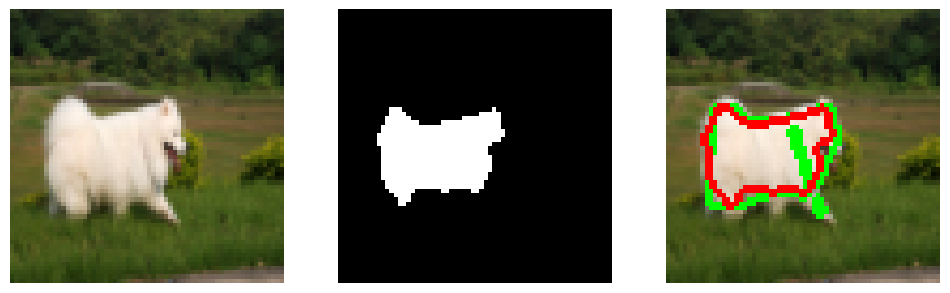

dice for samoyed-177 : 0.875
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


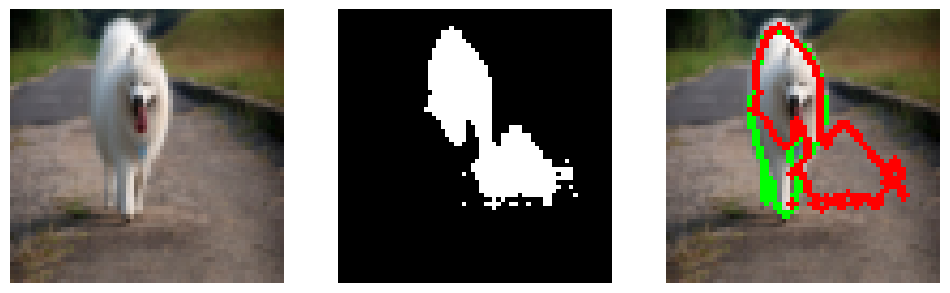

dice for samoyed-178 : 0.598
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


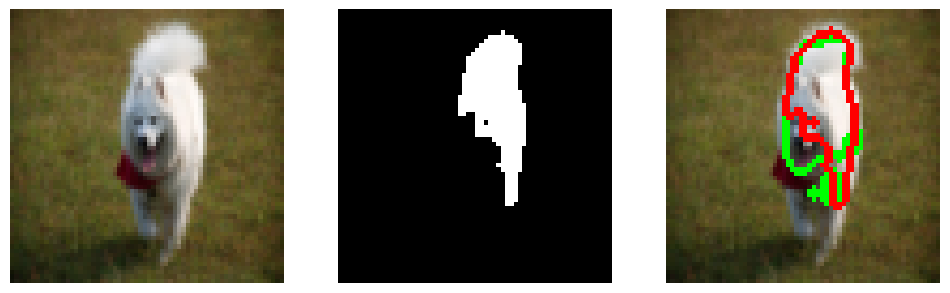

dice for samoyed-179 : 0.793
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


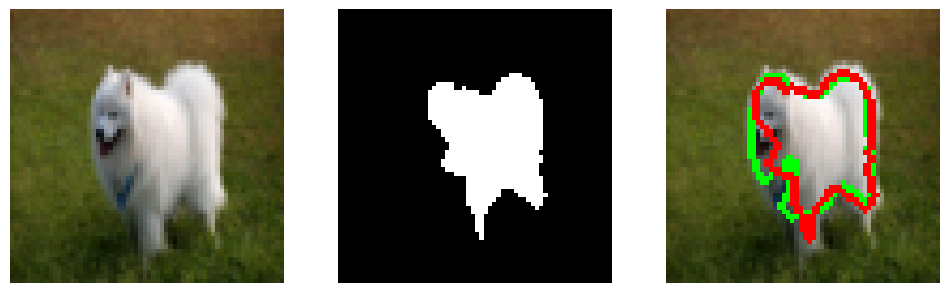

dice for samoyed-180 : 0.888
1/1 [==============================] - 0s 46ms/step
(64, 64) (64, 64)


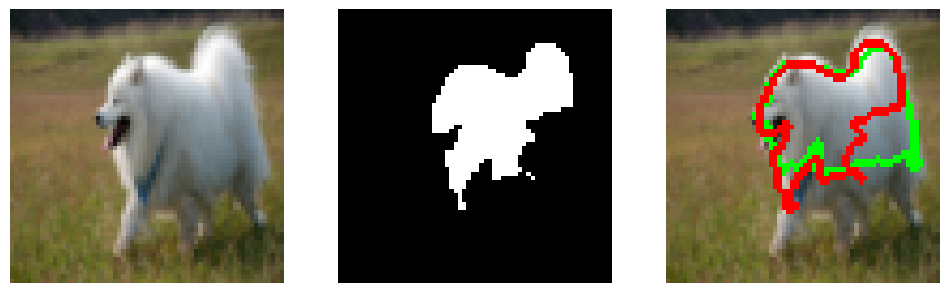

dice for samoyed-181 : 0.803
1/1 [==============================] - 0s 42ms/step
(64, 64) (64, 64)


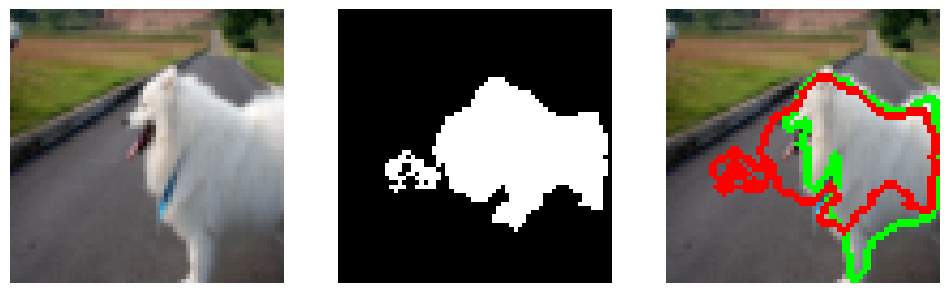

dice for samoyed-182 : 0.747
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


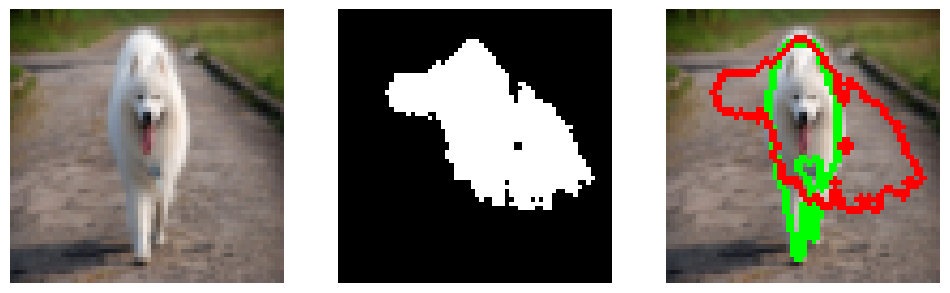

dice for samoyed-183 : 0.558
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


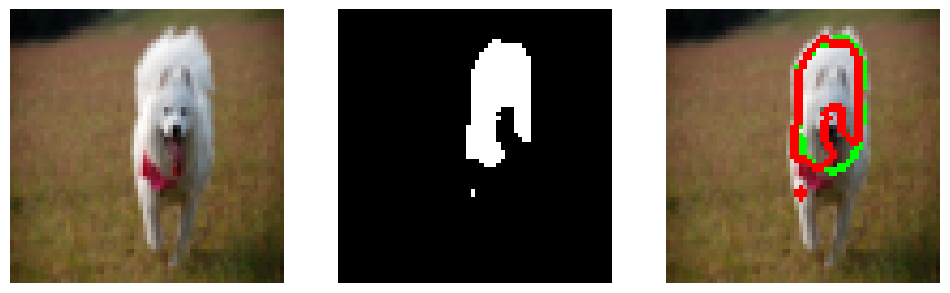

dice for samoyed-184 : 0.850
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


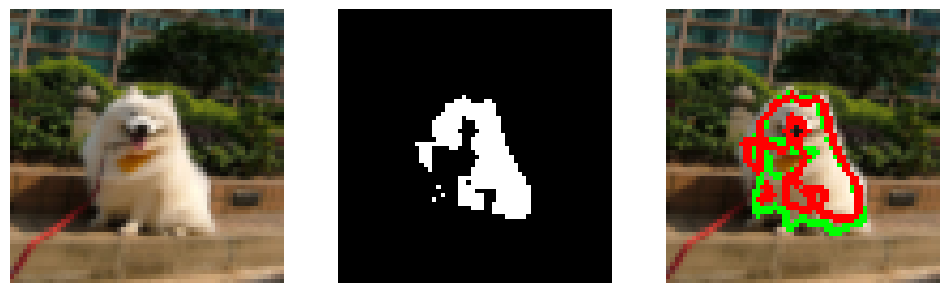

dice for samoyed-185 : 0.758
1/1 [==============================] - 0s 37ms/step
(64, 64) (64, 64)


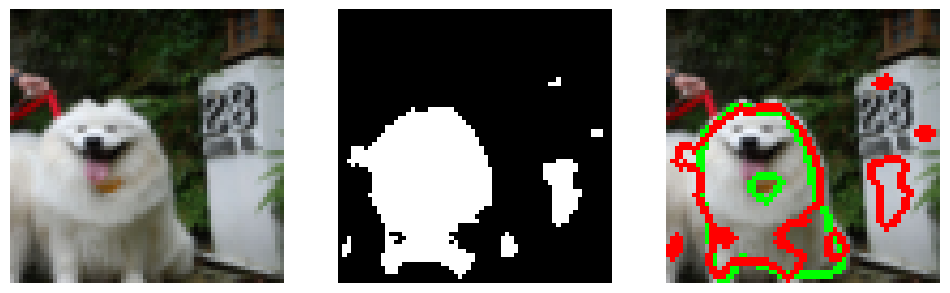

dice for samoyed-186 : 0.797
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


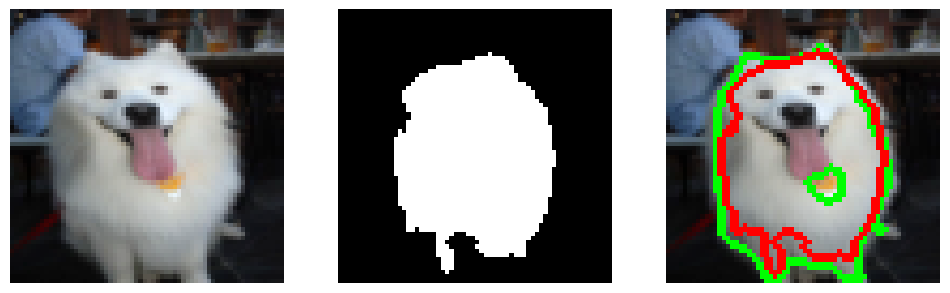

dice for samoyed-187 : 0.884
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


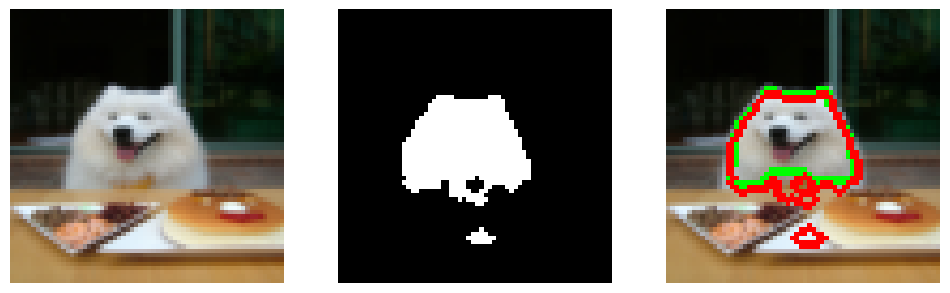

dice for samoyed-188 : 0.875
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


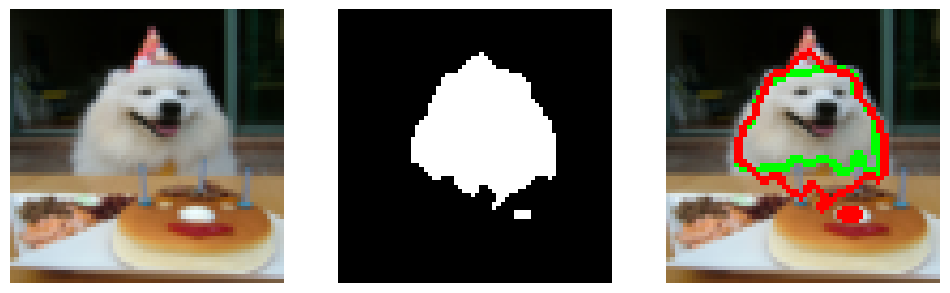

dice for samoyed-189 : 0.845
1/1 [==============================] - 0s 39ms/step
(64, 64) (64, 64)


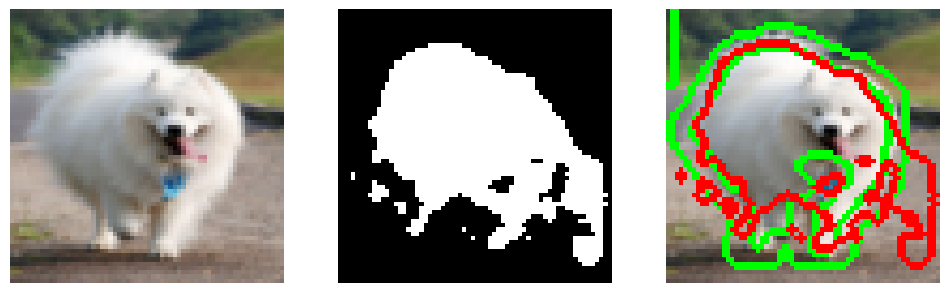

dice for samoyed-190 : 0.580
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


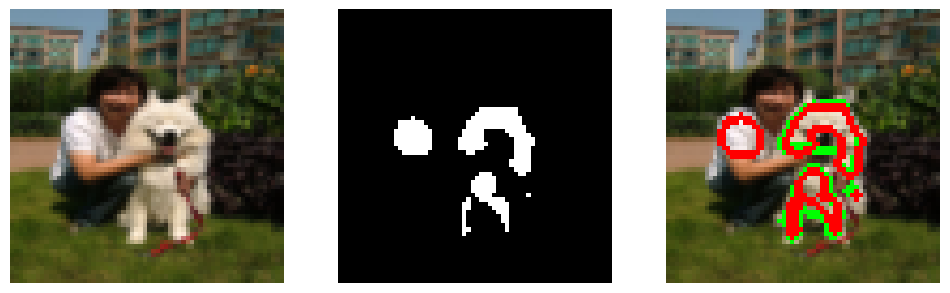

dice for samoyed-191 : 0.670
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


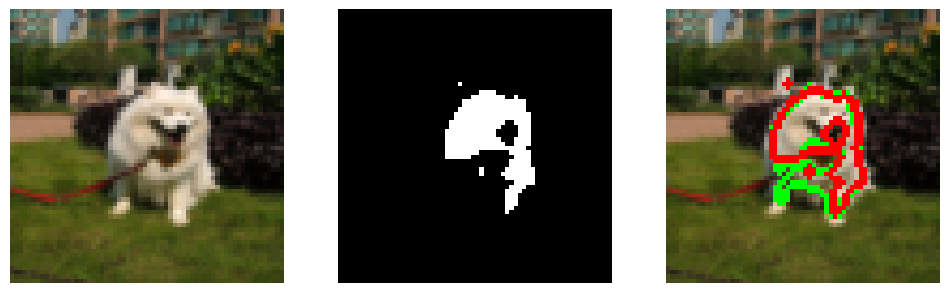

dice for samoyed-192 : 0.802
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


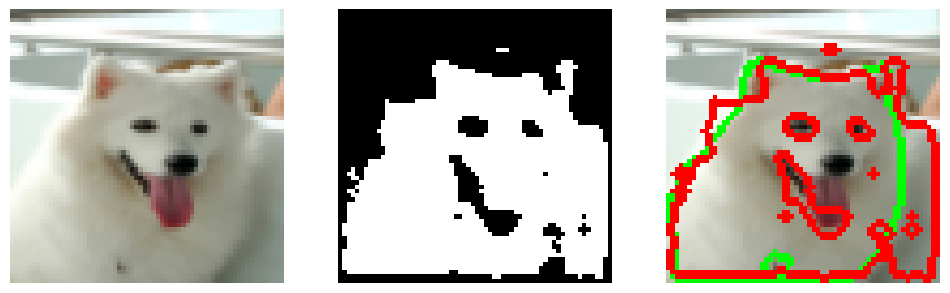

dice for samoyed-193 : 0.839
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


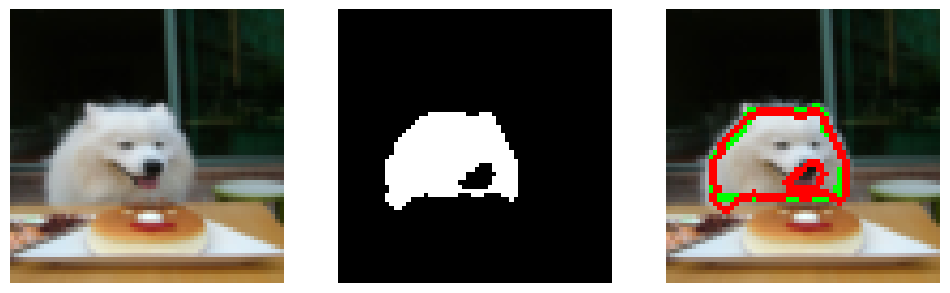

dice for samoyed-194 : 0.911
1/1 [==============================] - 0s 26ms/step
(64, 64) (64, 64)


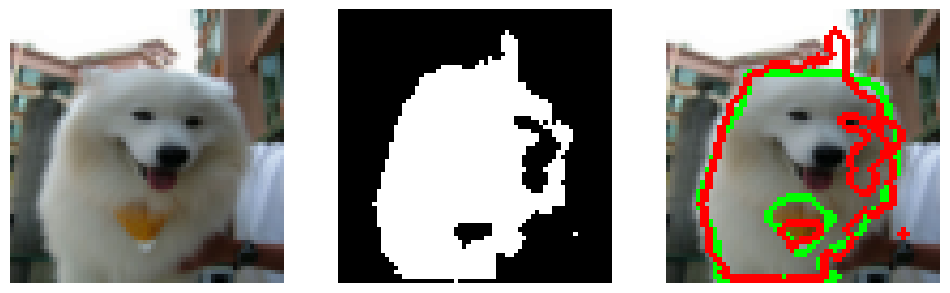

dice for samoyed-195 : 0.879
1/1 [==============================] - 0s 38ms/step
(64, 64) (64, 64)


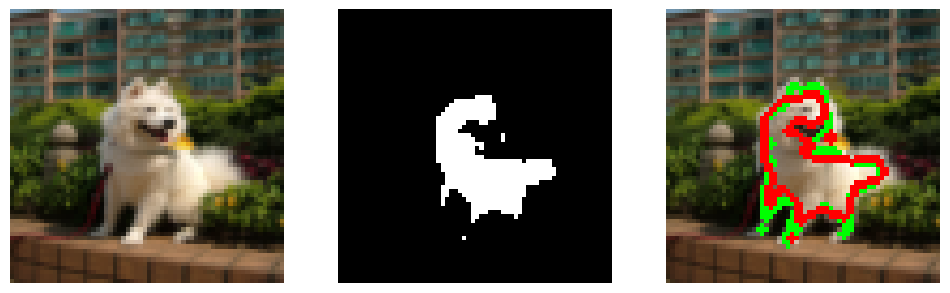

dice for samoyed-196 : 0.837
1/1 [==============================] - 0s 19ms/step
(64, 64) (64, 64)


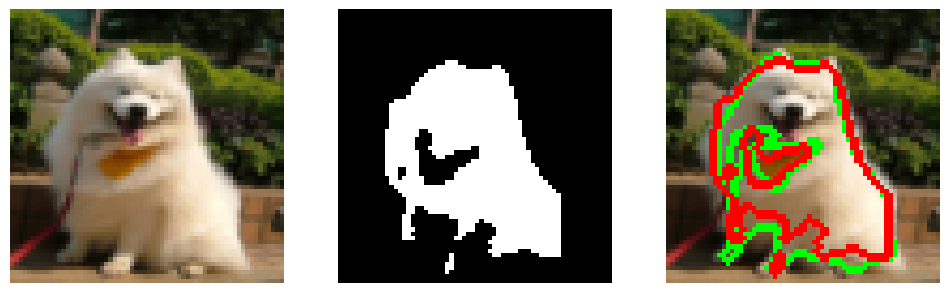

dice for samoyed-197 : 0.862
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


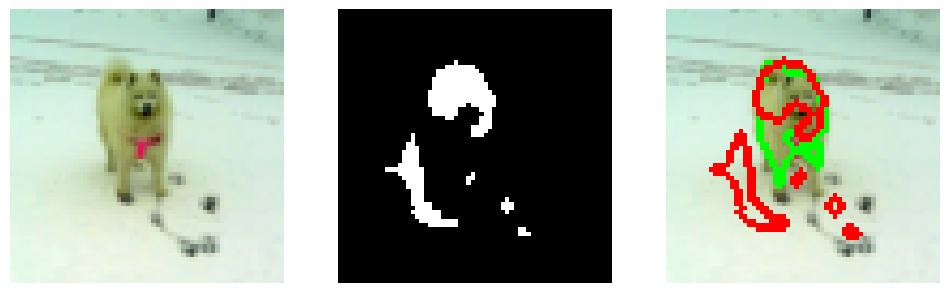

dice for samoyed-198 : 0.547
1/1 [==============================] - 0s 18ms/step
(64, 64) (64, 64)


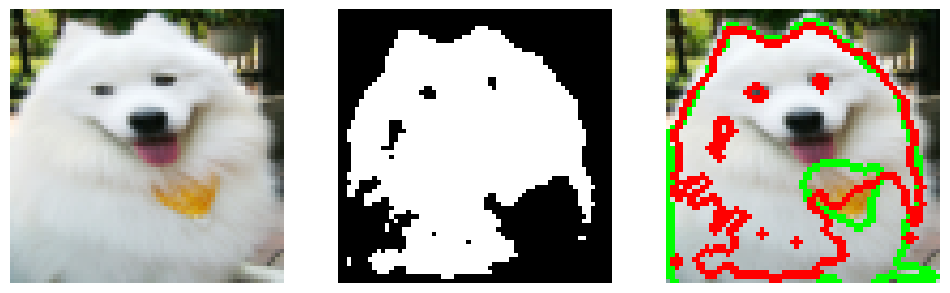

dice for samoyed-199 : 0.824
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


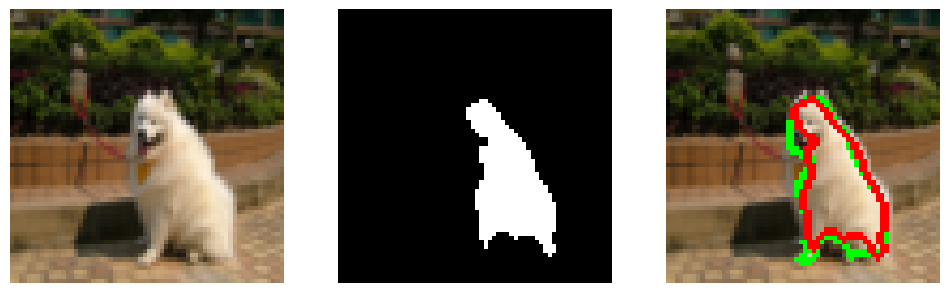

dice for samoyed-200 : 0.889
average dice: 0.775


In [29]:
epochs = 100
model_4 = get_model_4(size_, size_)
model_4.summary()
hist_4 = model_4.fit (train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint]) # TO DO
display_history(hist_4) # TO DO
dices_4 = make_prediction(model_4, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_4))) # TO DO

The `vgg16_model` typically refers to a pre-trained deep learning model based on the VGG16 architecture. VGG16 is a convolutional neural network (CNN) architecture that was proposed by the Visual Graphics Group (VGG)

In [30]:
from tensorflow.keras.applications import vgg16

def get_model_5(img_rows, img_cols):

    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(vgg16_model.get_layer('block5_conv3').output), vgg16_model.get_layer('block4_conv3').output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), vgg16_model.get_layer('block3_conv3').output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), vgg16_model.get_layer('block2_conv2').output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), vgg16_model.get_layer('block1_conv2').output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 64, 64, 64)           1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 64, 64, 64)           36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)           0         ['block1_conv2[0][0]']        
                           

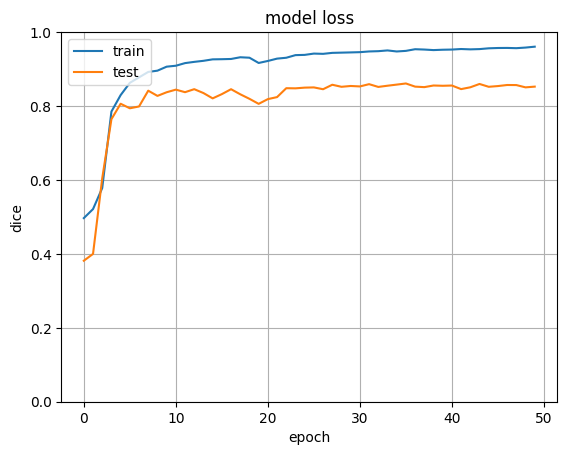

1/1 [==============================] - 0s 274ms/step
(64, 64) (64, 64)


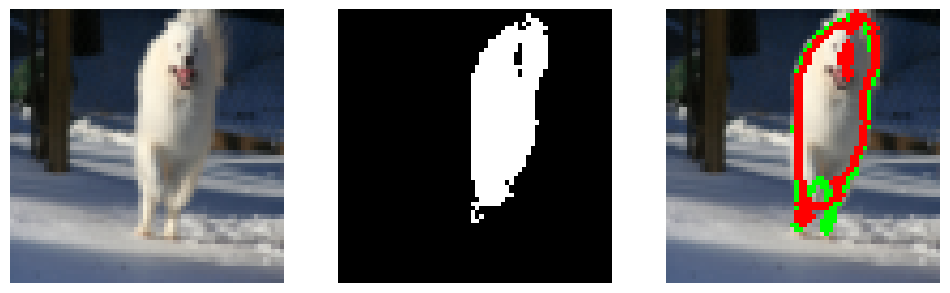

dice for samoyed-161 : 0.905
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


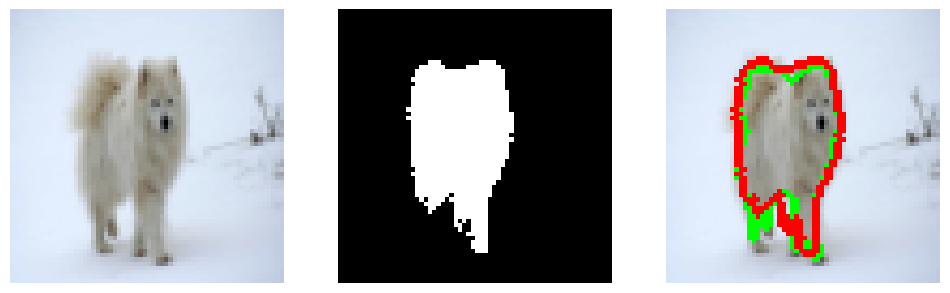

dice for samoyed-162 : 0.918
1/1 [==============================] - 0s 77ms/step
(64, 64) (64, 64)


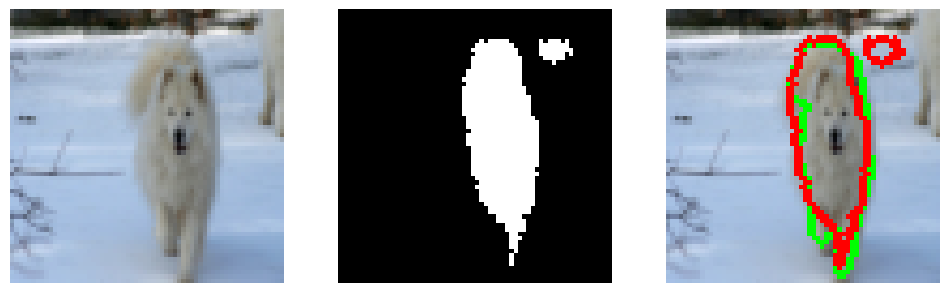

dice for samoyed-163 : 0.870
1/1 [==============================] - 0s 76ms/step
(64, 64) (64, 64)


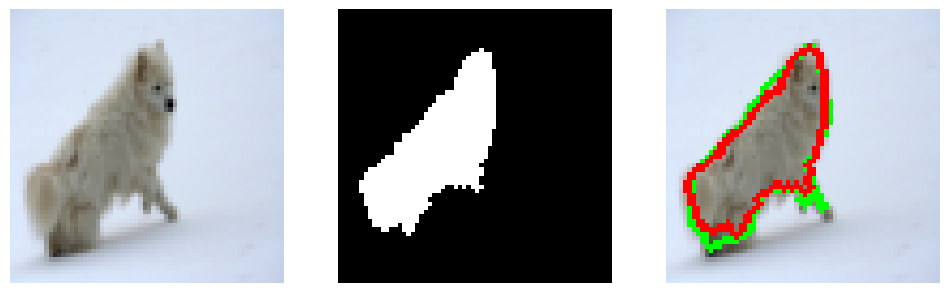

dice for samoyed-164 : 0.920
1/1 [==============================] - 0s 50ms/step
(64, 64) (64, 64)


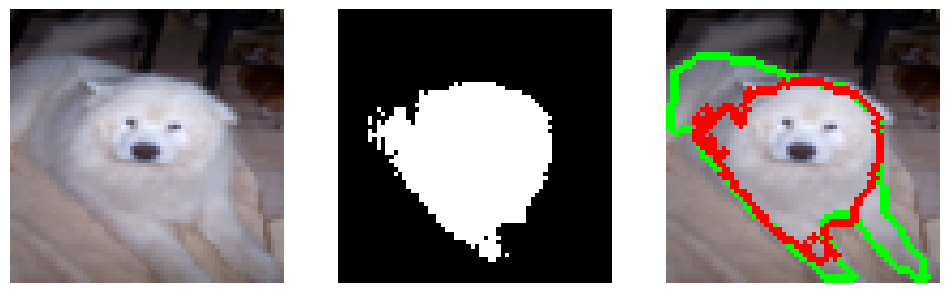

dice for samoyed-165 : 0.795
1/1 [==============================] - 0s 58ms/step
(64, 64) (64, 64)


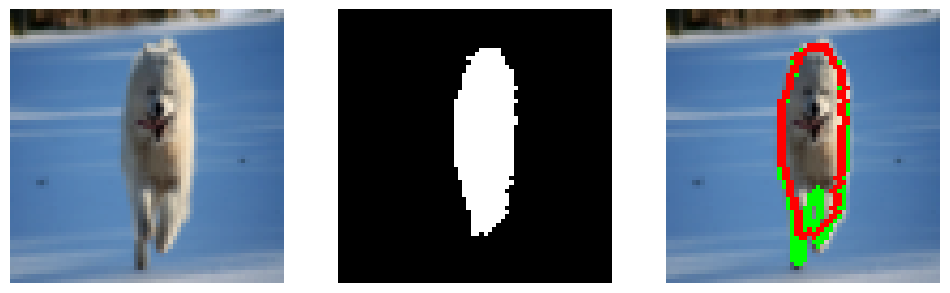

dice for samoyed-166 : 0.914
1/1 [==============================] - 0s 102ms/step
(64, 64) (64, 64)


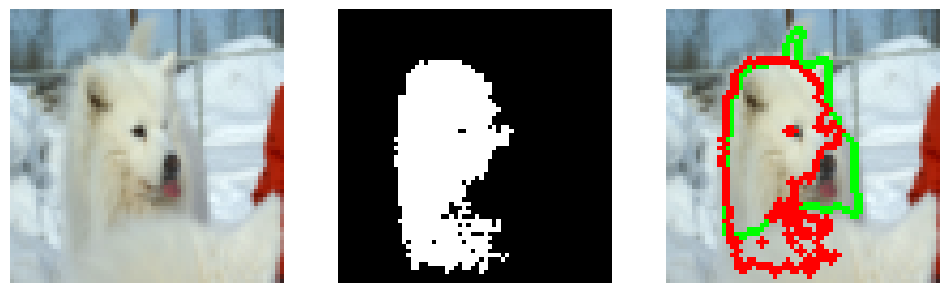

dice for samoyed-167 : 0.746
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


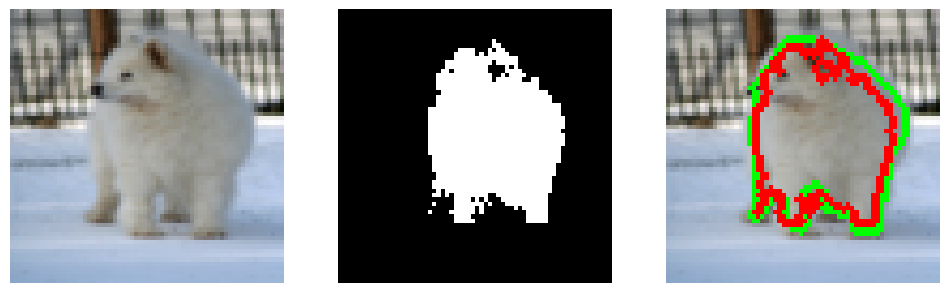

dice for samoyed-168 : 0.882
1/1 [==============================] - 0s 38ms/step
(64, 64) (64, 64)


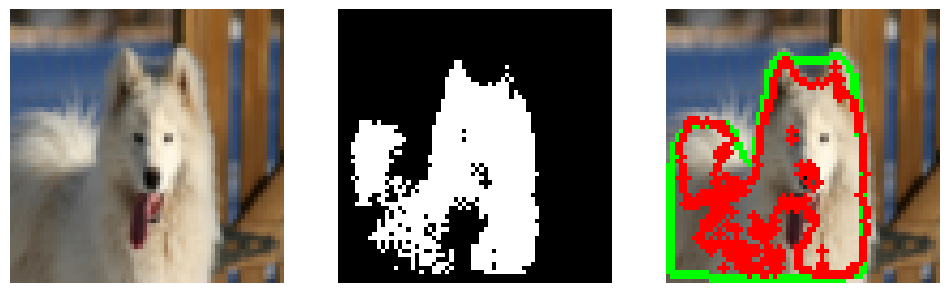

dice for samoyed-169 : 0.790
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


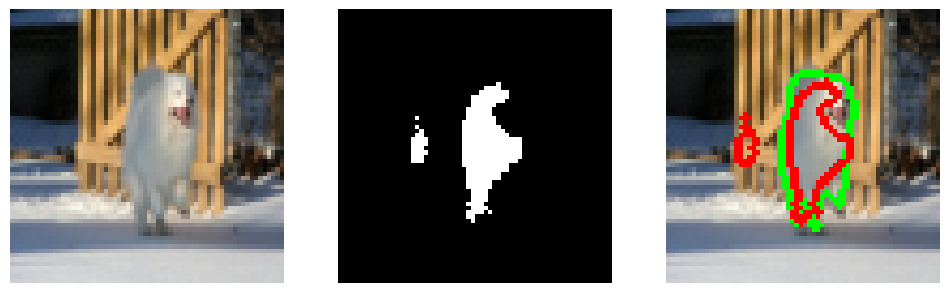

dice for samoyed-170 : 0.667
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


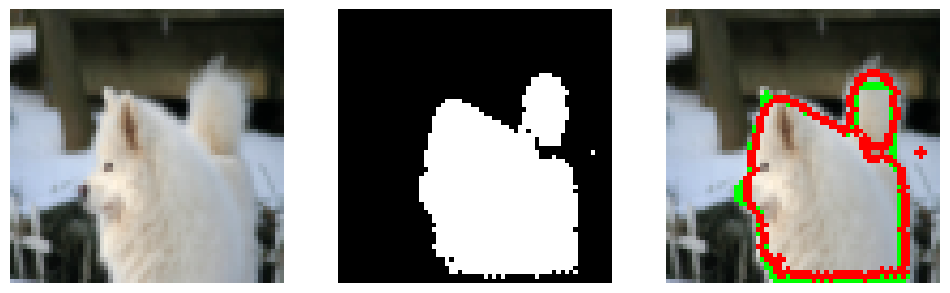

dice for samoyed-171 : 0.948
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


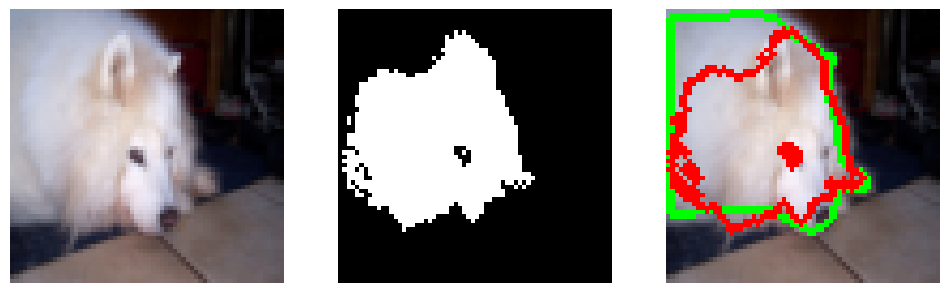

dice for samoyed-172 : 0.807
1/1 [==============================] - 0s 22ms/step
(64, 64) (64, 64)


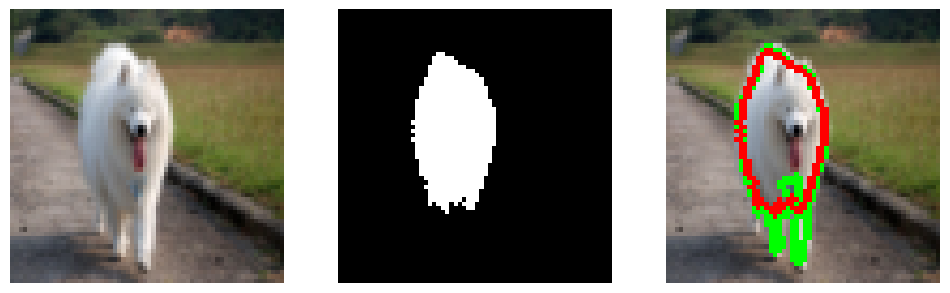

dice for samoyed-173 : 0.896
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


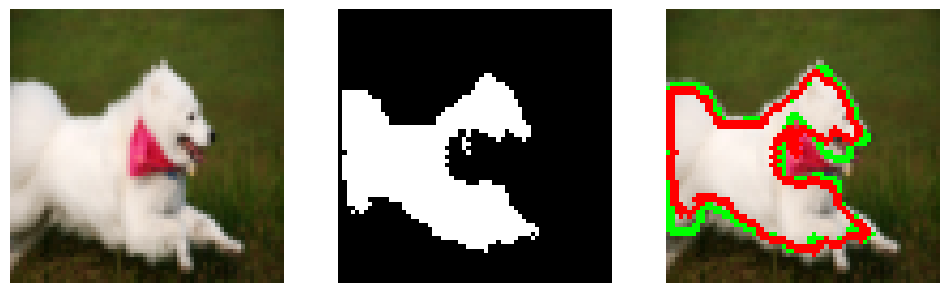

dice for samoyed-174 : 0.898
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


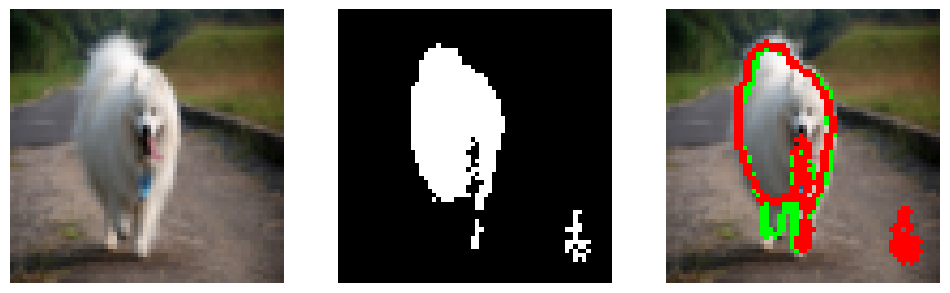

dice for samoyed-175 : 0.868
1/1 [==============================] - 0s 32ms/step
(64, 64) (64, 64)


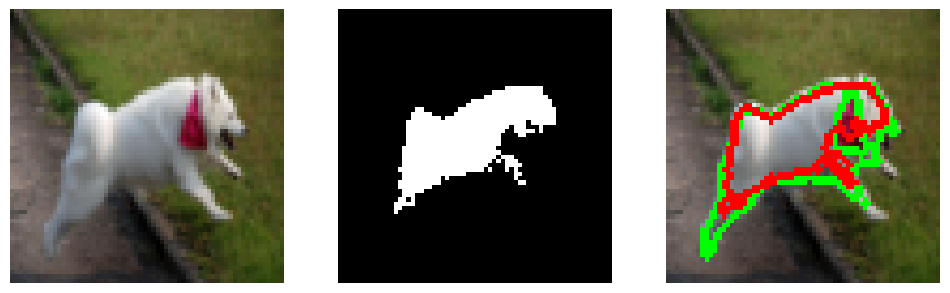

dice for samoyed-176 : 0.796
1/1 [==============================] - 0s 29ms/step
(64, 64) (64, 64)


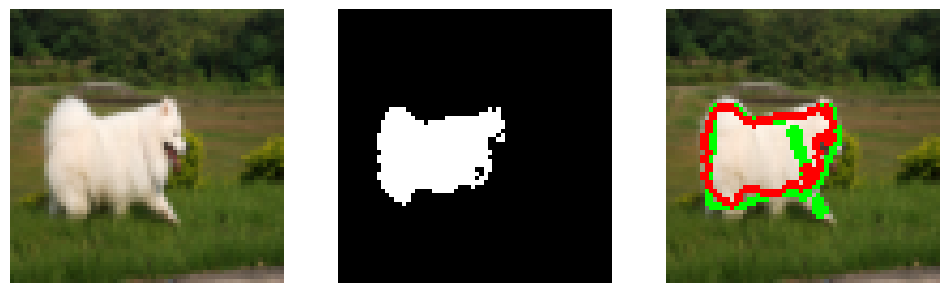

dice for samoyed-177 : 0.876
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


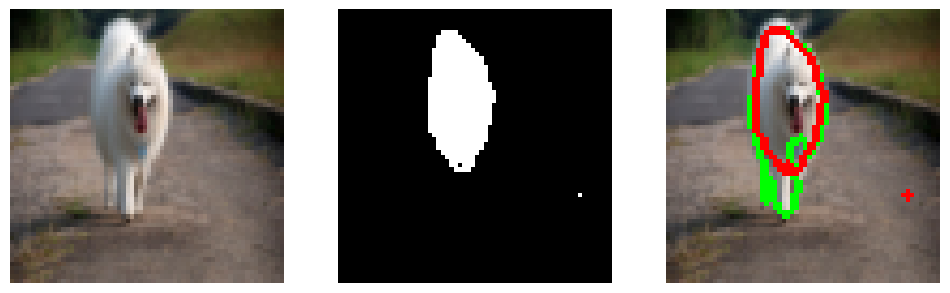

dice for samoyed-178 : 0.847
1/1 [==============================] - 0s 48ms/step
(64, 64) (64, 64)


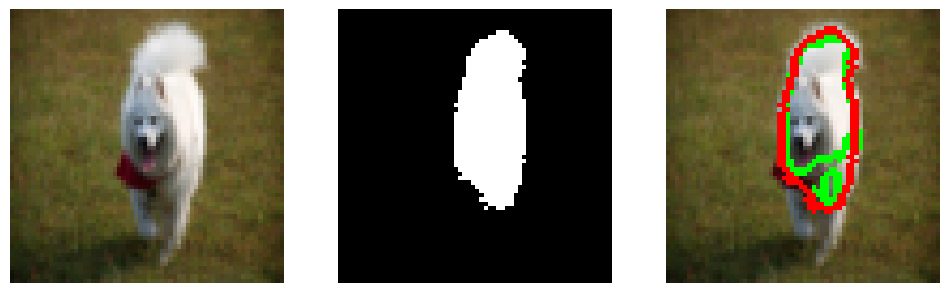

dice for samoyed-179 : 0.840
1/1 [==============================] - 0s 36ms/step
(64, 64) (64, 64)


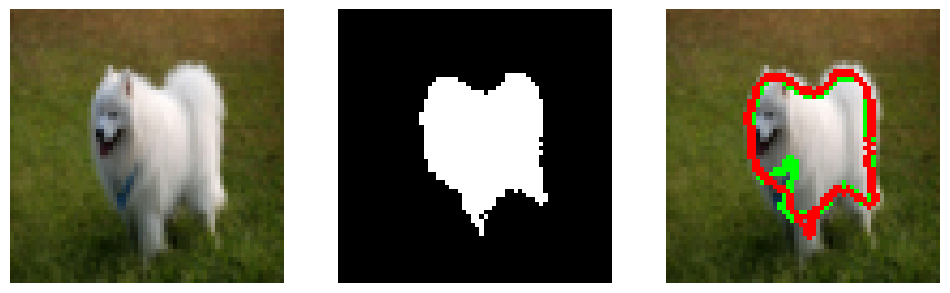

dice for samoyed-180 : 0.934
1/1 [==============================] - 0s 33ms/step
(64, 64) (64, 64)


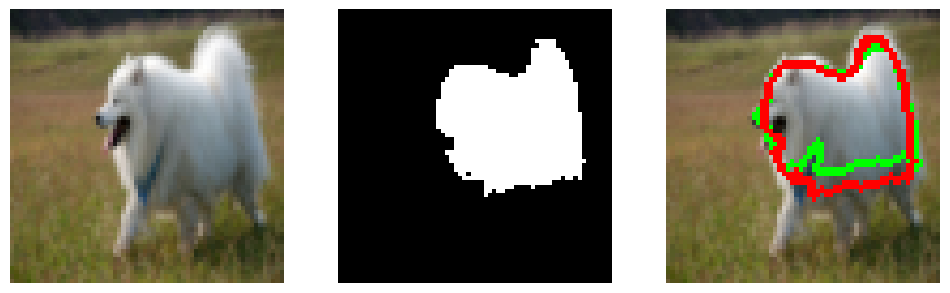

dice for samoyed-181 : 0.883
1/1 [==============================] - 0s 45ms/step
(64, 64) (64, 64)


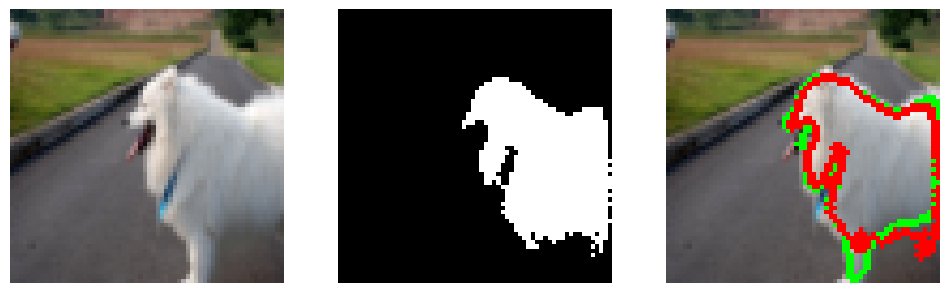

dice for samoyed-182 : 0.915
1/1 [==============================] - 0s 84ms/step
(64, 64) (64, 64)


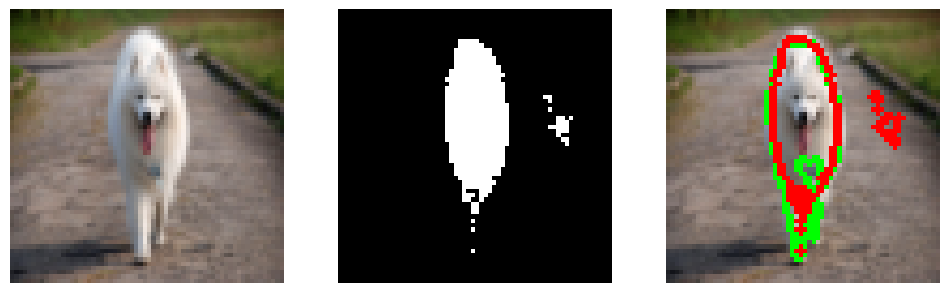

dice for samoyed-183 : 0.839
1/1 [==============================] - 0s 49ms/step
(64, 64) (64, 64)


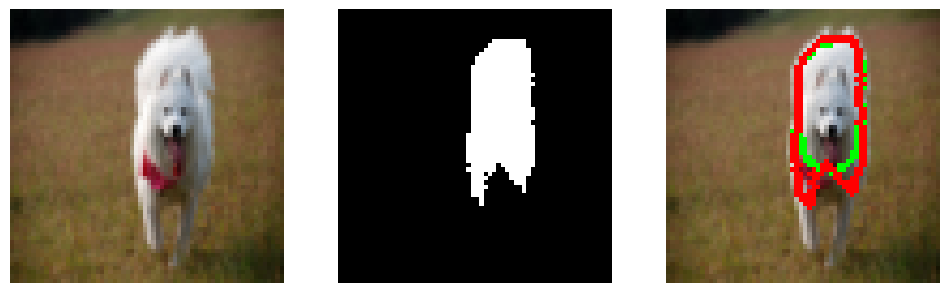

dice for samoyed-184 : 0.885
1/1 [==============================] - 0s 107ms/step
(64, 64) (64, 64)


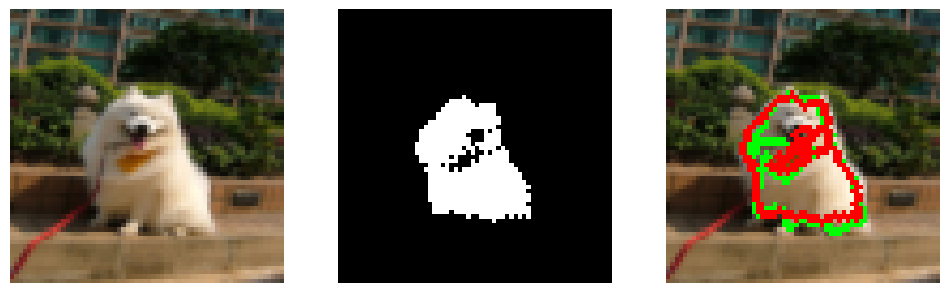

dice for samoyed-185 : 0.832
1/1 [==============================] - 0s 81ms/step
(64, 64) (64, 64)


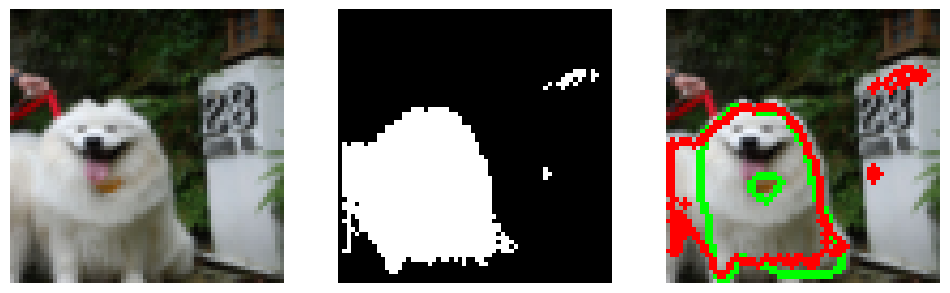

dice for samoyed-186 : 0.832
1/1 [==============================] - 0s 30ms/step
(64, 64) (64, 64)


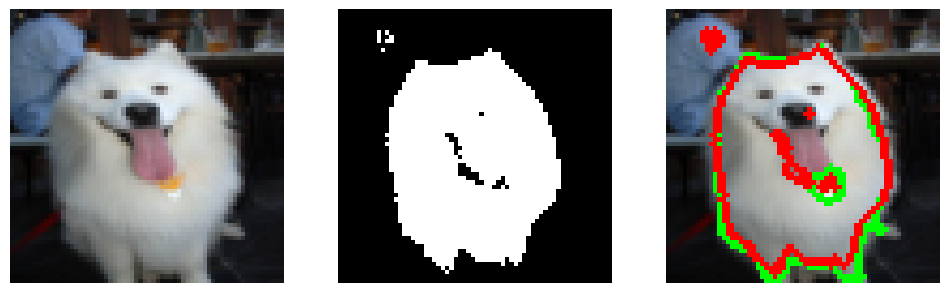

dice for samoyed-187 : 0.935
1/1 [==============================] - 0s 31ms/step
(64, 64) (64, 64)


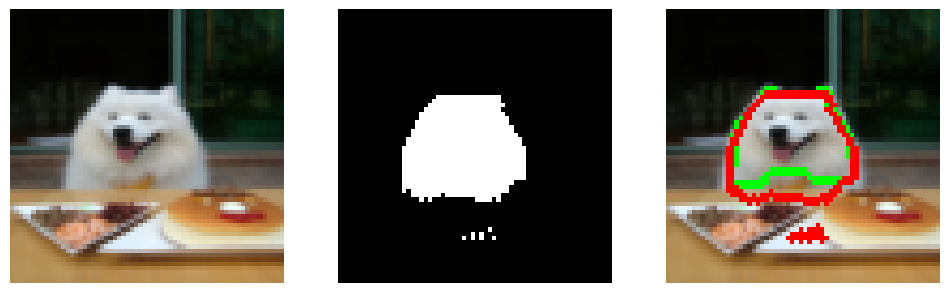

dice for samoyed-188 : 0.865
1/1 [==============================] - 0s 42ms/step
(64, 64) (64, 64)


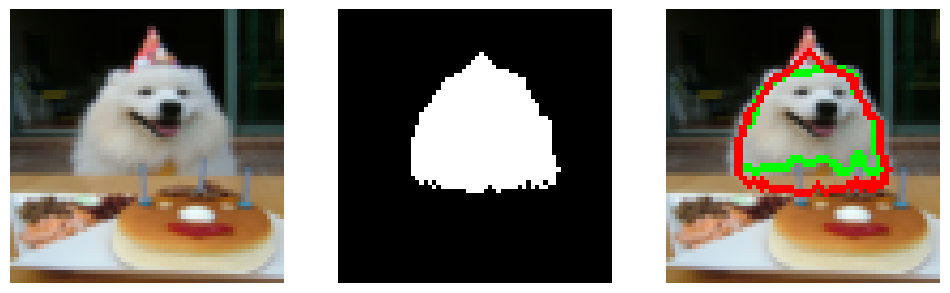

dice for samoyed-189 : 0.841
1/1 [==============================] - 0s 51ms/step
(64, 64) (64, 64)


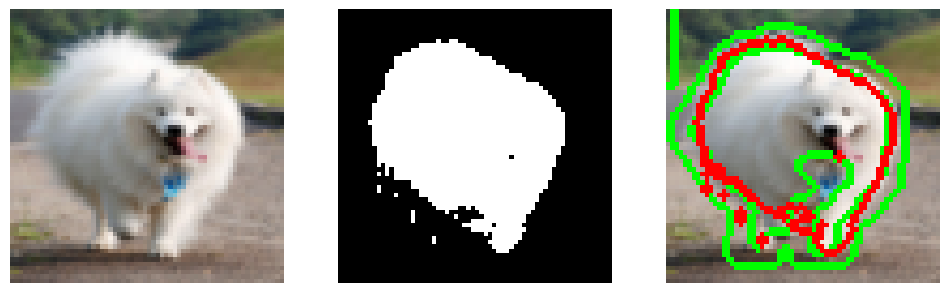

dice for samoyed-190 : 0.538
1/1 [==============================] - 0s 23ms/step
(64, 64) (64, 64)


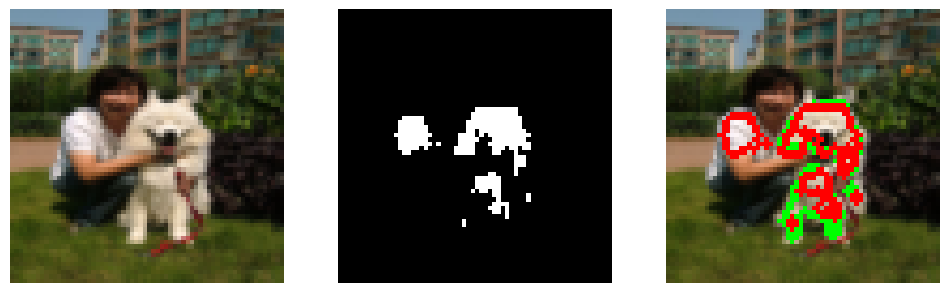

dice for samoyed-191 : 0.655
1/1 [==============================] - 0s 28ms/step
(64, 64) (64, 64)


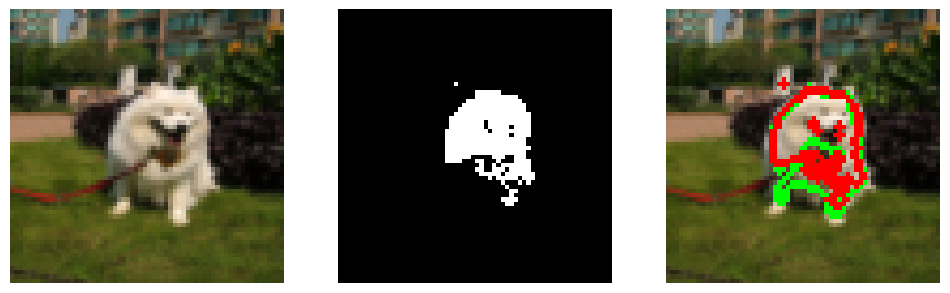

dice for samoyed-192 : 0.805
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


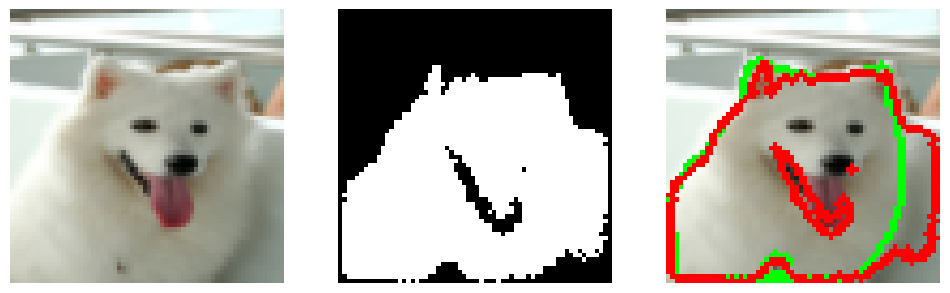

dice for samoyed-193 : 0.894
1/1 [==============================] - 0s 25ms/step
(64, 64) (64, 64)


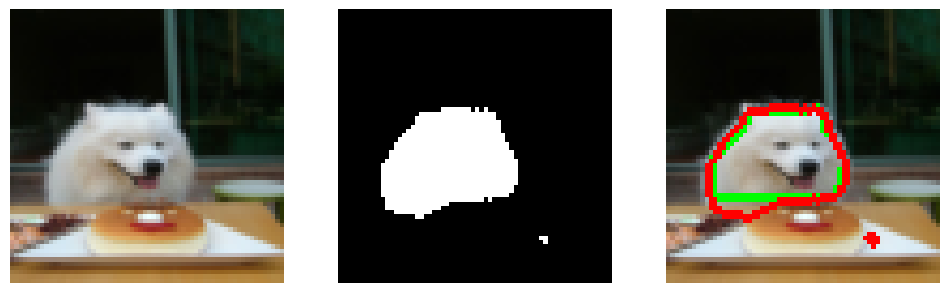

dice for samoyed-194 : 0.906
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


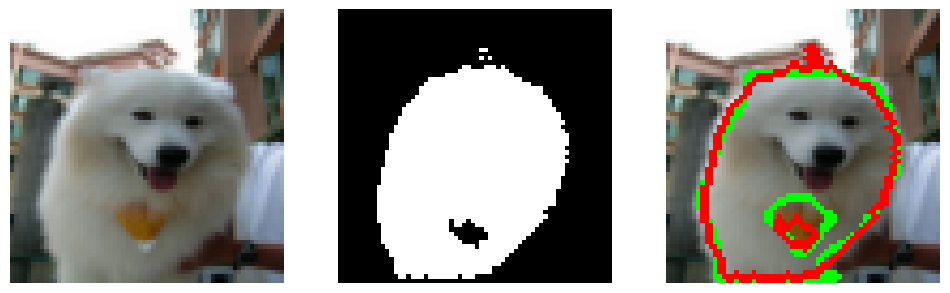

dice for samoyed-195 : 0.935
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


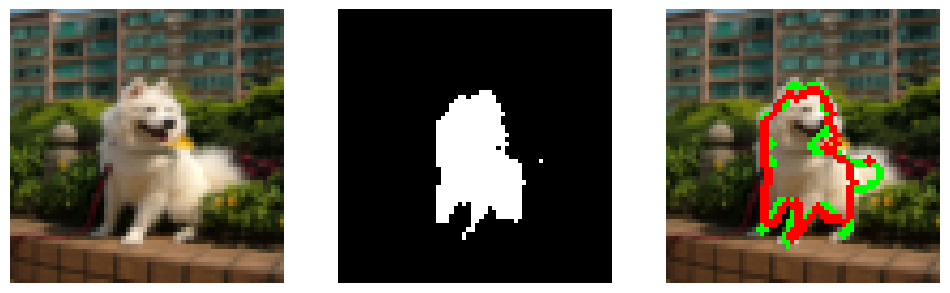

dice for samoyed-196 : 0.873
1/1 [==============================] - 0s 20ms/step
(64, 64) (64, 64)


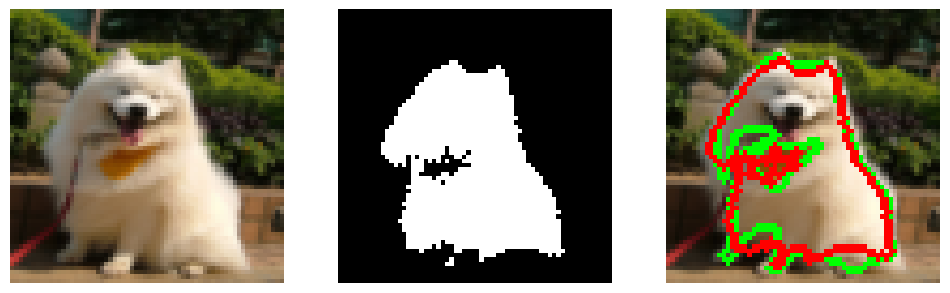

dice for samoyed-197 : 0.884
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


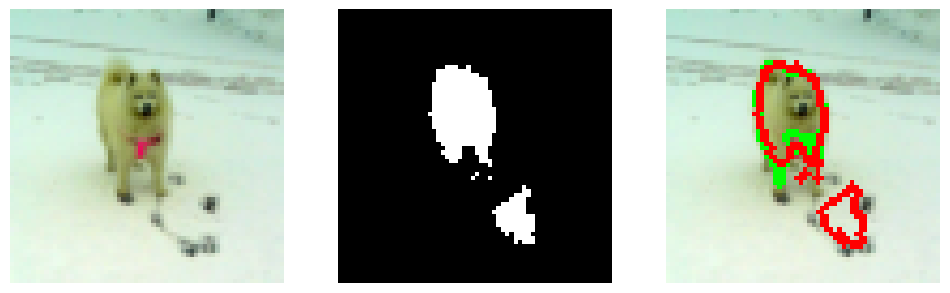

dice for samoyed-198 : 0.779
1/1 [==============================] - 0s 27ms/step
(64, 64) (64, 64)


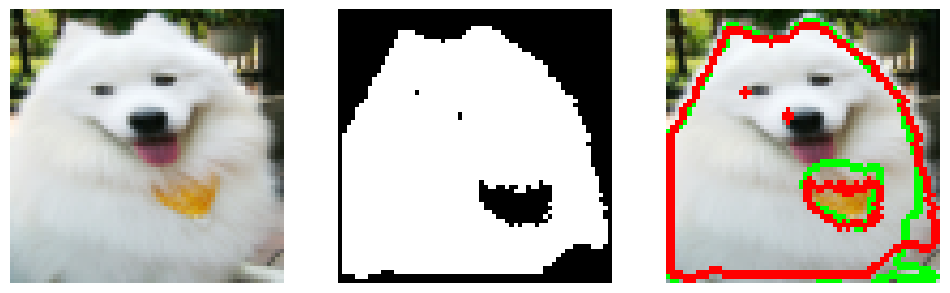

dice for samoyed-199 : 0.931
1/1 [==============================] - 0s 21ms/step
(64, 64) (64, 64)


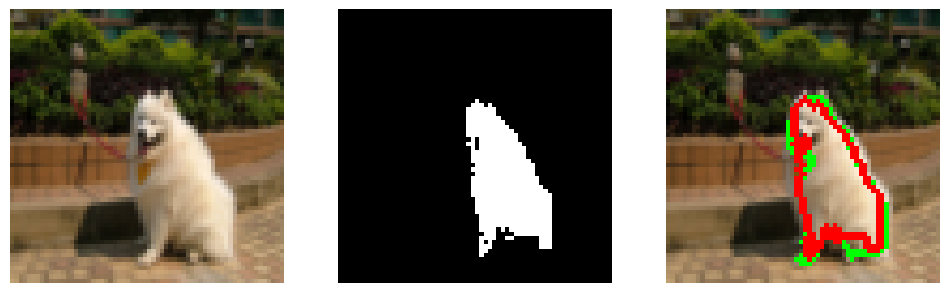

dice for samoyed-200 : 0.907
average dice: 0.851


In [31]:
epochs = 50
model_5 = get_model_5(size_, size_)
model_5.summary()
hist_5 = model_5.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint]) # TO DO
display_history(hist_5) # TO DO
dices_5 = make_prediction(model_5, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_5))) # TO DO

**Question 11 -** Based on the figure below and average dice scores, comment on the segmentation accuracy reached for the 5 models. What is the best model and why?

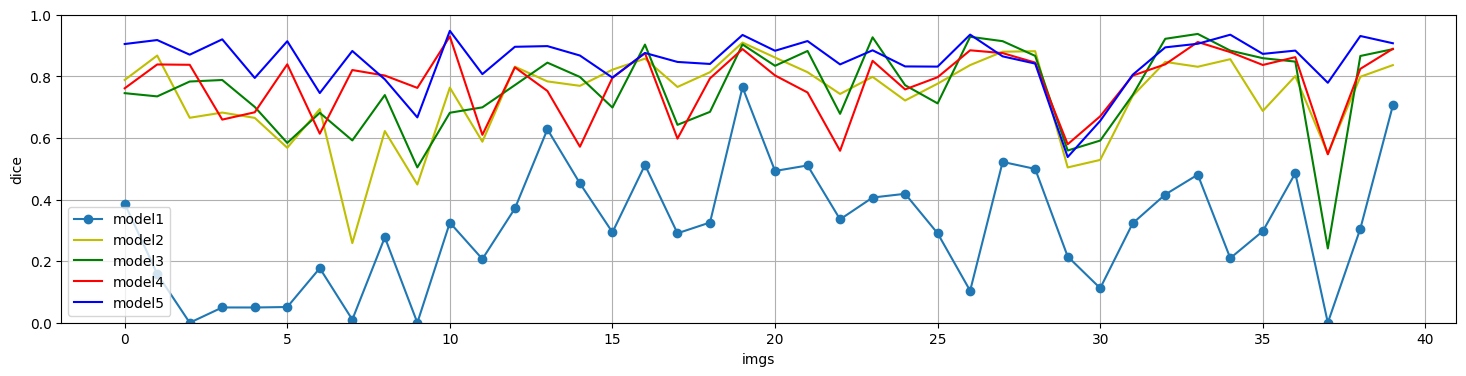

model 1: 0.311
model 2: 0.736
model 3: 0.758
model 4: 0.775
model 5: 0.851


In [32]:
plt.figure(figsize=(18, 4))
plt.plot(dices_1,'o-')
plt.plot(dices_2,'y-')
plt.plot(dices_3,'g-')
plt.plot(dices_4,'r-')
plt.plot(dices_5,'b-')
plt.grid()
plt.plot()
plt.ylabel('dice')
plt.ylim([0,1])
plt.xlabel('imgs')
plt.legend(['model1', 'model2','model3', 'model4','model5'], loc='lower left')
plt.show()

print('model 1: %02.3f'%(np.mean(dices_1)))
print('model 2: %02.3f'%(np.mean(dices_2)))
print('model 3: %02.3f'%(np.mean(dices_3)))
print('model 4: %02.3f'%(np.mean(dices_4)))
print('model 5: %02.3f'%(np.mean(dices_5)))

**Answer** :
Dice Coefficient results confrontation:

1. **Model 1: 0.311**: Architecture with multiple convolutional layers

   - Could benefit from further tuning or a more complex architecture.

2. **Model 2: 0.736**: Architecture with convolutional layers, max pooling, and transpose convolutions
   - Good performance with a higher Dice Coefficient.
   - The use of max pooling and transpose convolutions seems effective.

3. **Model 3: 0.758**: Architecture with skip connections using concatenate
   - The addition of skip connections using concatenate improved the performance.

4. **Model 4: 0.775**: Deep architecture with multiple convolutional layers, max pooling, and transpose convolutions
   - Good performance with a high Dice Coefficient.
   - The deep architecture and use of skip connections likely contribute to better segmentation.

5. **Model 5: 0.851**: Architecture leveraging VGG16 as a base with skip connections has the highest Dice Coefficient.

### Analysis:
- Model 5 outperform the other models, with Dice Coefficients quite close to 1 (of 0.851).
- Models 2, 3 and 4 demonstrate good performance, indicating that the incorporation of specific architectural elements, such as max pooling, transpose convolutions, and deep architectures with skip connections, positively impacts segmentation results.
- From model 1 to model 5 the improvement is clear by analysing the output images.

**Answer** :
Dice Coefficient results confrontation:

1. **Model 1: 0.540**: Architecture with multiple convolutional layers
   - Moderate performance with a Dice Coefficient of 0.540.
   - Could benefit from further tuning or a more complex architecture.

2. **Model 2: 0.717**: Architecture with convolutional layers, max pooling, and transpose convolutions
   - Good performance with a higher Dice Coefficient of 0.717.
   - The use of max pooling and transpose convolutions seems effective.

3. **Model 3: 0.523**: Architecture with skip connections using concatenate
   - Moderate performance similar to Model 1.
   - The addition of skip connections using concatenate may not have significantly improved the performance.

4. **Model 4: 0.726**: Deep architecture with multiple convolutional layers, max pooling, and transpose convolutions
   - Good performance with a high Dice Coefficient of 0.726.
   - The deep architecture and use of skip connections likely contribute to better segmentation.

5. **Model 5: 0.000**: Architecture leveraging VGG16 as a base with skip connections
   - The Dice Coefficient of 0.000 indicates that this model did not produce any correct predictions.
   - There might be issues with the architecture, training, or data.

### Analysis:
- Models 2 and 4 outperform the other models, with Dice Coefficients of 0.717 and 0.726, respectively.
- Model 5 has a Dice Coefficient of 0.000,s suggeting that VGG16 is not appropriate and has a large receptive field due to its deep architecture with small convolutional filters which is beneficial for capturing global features in image classification but may not be ideal for detailed segmentation where local features are crucial.


***

## II - Object detection

The goal of Sect.II is to create an automatic **face detection model** with deep learning able to accurately localize *samoyed* heads in each image by mean of a bounding box.

In [33]:
import xml.etree.ElementTree as ET

def xml2coordinates(xmlpath):
    tree = ET.parse(xmlpath)
    height = int(tree.findtext("./size/height"))
    width = int(tree.findtext("./size/width"))
    xmin = int(tree.findtext("./object/bndbox/xmin"))
    xmax = int(tree.findtext("./object/bndbox/xmax"))
    ymin = int(tree.findtext("./object/bndbox/ymin"))
    ymax = int(tree.findtext("./object/bndbox/ymax"))
    return height, width, xmin, xmax, ymin, ymax

Groundtruth bounding box coordinates are provided in XML files for 98 images (from `samoyed-11` to `samoyed-18` and from `samoyed-100` to `samoyed-189`).

In [34]:
xml_ids = list(range(11,19))+list(range(100,190))
print(xml_ids)

[11, 12, 13, 14, 15, 16, 17, 18, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]


Let us rebuild our dataset with associated bounding box coordinates (extracted from `.xml` files).

In [35]:
idxs = []

imgs = np.ndarray((len(xml_ids), size_, size_, 3), dtype=np.float32)
xmins = np.ndarray(len(xml_ids), dtype=np.uint8)
xmaxs = np.ndarray(len(xml_ids), dtype=np.uint8)
ymins = np.ndarray(len(xml_ids), dtype=np.uint8)
ymaxs = np.ndarray(len(xml_ids), dtype=np.uint8)

for idx, id_ in enumerate(xml_ids):
    name = 'samoyed-'+str(id_)
    img = io.imread(os.path.join(base_path,name+'.jpg'))
    height, width, xmin, xmax, ymin, ymax = xml2coordinates(os.path.join(base_path,name+'.xml'))
    imgs[idx, :,:,:] = resize(img,output_shape=(size_,size_))
    xmins[idx] = int(np.floor(size_*ymin/height))
    xmaxs[idx] = int(np.floor(size_*ymax/height))
    ymins[idx] = int(np.floor(size_*xmin/width))
    ymaxs[idx] = int(np.floor(size_*xmax/width))
    idxs.append(name)

**Question 12 -** Normalize the dataset using `normalization()` and use the `visualize_predicted_box()` function to visualize the first eight images with super-imposed bounding boxes.

In [36]:
# data normalization
imgs = normalization(imgs)

In [37]:
def visualize_predicted_box(img, xmin, xmax, ymin, ymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(0, 1, 0))
    return out

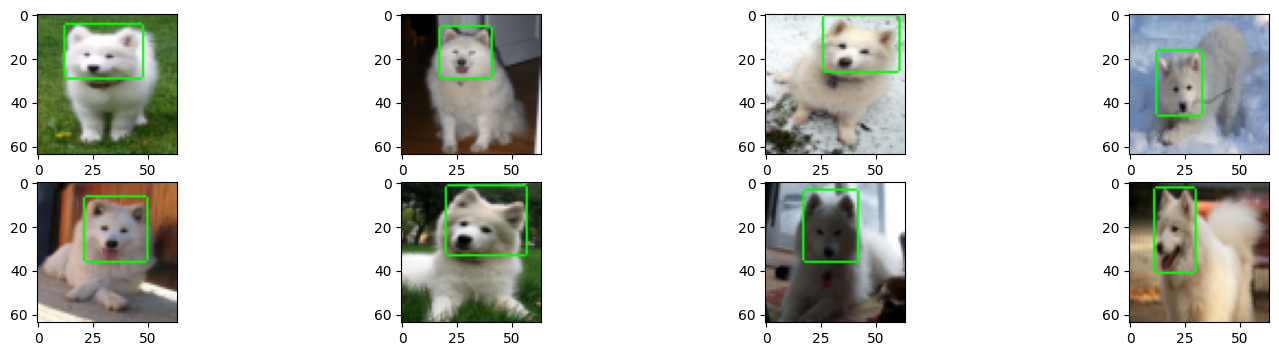

In [40]:
plt.figure(figsize=(18, 4))
for idx , id_ in enumerate(imgs[:8]):
  plt.subplot(2, 4, idx+ 1)
  out = visualize_predicted_box(imgs[idx], xmins[idx], xmaxs[idx], ymins[idx], ymaxs[idx])
  plt.imshow(out)
plt.show()

**Question 13 -** Using pre-trained `VGG16` and fully-connected layers, build a deep regression model able to infer the `4` bounding box coordinates from a given intput image. The mean absolute error (`mean_absolute_error`) will be used as loss function.

In [41]:
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16


def get_model_6(img_rows, img_cols):

    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

    flatten = Flatten()(vgg16_model.get_layer('block5_conv3').output)

    # Add fully connected layers for regression
    dense = Dense(256, activation='relu')(flatten)
    dense = Dense(128, activation='relu')(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dense(4, activation='linear', name='bounding_box')(dense)

    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[dense])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error', metrics=['mean_absolute_error'])

    return model

This model is a convolutional neural network (CNN) with a VGG16 base for image feature extraction. It consists of fully connected layers for regression, predicting bounding box coordinates (x, y, width, height). The model is compiled with the Adam optimizer and mean absolute error loss. It is designed for object detection or localization tasks.

In [42]:
model_6 = get_model_6(size_, size_)
model_6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

**Question 14 -** Divide the dataset into training and test subsets (with a ratio of `70%`), run the training and display how evolves the loss function during training for both subsets.

In [43]:
ratio = 0.7
split = int(len(imgs)*ratio)
print('dataset size =', len(imgs), '; first', split, 'images for training, remaining for test')
train_imgs = imgs[:split]
test_imgs = imgs [split:]
train_xmins, train_xmaxs, train_ymins, train_ymaxs = xmins[:split], xmaxs[:split], ymins[:split], ymaxs[:split]
test_xmins, test_xmaxs, test_ymins, test_ymaxs = xmins[split:], xmaxs[split:], ymins[split:], ymaxs[split:]
train_idxs = idxs[:split]
test_idxs = idxs[split:]

dataset size = 98 ; first 68 images for training, remaining for test


In [44]:
batch_size = 10
epochs = 100

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_mean_absolute_error', verbose=0, save_best_only=False, save_weights_only=True, mode='max', save_freq='epoch')

`train_coords` is a 2D array where each row represents a training sample, and the columns represent the minimum x-coordinate, maximum x-coordinate, minimum y-coordinate, and maximum y-coordinate of the bounding box.

`test_coords` is similarly structured but for the test dataset.

In [45]:
train_coords = np.vstack([train_xmins,train_xmaxs,train_ymins,train_ymaxs]).T
test_coords = np.vstack([test_xmins,test_xmaxs,test_ymins,test_ymaxs]).T

hist_6 = model_6.fit(train_imgs, train_coords, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data= (test_imgs,test_coords), callbacks=[model_checkpoint])

Epoch 1/100
7/7 [==============================] - 7s 401ms/step - loss: 21.3526 - mean_absolute_error: 21.3526 - val_loss: 10.4444 - val_mean_absolute_error: 10.4444
Epoch 2/100
7/7 [==============================] - 0s 63ms/step - loss: 7.6612 - mean_absolute_error: 7.6612 - val_loss: 8.1180 - val_mean_absolute_error: 8.1180
Epoch 3/100
7/7 [==============================] - 0s 69ms/step - loss: 6.8545 - mean_absolute_error: 6.8545 - val_loss: 5.8471 - val_mean_absolute_error: 5.8471
Epoch 4/100
7/7 [==============================] - 1s 78ms/step - loss: 5.9202 - mean_absolute_error: 5.9202 - val_loss: 5.0409 - val_mean_absolute_error: 5.0409
Epoch 5/100
7/7 [==============================] - 4s 609ms/step - loss: 5.1293 - mean_absolute_error: 5.1293 - val_loss: 5.7393 - val_mean_absolute_error: 5.7393
Epoch 6/100
7/7 [==============================] - 1s 102ms/step - loss: 4.6408 - mean_absolute_error: 4.6408 - val_loss: 5.6792 - val_mean_absolute_error: 5.6792
Epoch 7/100
7/7 [====

In [46]:
def display_history_2(hist):
    plt.plot(hist.history['mean_absolute_error'])
    plt.plot(hist.history['val_mean_absolute_error'])
    plt.grid()
    plt.title('model loss')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

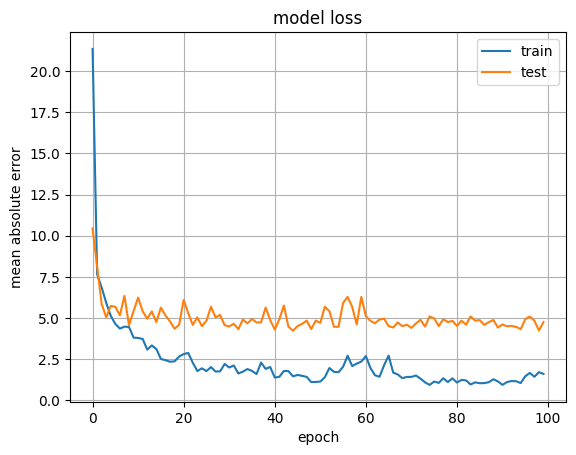

In [47]:
display_history_2(hist_6)

The loss model evolution indicates a decreasing mean square error (MSE) as the number of epochs increases, eventually stabilizing at a constant value both for both the training and testing phases (~1 for the train, ~4 for the test).

**Question 15 -** Use the `visualize_predicted_boxes()` function to display the prediction and groundtruth bounding boxes.

In [48]:
def visualize_predicted_boxes(img, xmin, xmax, ymin, ymax, GTxmin, GTxmax, GTymin, GTymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(1, 0, 0), background_label=2)
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[GTxmin:GTxmax+1, GTymin:GTymax+1] = 1
    out = mark_boundaries(out, mask, color=(0, 1, 0), background_label=4)
    return out

samoyed-160
1/1 [==============================] - 0s 157ms/step
[10 30 27 39]
1/1 [==============================] - 0s 17ms/step
6 27 45 54
10 30 27 39


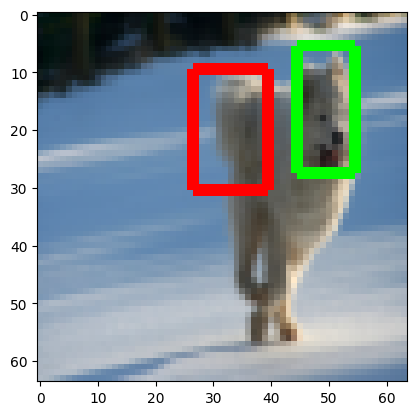

samoyed-161
1/1 [==============================] - 0s 18ms/step
[ 7 27 27 40]
1/1 [==============================] - 0s 17ms/step
2 19 36 45
7 27 27 40


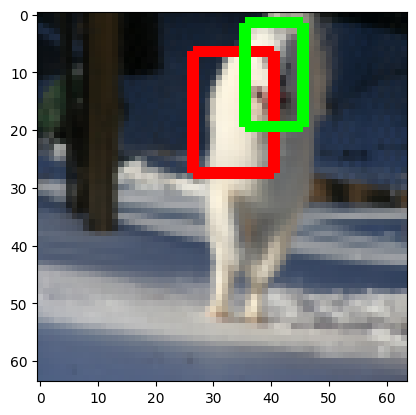

samoyed-162
1/1 [==============================] - 0s 20ms/step
[ 5 32 18 34]
1/1 [==============================] - 0s 18ms/step
10 29 29 39
5 32 18 34


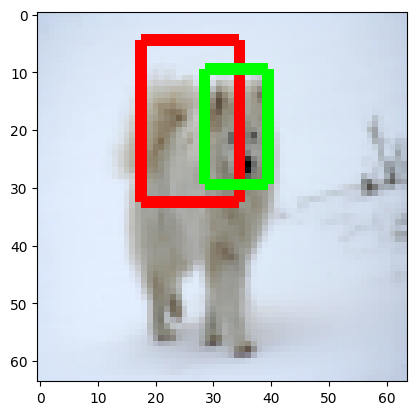

samoyed-163
1/1 [==============================] - 0s 18ms/step
[ 7 30 21 33]
1/1 [==============================] - 0s 18ms/step
11 34 34 45
7 30 21 33


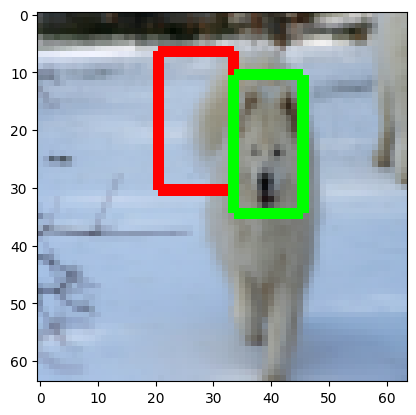

samoyed-164
1/1 [==============================] - 0s 17ms/step
[ 9 31 20 33]
1/1 [==============================] - 0s 24ms/step
6 24 29 38
9 31 20 33


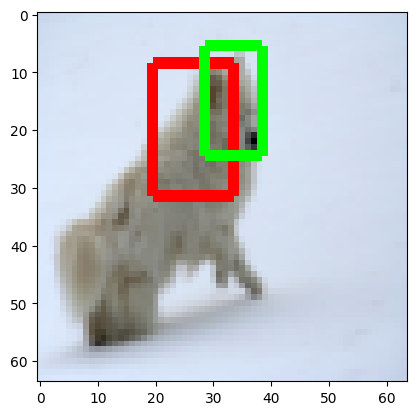

samoyed-165
1/1 [==============================] - 0s 17ms/step
[ 6 38 19 40]
1/1 [==============================] - 0s 17ms/step
16 36 16 52
6 38 19 40


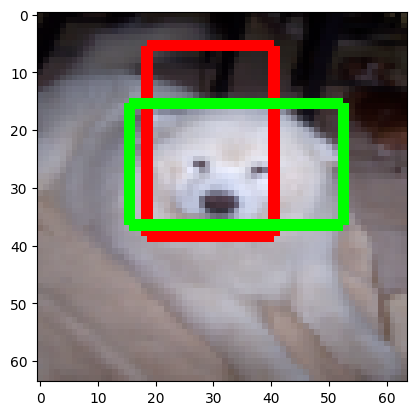

samoyed-166
1/1 [==============================] - 0s 24ms/step
[11 34 26 36]
1/1 [==============================] - 0s 17ms/step
7 30 29 40
11 34 26 36


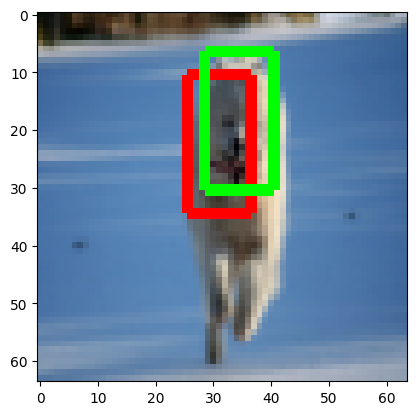

samoyed-167
1/1 [==============================] - 0s 19ms/step
[ 6 43 15 38]
1/1 [==============================] - 0s 17ms/step
9 44 16 39
6 43 15 38


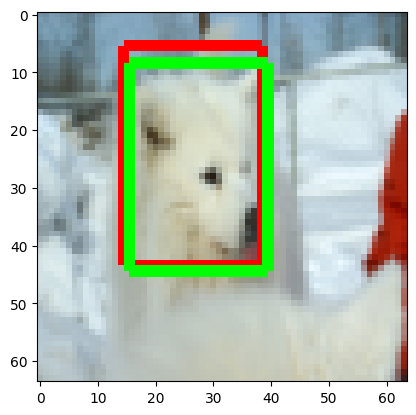

samoyed-168
1/1 [==============================] - 0s 18ms/step
[ 8 23 22 33]
1/1 [==============================] - 0s 17ms/step
5 22 18 38
8 23 22 33


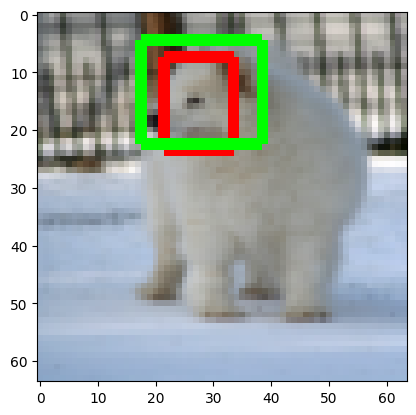

samoyed-169
1/1 [==============================] - 0s 17ms/step
[ 8 46 17 34]
1/1 [==============================] - 0s 24ms/step
8 56 24 43
8 46 17 34


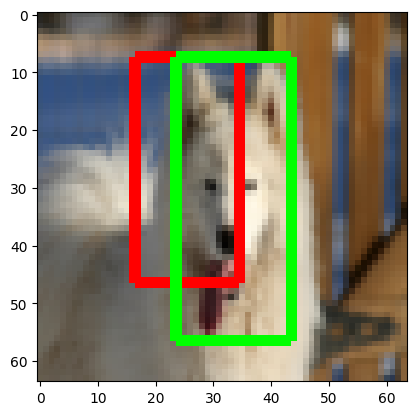

samoyed-170
1/1 [==============================] - 0s 18ms/step
[ 9 30 26 38]
1/1 [==============================] - 0s 17ms/step
14 28 35 42
9 30 26 38


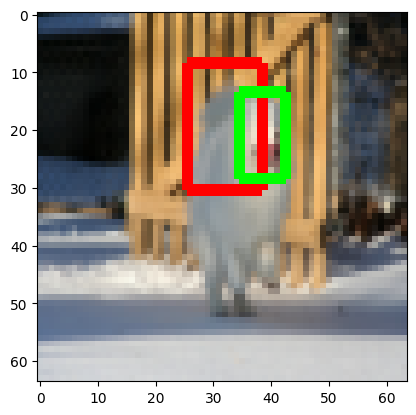

samoyed-171
1/1 [==============================] - 0s 18ms/step
[11 32 19 30]
1/1 [==============================] - 0s 19ms/step
17 48 16 31
11 32 19 30


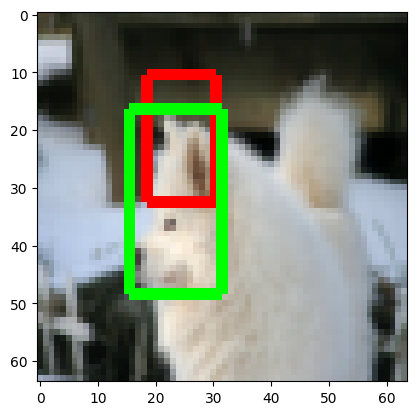

samoyed-172
1/1 [==============================] - 0s 18ms/step
[ 7 32 19 34]
1/1 [==============================] - 0s 18ms/step
5 52 19 40
7 32 19 34


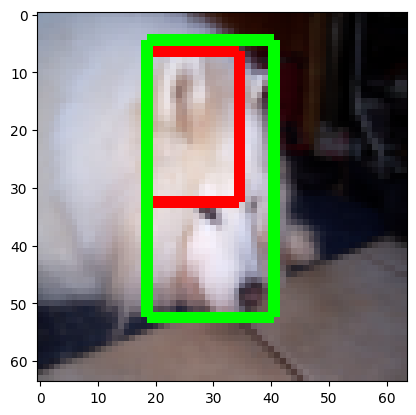

samoyed-173
1/1 [==============================] - 0s 19ms/step
[10 37 23 35]
1/1 [==============================] - 0s 17ms/step
11 37 24 35
10 37 23 35


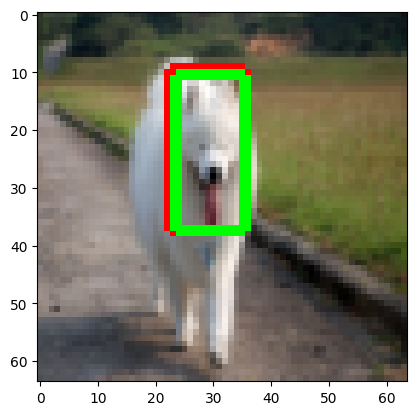

samoyed-174
1/1 [==============================] - 0s 18ms/step
[15 34 23 33]
1/1 [==============================] - 0s 17ms/step
11 36 32 48
15 34 23 33


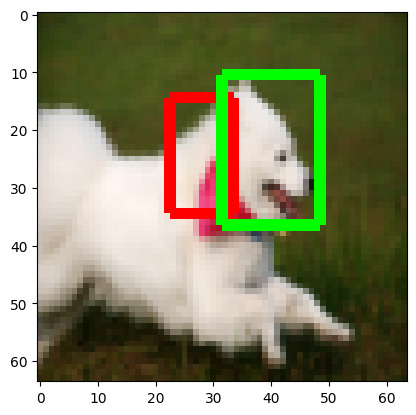

samoyed-175
1/1 [==============================] - 0s 19ms/step
[11 34 22 33]
1/1 [==============================] - 0s 17ms/step
13 35 27 36
11 34 22 33


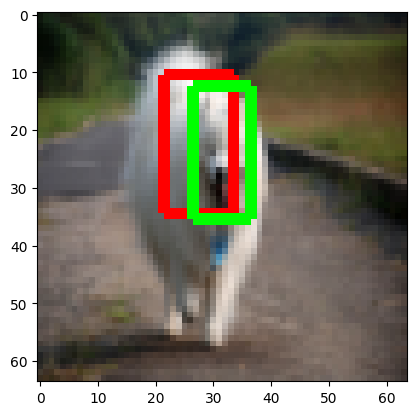

samoyed-176
1/1 [==============================] - 0s 18ms/step
[14 33 23 33]
1/1 [==============================] - 0s 17ms/step
15 33 45 55
14 33 23 33


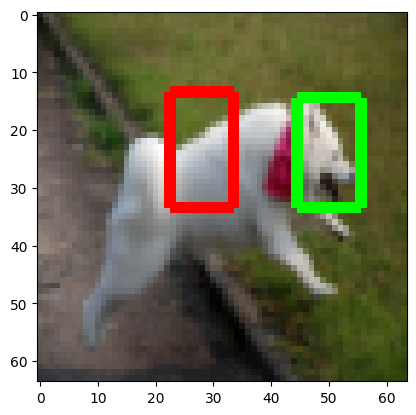

samoyed-177
1/1 [==============================] - 0s 19ms/step
[17 31 21 28]
1/1 [==============================] - 0s 18ms/step
20 37 33 41
17 31 21 28


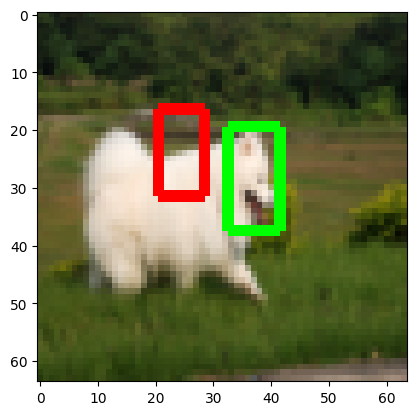

samoyed-178
1/1 [==============================] - 0s 18ms/step
[ 8 28 22 32]
1/1 [==============================] - 0s 18ms/step
7 28 26 35
8 28 22 32


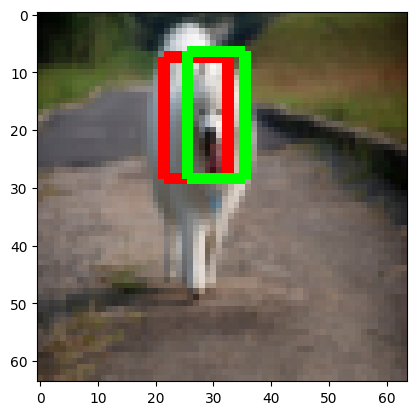

samoyed-179
1/1 [==============================] - 0s 21ms/step
[ 7 40 23 37]
1/1 [==============================] - 0s 17ms/step
13 38 27 36
7 40 23 37


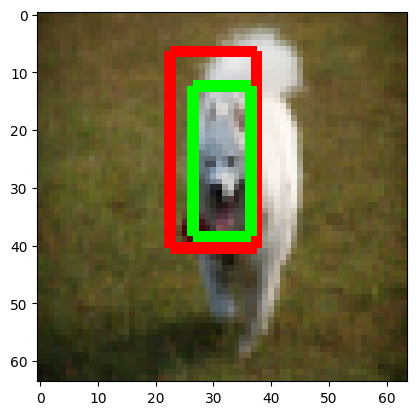

samoyed-180
1/1 [==============================] - 0s 18ms/step
[13 37 17 30]
1/1 [==============================] - 0s 17ms/step
12 34 19 29
13 37 17 30


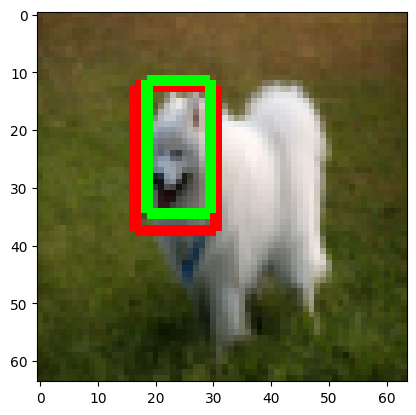

samoyed-181
1/1 [==============================] - 0s 18ms/step
[11 33 20 32]
1/1 [==============================] - 0s 17ms/step
10 34 19 32
11 33 20 32


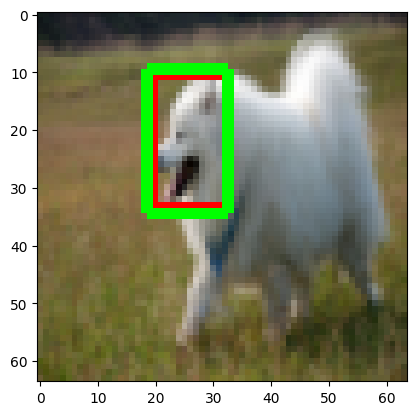

samoyed-182
1/1 [==============================] - 0s 18ms/step
[14 30 23 31]
1/1 [==============================] - 0s 17ms/step
13 36 26 39
14 30 23 31


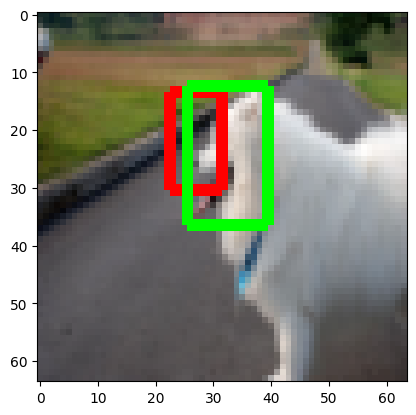

samoyed-183
1/1 [==============================] - 0s 18ms/step
[ 7 31 22 35]
1/1 [==============================] - 0s 17ms/step
9 33 27 38
7 31 22 35


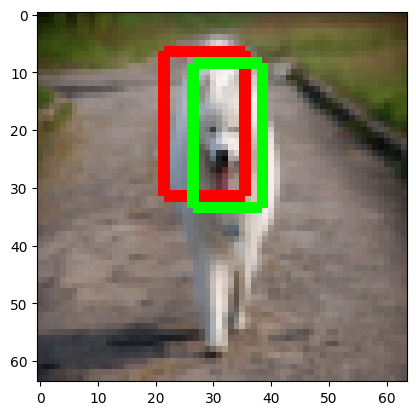

samoyed-184
1/1 [==============================] - 0s 29ms/step
[ 8 37 27 40]
1/1 [==============================] - 0s 28ms/step
11 39 33 44
8 37 27 40


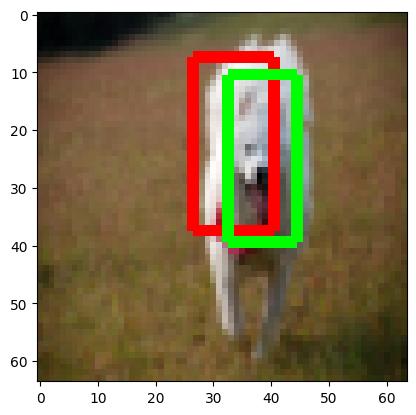

samoyed-185
1/1 [==============================] - 0s 62ms/step
[13 33 21 34]
1/1 [==============================] - 0s 50ms/step
18 32 24 38
13 33 21 34


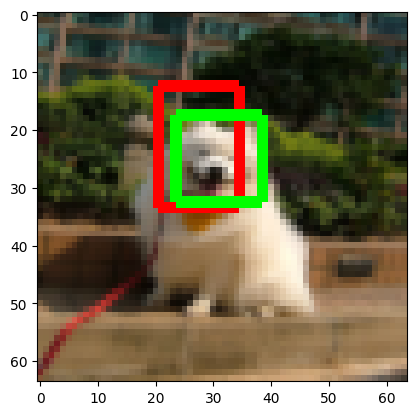

samoyed-186
1/1 [==============================] - 0s 36ms/step
[14 42 19 37]
1/1 [==============================] - 0s 40ms/step
20 40 10 30
14 42 19 37


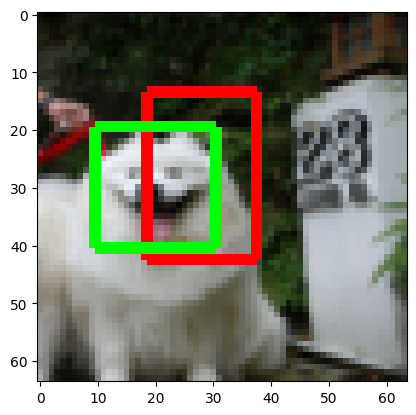

samoyed-187
1/1 [==============================] - 0s 39ms/step
[ 1 33 14 41]
1/1 [==============================] - 0s 32ms/step
7 40 14 43
1 33 14 41


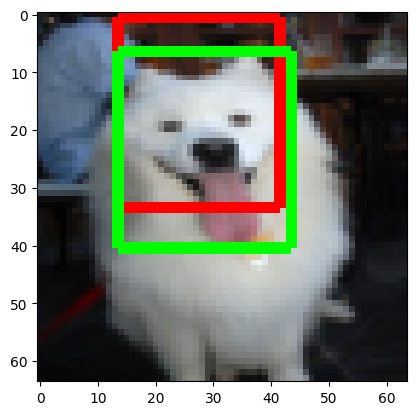

samoyed-188
1/1 [==============================] - 0s 25ms/step
[13 42 19 39]
1/1 [==============================] - 0s 42ms/step
17 35 19 39
13 42 19 39


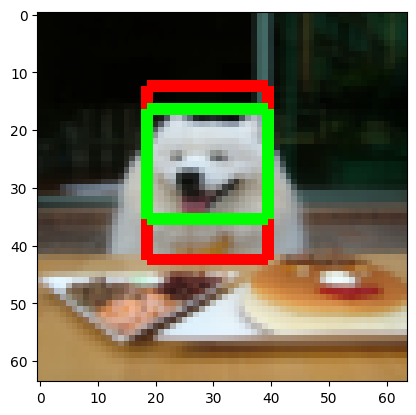

samoyed-189
1/1 [==============================] - 0s 60ms/step
[ 5 36 20 47]
1/1 [==============================] - 0s 42ms/step
12 30 22 45
5 36 20 47


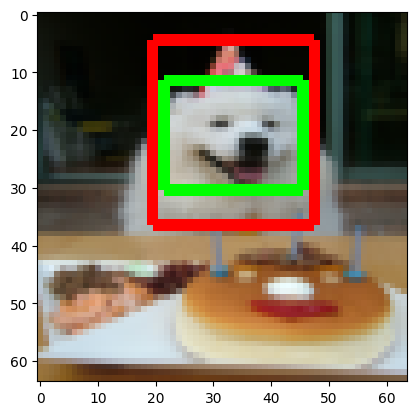

In [49]:
from skimage.color import gray2rgb
model_6.load_weights('./weights.hdf5')
for idx, id_ in enumerate(test_idxs):
    print(id_)
    print(model_6.predict(test_imgs[idx:idx+1,:,:,0:3]).astype(np.uint8)[0])
    xmin, xmax, ymin, ymax = model_6.predict(test_imgs[idx:idx+1,:,:,0:3]).astype(np.uint8)[0]
    GTxmin, GTxmax, GTymin, GTymax= test_xmins[idx],test_xmaxs[idx],test_ymins[idx],test_ymaxs[idx]
    print(GTxmin, GTxmax, GTymin, GTymax)
    print(xmin, xmax, ymin, ymax)
    plt.imshow(visualize_predicted_boxes( test_imgs[idx:idx+1,:,:,0:3].squeeze()  ,xmin.squeeze(), xmax.squeeze(), ymin.squeeze(), ymax.squeeze(), GTxmin.squeeze(), GTxmax.squeeze(), GTymin.squeeze(), GTymax.squeeze())) # TO DO
    plt.show()

***

The model 6 manages to predict quite well the samoyed faces.

Do not forget to upload your notebook on **Moodle**. Thank you !